<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Accor/Accor_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AC.PA"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02  25.07  25.56  24.65  25.56      18.45  1225724
2009-01-05  25.70  26.43  25.60  26.19      18.90  1660146
2009-01-06  26.22  26.24  24.88  24.91      17.98  2804791
2009-01-07  24.70  24.82  23.41  23.75      17.14  3964044
2009-01-08  23.63  24.03  23.25  23.41      16.90  3471459
...           ...    ...    ...    ...        ...      ...
2018-12-21  36.04  36.10  35.48  35.73      34.69  1468793
2018-12-24  35.46  36.20  35.30  36.20      35.14   441361
2018-12-27  36.12  36.20  35.36  35.62      34.58   972935
2018-12-28  35.75  36.53  35.70  36.44      35.38   608698
2018-12-31  36.73  37.11  36.60  37.11      36.03   220390

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     33.339992    33.705802    32.960489    33.329816    29.465149  1.117582e+06
std       8.022241     8.044637     8.010759     8.029058     8.877724  6.131032e+05
min      17.100000    17.840000    17.030000    17.030000    12.820000  0.000000e+00
25%      26.387500    26.710000    26.050000    26.377500    21.400000  7.270235e+05
50%      33.500000    33.820000    33.150000    33.495000    29.720000  9.665005e+05
75%      39.502500    40.002500    39.100000    39.445000    36.985000  1.332391e+06
max      51.630000    51.650000    50.690000    51.340000    47.220000  5.617396e+06

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  19.48  20.14  19.14  19.31      13.94  1340717   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  19.071752  19.412215  17.936000  18.879541  19.185912  19.545073      18.905      19.020  20.163236  18.90000  19.159398  18.7580  18.977222  18.90000  19.296667  20.078513               20.105570                 18.90000               17.694430               20.708356                 18.90000               17.091644               21.311141                 18.90000               16.488859               21.913926                 18.90000               15.886074  19.185912  19.193014  19.881672               20.391483                19.185912               17.980342               20.994268                19.185912               17.377557               21.597053                19.185912               16.774771               22.199838                19.185912   
2009-03-16  19.73  19.77  19.51  19.77      14.27  1282771   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  19.106664  19.404576  18.024160  19.178374  19.315709  19.546049      18.910      19.020  20.140000  18.90125  19.527514  18.9250  19.170556  18.90125  19.540000  19.939520               20.110400                 18.90125               17.692100               20.714975                 18.90125               17.087525               21.319550                 18.90125               16.482950               21.924125                 18.90125               15.878375  19.315709  19.596104  19.754863               20.524859                19.315709               18.106559               21.129434                19.315709               17.501984               21.734009                19.315709               16.897409               22.338584                19.315709   
2009-03-17  19.59  19.71  19.10  19.31      1

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     33.570415    33.935878    33.194489    33.562634    29.741097  1.093932e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    33.545237    33.472591     1.050774    33.562470    33.538282    33.553751    33.518057    33.510090    33.417044    33.538258    33.562661    33.538287    33.546373    33.538258    33.555998    33.490095               34.704279                33.538258               32.372236               35.287290                33.538258               31.789225               35.870301                33.538258               31.206214               36.453312                33.538258               30.623203    33.538282    33.557289    33.497238               34.704303                33.538282               32.372260               35.287314                33.538282               31.789249               35.870325   
std       7.928186     7.951774     7.911154     7.931692     8.743973  5.822819e+05     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238     7.932570     7.911121    34.415939     7.939901     7.908828     7.981080     7.912212     7.899586     7.968628     7.921355     7.936052     7.927256     7.919461     7.921355     7.925661     7.907305                8.001712                 7.921355                7.897932                8.062755                 7.921355                7.907777                8.137316                 7.921355                7.931947                8.225025                 7.921355                7.970312     7.908828     7.922999     7.909829                7.989488                 7.908828                7.885189                8.050711                 7.908828                7.894961                8.125469   
min      17.100000    17.840000    17.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.068926  0.068027  0.062686  0.066453   0.032558  1340717   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.031125  0.017909  0.685441  0.034896  0.026056  0.037258    0.027267    0.025381  0.090504  0.023229  0.050362  0.024080  0.028761  0.023229  0.049522  0.038700                0.025280                 0.023229                0.035429                0.025967                 0.023229                0.047682                0.027900                 0.023229                0.060914                0.038001                 0.023229                0.074452  0.026056  0.042251  0.034360                0.022992                 0.026056                0.050989                0.023657                 0.026056                0.065391                0.033810                 0.026056                0.079096                0.043659                 0.026056   
2009-03-16  0.076166  0.057084  0.073678  0.079860   0.042151  1282771   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.032199  0.017666  0.686310  0.043875  0.030090  0.037289    0.027420    0.025381  0.089832  0.023267  0.061274  0.029189  0.034676  0.023267  0.056826  0.034249                0.025427                 0.023267                0.035359                0.026166                 0.023267                0.047562                0.028148                 0.023267                0.060747                0.038294                 0.023267                0.074239  0.030090  0.054421  0.030315                0.027071                 0.030090                0.054736                0.027717                 0.030090                0.068994                0.037814                 0.030090                0.082562                0.047608                 0.030090   
2009-03-17  0.072111  0.055309  0.061497  0.066453  

140490

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         1 hour 57 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_tnaytk
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_151010_mod...  0.579870  0.702731              0.479508  0.502677  0.252684
1  DeepLearning_grid_1_AutoML_20190826_151010_mod...  0.518427  0.757788              0.470867  0.528888  0.279723
2              DeepLearning_1_AutoML_20190826_151010  0.502986  0.812082              0.495902  0.506442  0.256484
3  DeepLearning_grid_1_AutoML_20190826_151010_mod...  0.500000  0.693474              0.500000  0.500163  0.250163
4  DeepLearning_grid_1_AutoML_20190826_151010_mod...  0.500000  0.693036              0.500000  0.499944  0.249944
5  DeepLearning_grid_1_AutoML_20190826_151010_mod...  0.500000  0.693301              0.500000  0.500077  0.250077
6  DeepLearning_grid_1_AutoML_20190826_151010_mod...  0.500000  0.693100              0.500000  0.499976  0.249976
7  DeepLearning_grid_1_AutoML_20190826_151010_mod...  0.472995  1.814395              0.487705  0.648691  0.420800
8  DeepLearning_grid_1_AutoML_20190826_151010_mod...  0.469882  1.094076              0.479286  0.602520  0.363030
9  DeepLearning_grid_1_AutoML_20190826_151010_mod...  0.462098  0.697695              0.500000  0.502265  0.252270

variable  relative_importance  scaled_importance  percentage
0           CDLEVENINGDOJISTAR             1.000000           1.000000    0.004478
1                         TANH             0.959868           0.959868    0.004298
2               CDLEVENINGSTAR             0.953977           0.953977    0.004271
3                  CDLPIERCING             0.918000           0.918000    0.004110
4                 CDLTHRUSTING             0.917660           0.917660    0.004109
...                        ...                  ...                ...         ...
1038    BBANDS_lowerband_8_4_3             0.149262           0.149262    0.000668
1039  BBANDS_middleband_24_3_5             0.148846           0.148846    0.000666
1040   BBANDS_lowerband_24_0_5             0.148149           0.148149    0.000663
1041          CDLCOUNTERATTACK             0.128047           0.128047    0.000573
1042            CDL3LINESTRIKE             0.125517           0.125517    0.000562

[1043 rows x 4 columns]

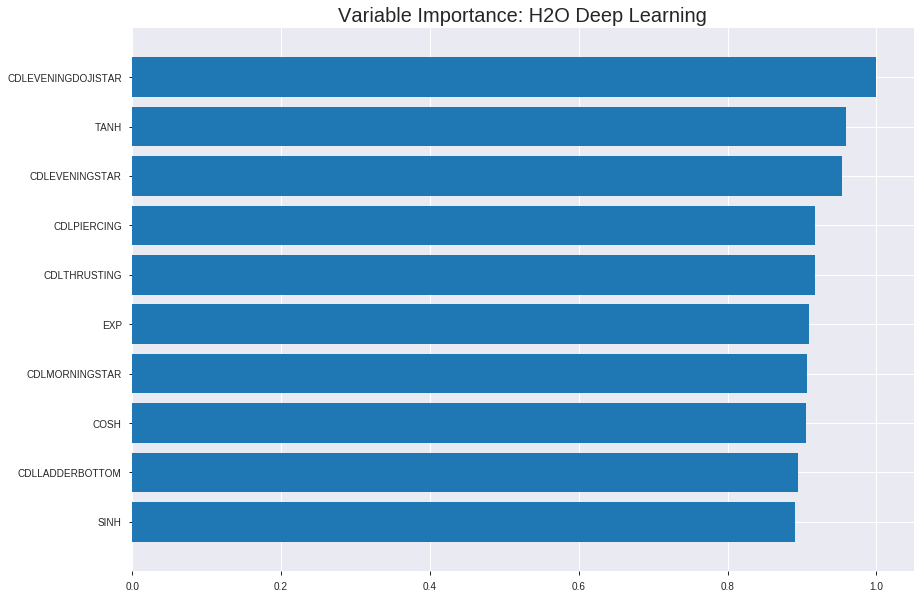

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_151010_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.238679805180037
RMSE: 0.4885486722733335
LogLoss: 0.6736700465957749
Mean Per-Class Error: 0.38121923089940146
AUC: 0.6547723184183738
pr_auc: 0.6310109361378072
Gini: 0.3095446368367476
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23707386282983534: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      163  708   0.8129   (708.0/871.0)
1      52   830   0.059    (52.0/882.0)
Total  215  1538  0.4335   (760.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.237074     0.68595   324
max f2                       0.0149833    0.836336  396
max f0point5                 0.414123     0.621444  216
max accuracy                 0.414123     0.618939  216
max precision                0.977687     1         0
max recall                   0.0149833    1         396
max specificity              0.977687     1         0
max absolute_mcc             0.332027     0.241478  269
max min_per_class_accuracy   0.425521     0.608844  208
max mean_per_class_accuracy  0.414123     0.618781  216

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 43.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.855147           1.54586   1.54586            0.777778         0.892984  0.777778                    0.892984            0.015873        0.015873                   54.5855   54.5855
    2        0.0205362                   0.82319            1.32502   1.43544            0.666667         0.834991  0.722222                    0.863988            0.0136054       0.0294785                  32.5019   43.5437
    3        0.0302339                   0.795098           1.16913   1.35002            0.588235         0.805938  0.679245                    0.845368            0.0113379       0.0408163                  16.9134   35.0019
    4        0.040502                    0.760531           1.43544   1.37167            0.722222         0.779135  0.690141                    0.828576            0.0147392       0.0555556                  43.5437   37.1674
    5        0.0501997                   0.739562           1.51987   1.4003             0.764706         0.748647  0.704545                    0.813135            0.0147392       0.0702948                  51.9875   40.0304
    6        0.100399                    0.657449           1.33255   1.36643            0.670455         0.694801  0.6875                      0.753968            0.0668934       0.137188                   33.2547   36.6426
    7        0.150029                    0.611127           1.4164    1.38296            0.712644         0.632677  0.695817                    0.713845            0.0702948       0.207483                   41.64     38.2957
    8        0.200228                    0.581975           1.10669   1.31369            0.556818         0.596478  0.660969                    0.68442             0.0555556       0.263039                   10.6692   31.3694
    9        0.300057                    0.521824           1.23795   1.28849            0.622857         0.550852  0.648289                    0.639982            0.123583        0.386621                   23.7946   28.8493
    10       0.399886                    0.471033           1.13573   1.25036            0.571429         0.495041  0.629101                    0.603798            0.113379        0.5                        13.573    25.0357
    11       0.500285                    0.42449            1.0954    1.21926            0.551136         0.447018  0.613455                    0.572335            0.109977        0.609977                   9.53991   21.9259
    12       0.600114                    0.382406           0.988086  1.1808             0.497143         0.403541  0.594106                    0.544256            0.0986395       0.708617                   -1.19145  18.0803
    13       0.699943                    0.340464           0.954014  1.14846            0.48             0.361419  0.577832                    0.518179            0.0952381       0.803855                   -4.59864  14.8458
    14       0.799772                    0.285208           0.795011  1.10434            0.4              0.31523   0.555635                    0.492847            0.0793651       0.88322                    -20.4989  10.434
    15       0.899601                    0.219323           0.726868  1.06245            0.365714         0.255129  0.534559                    0.466467            0.0725624       0.955782                   -27.3132  6.24517
    16       1                           0.000177562        0.440418  1                  0.221591         0.137022  0.503137                    0.433391          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.26538734280342763
RMSE: 0.51515759026091
LogLoss: 0.7380168379360573
Mean Per-Class Error: 0.45449764120872116
AUC: 0.5434623230906541
pr_auc: 0.5201036254145777
Gini: 0.08692464618130824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14227492905420422: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    245  0.9684   (245.0/253.0)
1      2    246  0.0081   (2.0/248.0)
Total  10   491  0.493    (247.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.142275     0.665765   389
max f2                       0.00554995   0.831099   398
max f0point5                 0.328993     0.557008   321
max accuracy                 0.528727     0.54491    175
max precision                0.852762     1          0
max recall                   0.00554995   1          398
max specificity              0.852762     1          0
max absolute_mcc             0.482796     0.0916378  212
max min_per_class_accuracy   0.509256     0.53629    189
max mean_per_class_accuracy  0.482796     0.545502   212

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.801961           1.01008   1.01008            0.5              0.820018  0.5                         0.820018            0.0120968       0.0120968                  1.00806   1.00806
    2        0.0219561                   0.777177           0.404032  0.734604           0.2              0.787869  0.363636                    0.805405            0.00403226      0.016129                   -59.5968  -26.5396
    3        0.0319361                   0.765023           0.808065  0.75756            0.4              0.770344  0.375                       0.794448            0.00806452      0.0241935                  -19.1935  -24.244
    4        0.0419162                   0.753988           1.61613   0.961982           0.8              0.75578   0.47619                     0.785242            0.016129        0.0403226                  61.6129   -3.80184
    5        0.0518962                   0.745426           2.02016   1.16548            1                0.749596  0.576923                    0.778387            0.0201613       0.0604839                  102.016   16.5478
    6        0.101796                    0.69506            1.05048   1.10911            0.52             0.716991  0.54902                     0.748291            0.0524194       0.112903                   5.04839   10.9108
    7        0.151697                    0.666161           1.2121    1.14299            0.6              0.678628  0.565789                    0.725375            0.0604839       0.173387                   21.2097   14.2986
    8        0.201597                    0.642211           1.2929    1.18009            0.64             0.653514  0.584158                    0.707588            0.0645161       0.237903                   29.2903   18.0094
    9        0.301397                    0.598745           0.727258  1.03015            0.36             0.618884  0.509934                    0.678216            0.0725806       0.310484                   -27.2742  3.01485
    10       0.401198                    0.554014           1.17169   1.06536            0.58             0.578965  0.527363                    0.653526            0.116935        0.427419                   17.1694   6.53587
    11       0.500998                    0.508731           1.09089   1.07044            0.54             0.532091  0.52988                     0.629336            0.108871        0.53629                    9.08871   7.0444
    12       0.600798                    0.459456           1.01008   1.06042            0.5              0.485211  0.524917                    0.605395            0.100806        0.637097                   1.00806   6.04169
    13       0.700599                    0.404749           0.888871  1.03598            0.44             0.431697  0.512821                    0.580652            0.0887097       0.725806                   -11.1129  3.59801
    14       0.800399                    0.347884           1.01008   1.03275            0.5              0.372096  0.511222                    0.554647            0.100806        0.826613                   1.00806   3.27508
    15       0.9002                      0.28156            0.767661  1.00336            0.38             0.313502  0.496674                    0.527913            0.0766129       0.903226                   -23.2339  0.336171
    16       1                           0.000768347        0.969677  1                  0.48             0.183922  0.49501                     0.493582       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:14:08  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 15:14:10  3 min 59.137 sec  455 obs/sec       0.513976  1             901        0.690127         4.02984             -0.905177      0.499738        0.420022           0.993764         0.496863                         0.701225           4.25362               -0.967064        0.502678          0.485679             1.34677            0.502994
    2019-08-26 15:14:25  4 min 13.993 sec  535 obs/sec       4.72105   9             8276       0.590509         2.55417             -0.394857      0.585561        0.575586           1.76669          0.496863                         0.690917           5.29173               -0.909654        0.543319          0.514519             1.01008            0.50499
    2019-08-26 15:14:39  4 min 28.392 sec  545 obs/sec       8.84769   17            15510      0.569958         1.74314             -0.299461      0.597425        0.597835           1.54586          0.496863                         0.679041           3.56688               -0.844573        0.520129          0.513472             1.34677            0.50499
    2019-08-26 15:14:54  4 min 42.852 sec  548 obs/sec       12.9766   25            22748      0.56904          1.44792             -0.295276      0.586284        0.585708           1.2146           0.496863                         0.665802           2.73702               -0.773347        0.533135          0.541015             1.34677            0.50499
    2019-08-26 15:15:10  4 min 58.470 sec  553 obs/sec       17.5916   34            30838      0.521328         0.790689            -0.0871737     0.592968        0.586481           1.54586          0.486594                         0.564631           0.910645              -0.275361        0.516806          0.505084             1.01008            0.502994
    2019-08-26 15:15:24  5 min 12.765 sec  556 obs/sec       21.7775   42            38176      0.521403         0.79758             -0.0874877     0.595613        0.593179           1.54586          0.487165                         0.58575            1.00358               -0.372547        0.545821          0.55687              2.02016            0.502994
    2019-08-26 15:15:38  5 min 26.806 sec  559 obs/sec       25.9584   50            45505      0.517799         0.785658            -0.0725069     0.595349        0.590889           1.32502          0.490588                         0.562297           0.940448              -0.26484         0.545128          0.536387             1.34677            0.502994
    2019-08-26 15:15:52  5 min 40.573 sec  563 obs/sec       30.0958   58            52758      0.525774         0.84353             -0.105799      0.608786        0.614214           1.65627          0.474044                         0.612751           1.17918               -0.502004        0.538354          0.557971             1.34677            0.499002
    2019-08-26 15:16:05  5

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLEVENINGDOJISTAR        1.0                    1.0                  0.004477510176808983
TANH                      0.9598678350448608     0.9598678350448608   0.00429781799980497
CDLEVENINGSTAR            0.9539767503738403     0.9539767503738403   0.0042714406082380325
CDLPIERCING               0.9179995059967041     0.9179995059967041   0.004110352130405861
CDLTHRUSTING              0.9176604747772217     0.9176604747772217   0.004108834114670373
---                       ---                    ---                  ---
BBANDS_lowerband_8_4_3    0.14926175773143768    0.14926175773143768  0.0006683210392509091
BBANDS_middleband_24_3_5  0.1488456428050995     0.1488456428050995   0.0006664578804335076
BBANDS_lowerband_24_0_5   0.14814937114715576    0.14814937114715576  0.000663340316999241
CDLCOUNTERATTACK          0.12804655730724335    0.12804655730724335  0.0005733297634485367
CDL3LINESTRIKE            0.12551672756671906    0.12551672756671906  0.0005620024250397452


See the whole table with table.as_data_frame()


('accuracy', 0.5896414342629482)

('F1', 0.6880000000000001)

('auc', 0.5798703774304232)

('logloss', 0.7027308806407978)

('mean_per_class_error', 0.41501461430931497)

('rmse', 0.5026769266092892)

('mse', 0.25268409254536073)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


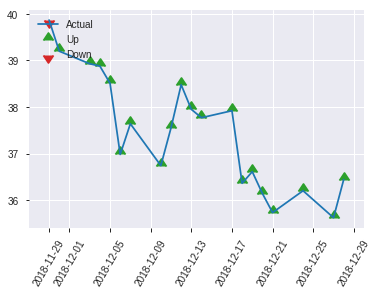


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25268409254536073
RMSE: 0.5026769266092892
LogLoss: 0.7027308806407978
Mean Per-Class Error: 0.41501461430931497
AUC: 0.5798703774304232
pr_auc: 0.5569950430909099
Gini: 0.1597407548608465
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1795581345912909: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    117  0.959    (117.0/122.0)
1      0    129  0        (0.0/129.0)
Total  5    246  0.4661   (117.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.179558     0.688     245
max f2                       0.179558     0.846457  245
max f0point5                 0.439424     0.606421  177
max accuracy                 0.461096     0.589641  167
max precision                0.776891     0.642857  13
max recall                   0.179558     1         245
max specificity              0.896169     0.991803  0
max absolute_mcc             0.439424     0.184611  177
max min_per_class_accuracy   0.559947     0.542636  124
max mean_per_class_accuracy  0.461096     0.584985  167

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 53.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.856237           0.648579  0.648579           0.333333         0.87126   0.333333                    0.87126             0.00775194      0.00775194                 -35.1421  -35.1421
    2        0.0239044                   0.81783            0.648579  0.648579           0.333333         0.830395  0.333333                    0.850828            0.00775194      0.0155039                  -35.1421  -35.1421
    3        0.0318725                   0.80499            1.94574   0.972868           1                0.810156  0.5                         0.84066             0.0155039       0.0310078                  94.5736   -2.71318
    4        0.0438247                   0.790126           1.29716   1.06131            0.666667         0.798544  0.545455                    0.829174            0.0155039       0.0465116                  29.7158   6.13108
    5        0.0517928                   0.778208           1.94574   1.19738            1                0.783219  0.615385                    0.822104            0.0155039       0.0620155                  94.5736   19.7376
    6        0.103586                    0.73192            0.898032  1.0477             0.461538         0.755062  0.538462                    0.788583            0.0465116       0.108527                   -10.1968  4.77042
    7        0.151394                    0.707963           1.29716   1.12648            0.666667         0.718757  0.578947                    0.766532            0.0620155       0.170543                   29.7158   12.6479
    8        0.203187                    0.669319           1.34705   1.1827             0.692308         0.6895    0.607843                    0.746897            0.0697674       0.24031                    34.7048   18.2703
    9        0.302789                    0.62747            1.01178   1.12648            0.52             0.647768  0.578947                    0.714288            0.100775        0.341085                   1.17829   12.6479
    10       0.40239                     0.595584           1.08961   1.11735            0.56             0.610529  0.574257                    0.688605            0.108527        0.449612                   8.96124   11.7354
    11       0.501992                    0.559178           0.933953  1.08096            0.48             0.575604  0.555556                    0.666184            0.0930233       0.542636                   -6.60465  8.09647
    12       0.601594                    0.508255           1.24527   1.10817            0.64             0.531433  0.569536                    0.643875            0.124031        0.666667                   24.5271   10.8168
    13       0.701195                    0.441746           1.08961   1.10553            0.56             0.46958   0.568182                    0.619117            0.108527        0.775194                   8.96124   10.5532
    14       0.800797                    0.400776           0.700465  1.05515            0.36             0.423723  0.542289                    0.594814            0.0697674       0.844961                   -29.9535  5.51506
    15       0.900398                    0.328804           0.933953  1.04174            0.48             0.365418  0.535398                    0.569438            0.0930233       0.937984                   -6.60465  4.17438
    16       1                           0.018776           0.622636  1                  0.32             0.234374  0.513944                    0.536065      

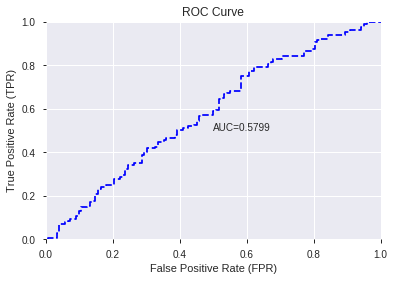

This function is available for GLM models only


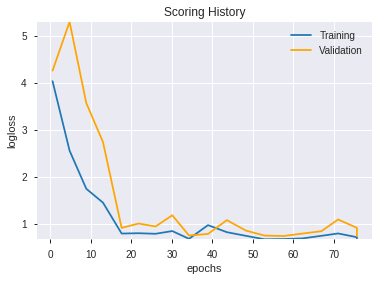

--2019-08-26 15:43:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_151010_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_151010_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_154319_model_8  0.528498  0.692935              0.475410  0.499899  0.249899
1  DeepLearning_grid_1_AutoML_20190826_154319_model_5  0.528212  0.689234              0.467213  0.498204  0.248207
2  DeepLearning_grid_1_AutoML_20190826_154319_model_6  0.527322  0.689058              0.466324  0.498228  0.248231
3  DeepLearning_grid_1_AutoML_20190826_154319_model_2  0.513915  0.954690              0.449263  0.543322  0.295199
4  DeepLearning_grid_1_AutoML_20190826_154319_model_1  0.512835  1.356413              0.478841  0.581859  0.338559
5               DeepLearning_1_AutoML_20190826_154319  0.511310  0.753682              0.479063  0.519400  0.269776
6  DeepLearning_grid_1_AutoML_20190826_154319_model_7  0.504575  0.889727              0.491581  0.567526  0.322085
7  DeepLearning_grid_1_AutoML_20190826_154319_model_3  0.494027  0.812806              0.487705  0.526805  0.277523
8  DeepLearning_grid_1_AutoML_20190826_154319_model_9  0.490024  0.692989              0.470867  0.499921  0.249921
9  DeepLearning_grid_1_AutoML_20190826_154319_model_4  0.465053  0.865292              0.479063  0.555243  0.308295

variable  relative_importance  scaled_importance  percentage
0                   day             1.000000           1.000000    0.028976
1                   COS             0.871973           0.871973    0.025266
2                   SIN             0.835500           0.835500    0.024209
3           HT_DCPERIOD             0.803670           0.803670    0.023287
4          weekday_name             0.797886           0.797886    0.023119
5                   OBV             0.795719           0.795719    0.023057
6             CORREL_12             0.788189           0.788189    0.022838
7              CORREL_8             0.753085           0.753085    0.021821
8          HT_TRENDMODE             0.747986           0.747986    0.021673
9             CORREL_30             0.736282           0.736282    0.021334
10                   AD             0.731186           0.731186    0.021187
11       CDLRICKSHAWMAN             0.729336           0.729336    0.021133
12            CORREL_14             0.726241           0.726241    0.021043
13   CDLEVENINGDOJISTAR             0.721980           0.721980    0.020920
14     CDLDRAGONFLYDOJI             0.719842           0.719842    0.020858
15            CDLTAKURI             0.718996           0.718996    0.020833
16       is_quarter_end             0.707401           0.707401    0.020498
17       CDLEVENINGSTAR             0.691807           0.691807    0.020046
18    CDLSTALLEDPATTERN             0.691741           0.691741    0.020044
19         is_month_end             0.688022           0.688022    0.019936
20      CDLUNIQUE3RIVER             0.685970           0.685970    0.019877
21          CDLPIERCING             0.683933           0.683933    0.019818
22   CDLSEPARATINGLINES             0.674304           0.674304    0.019539
23            CDLONNECK             0.673012           0.673012    0.019501
24    CDL3WHITESOLDIERS             0.672803           0.672803    0.019495
25   CDLUPSIDEGAP2CROWS             0.671756           0.671756    0.019465
26      CDLADVANCEBLOCK             0.670407           0.670407    0.019426
27       CDL3BLACKCROWS             0.668685           0.668685    0.019376
28       CDLMATCHINGLOW             0.667183           0.667183    0.019332
29                  EXP             0.663623           0.663623    0.019229
30            CDLHAMMER             0.662483           0.662483    0.019196
31       is_month_start             0.660665           0.660665    0.019143
32    CDLDARKCLOUDCOVER             0.648826           0.648826    0.018800
33      CDLLADDERBOTTOM             0.646277           0.646277    0.018726
34      CDLSHOOTINGSTAR             0.644712           0.644712    0.018681
35                 SINH             0.642802           0.642802    0.018626
36                 COSH             0.637735           0.637735    0.018479
37                 TANH             0.636480           0.636480    0.018443
38            CDLINNECK             0.635681           0.635681    0.018419
39         CDLBREAKAWAY             0.627791           0.627791    0.018191
40      CDLHOMINGPIGEON             0.627034           0.627034    0.018169
41  CDLGAPSIDESIDEWHITE             0.623625           0.623625    0.018070
42        CDLHANGINGMAN             0.622567           0.622567    0.018039
43    CDLINVERTEDHAMMER             0.622113           0.622113    0.018026
44     is_quarter_start             0.618553           0.618553    0.017923
45   CDLMORNINGDOJISTAR             0.616500           0.616500    0.017864
46    CDLGRAVESTONEDOJI             0.600151           0.600151    0.017390
47     CDLSTICKSANDWICH             0.585233           0.585233    0.016958
48       CDLMORNINGSTAR             0.583918           0.583918    0.016919
49         CDLTHRUSTING             0.579883           0.579883    0.016803

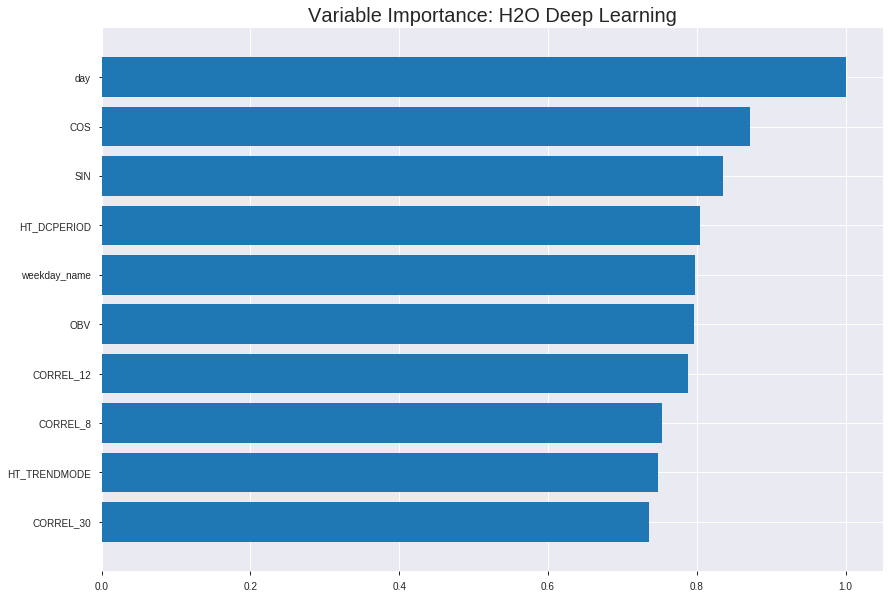

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_154319_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24855349497779963
RMSE: 0.49855139652577407
LogLoss: 0.6901753840195441
Mean Per-Class Error: 0.4588940436488411
AUC: 0.5568546592000749
pr_auc: 0.5544288113567813
Gini: 0.11370931840014986
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42685980309992166: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      28   843   0.9679   (843.0/871.0)
1      6    876   0.0068   (6.0/882.0)
Total  34   1719  0.4843   (849.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42686      0.673587  367
max f2                       0.339184     0.836495  390
max f0point5                 0.463362     0.571429  305
max accuracy                 0.475005     0.542499  220
max precision                0.49986      0.818182  8
max recall                   0.339184     1         390
max specificity              0.502276     0.998852  0
max absolute_mcc             0.463362     0.112709  305
max min_per_class_accuracy   0.483075     0.531573  151
max mean_per_class_accuracy  0.475005     0.541106  220

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 47.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.499161           1.43544   1.43544            0.722222         0.500464  0.722222                    0.500464            0.0147392       0.0147392                  43.5437   43.5437
    2        0.0205362                   0.498186           1.10418   1.26981            0.555556         0.498595  0.638889                    0.49953             0.0113379       0.0260771                  10.4182   26.981
    3        0.0302339                   0.497894           1.16913   1.23752            0.588235         0.498011  0.622642                    0.499043            0.0113379       0.037415                   16.9134   23.7518
    4        0.040502                    0.497576           1.10418   1.20371            0.555556         0.497753  0.605634                    0.498716            0.0113379       0.0487528                  10.4182   20.3714
    5        0.0501997                   0.497206           1.51987   1.26479            0.764706         0.497384  0.636364                    0.498458            0.0147392       0.0634921                  51.9875   26.4791
    6        0.123217                    0.496226           1.13351   1.187              0.570312         0.496535  0.597222                    0.497318            0.0827664       0.146259                   13.3512   18.6996
    7        0.150029                    0.495314           1.14177   1.17891            0.574468         0.495697  0.593156                    0.497029            0.0306122       0.176871                   14.1772   17.8914
    8        0.200228                    0.493595           1.10669   1.16081            0.556818         0.49442   0.584046                    0.496375            0.0555556       0.232426                   10.6692   16.0807
    9        0.300057                    0.489795           0.942656  1.08823            0.474286         0.491698  0.547529                    0.494819            0.0941043       0.326531                   -5.73437  8.82284
    10       0.399886                    0.486404           1.07894   1.08591            0.542857         0.488135  0.546362                    0.49315             0.10771         0.43424                    7.8944    8.59106
    11       0.500285                    0.483071           0.971179  1.06289            0.488636         0.48475   0.534778                    0.491464            0.0975057       0.531746                   -2.88214  6.28857
    12       0.600114                    0.479709           0.976728  1.04855            0.491429         0.481286  0.527567                    0.489771            0.0975057       0.629252                   -2.32718  4.85535
    13       0.699943                    0.475836           1.0903    1.05451            0.548571         0.477855  0.530562                    0.488072            0.108844        0.738095                   9.03013   5.45077
    14       0.799772                    0.471774           0.976728  1.0448             0.491429         0.473892  0.525678                    0.486302            0.0975057       0.835601                   -2.32718  4.47991
    15       0.899601                    0.465784           0.931299  1.0322             0.468571         0.468944  0.519341                    0.484376            0.0929705       0.928571                   -6.8701   3.2204
    16       1                           0.267572           0.711445  1                  0.357955         0.44003   0.503137                    0.479923           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2501170479239114
RMSE: 0.5001170342269011
LogLoss: 0.6933801881532867
Mean Per-Class Error: 0.4778544562029836
AUC: 0.505299311487951
pr_auc: 0.5041961527304172
Gini: 0.010598622975902083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43976209330317606: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    251  0.9921   (251.0/253.0)
1      0    248  0        (0.0/248.0)
Total  2    499  0.501    (251.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.439762     0.663989   397
max f2                       0.439762     0.831657   397
max f0point5                 0.461775     0.553768   381
max accuracy                 0.493633     0.522954   57
max precision                0.499347     1          0
max recall                   0.439762     1          397
max specificity              0.499347     1          0
max absolute_mcc             0.439762     0.0626802  397
max min_per_class_accuracy   0.48297      0.498024   180
max mean_per_class_accuracy  0.480079     0.522146   231

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 48.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.498533           1.01008   1.01008            0.5              0.498813  0.5                         0.498813            0.0120968       0.0120968                  1.00806   1.00806
    2        0.0219561                   0.498034           1.2121    1.10191            0.6              0.498219  0.545455                    0.498543            0.0120968       0.0241935                  21.2097   10.1906
    3        0.0319361                   0.497438           0.404032  0.883821           0.2              0.497677  0.4375                      0.498272            0.00403226      0.0282258                  -59.5968  -11.6179
    4        0.0419162                   0.497261           2.02016   1.15438            1                0.497335  0.571429                    0.498049            0.0201613       0.0483871                  102.016   15.4378
    5        0.0518962                   0.496971           1.2121    1.16548            0.6              0.497069  0.576923                    0.497861            0.0120968       0.0604839                  21.2097   16.5478
    6        0.101796                    0.496206           1.05048   1.10911            0.52             0.496412  0.54902                     0.497151            0.0524194       0.112903                   5.04839   10.9108
    7        0.151697                    0.494481           0.969677  1.06324            0.48             0.495138  0.526316                    0.496488            0.0483871       0.16129                    -3.03226  6.32428
    8        0.201597                    0.492835           0.888871  1.02008            0.44             0.493523  0.50495                     0.495755            0.0443548       0.205645                   -11.1129  2.00814
    9        0.301397                    0.489312           1.01008   1.01677            0.5              0.49095   0.503311                    0.494164            0.100806        0.306452                   1.00806   1.67699
    10       0.401198                    0.486014           0.888871  0.984954           0.44             0.487651  0.487562                    0.492544            0.0887097       0.395161                   -11.1129  -1.50457
    11       0.500998                    0.482963           1.05048   0.998008           0.52             0.484404  0.494024                    0.490922            0.104839        0.5                        5.04839   -0.199203
    12       0.600798                    0.480498           1.13129   1.02015            0.56             0.48179   0.504983                    0.489405            0.112903        0.612903                   13.129    2.01479
    13       0.700599                    0.477153           0.969677  1.01296            0.48             0.478946  0.501425                    0.487915            0.0967742       0.709677                   -3.03226  1.29584
    14       0.800399                    0.473              0.888871  0.997486           0.44             0.475279  0.493766                    0.48634             0.0887097       0.798387                   -11.1129  -0.251388
    15       0.9002                      0.46864            1.05048   1.00336            0.52             0.470977  0.496674                    0.484637            0.104839        0.903226                   5.04839   0.336171
    16       1                           0.415952           0.969677  1                  0.48             0.459506  0.49501                     0.482129  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:49:51  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 15:49:53  1 min 38.271 sec  577 obs/sec       0.663434  1             1163       0.535408         0.773119            -0.146694      0.534433        0.534944           1.2146           0.49344                          0.534118           0.77009               -0.141241        0.524106          0.507818             1.01008            0.500998
    2019-08-26 15:50:07  1 min 52.254 sec  894 obs/sec       7.45009   11            13060      0.498551         0.690175            0.00574687     0.556855        0.554429           1.43544          0.484313                         0.500117           0.69338               -0.000567849     0.505299          0.504196             1.01008            0.500998
    2019-08-26 15:50:21  2 min  6.352 sec  1042 obs/sec      16.2635   24            28510      0.494163         0.680188            0.0231722      0.544584        0.607823           1.54586          0.460924                         0.500207           0.694755              -0.000927067     0.521269          0.502599             1.02546            0.497006
    2019-08-26 15:50:35  2 min 19.944 sec  1138 obs/sec      25.7199   38            45087      0.493091         0.678125            0.0274067      0.533512        0.555648           1.76669          0.45522                          0.503297           0.700517              -0.0133341       0.479711          0.439341             0.336694           0.499002
    2019-08-26 15:50:49  2 min 33.759 sec  1204 obs/sec      35.7941   53            62747      0.488029         0.66587             0.047274       0.590337        0.639429           1.98753          0.452938                         0.506073           0.710707              -0.0245406       0.511196          0.506354             0.673387           0.499002
    2019-08-26 15:51:03  2 min 47.440 sec  1285 obs/sec      47.2099   70            82759      0.483906         0.656088            0.0633033      0.592978        0.652337           1.98753          0.439247                         0.505712           0.712272              -0.0230809       0.500542          0.483946             1.01008            0.500998
    2019-08-26 15:51:16  3 min  1.286 sec  1352 obs/sec      59.3542   88            104048     0.476197         0.635855            0.0929096      0.618176        0.674172           1.98753          0.435254                         0.509627           0.754728              -0.0389809       0.526489          0.526794             1.01008            0.50499
    2019-08-26 15:51:18  3 min  2.675 sec  1352 obs/sec      59.3542   88            104048     0.498551         0.690175            0.00574687     0.556855        0.554429           1.43544          0.484313                         0.500117           0.69338               -0.000567849     0.505299          0.504196             1.01008            0.500998

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
day                 1.0                    1.0                  0.02897580889444638
COS                 0.8719732165336609     0.8719732165336609   0.02526612928335507
SIN                 0.8355002999305725     0.8355002999305725   0.0242092970220409
HT_DCPERIOD         0.803670346736908      0.803670346736908    0.023286998381182106
weekday_name        0.797886073589325      0.797886073589325    0.02311939438786446
---                 ---                    ---                  ---
CDLMORNINGDOJISTAR  0.616499662399292      0.616499662399292    0.017863576401172598
CDLGRAVESTONEDOJI   0.6001509428024292     0.6001509428024292   0.01738985902646501
CDLSTICKSANDWICH    0.5852334499359131     0.5852334499359131   0.01695761260398057
CDLMORNINGSTAR      0.5839175581932068     0.5839175581932068   0.016919483576318135
CDLTHRUSTING        0.5798829793930054     0.5798829793930054   0.016802578392033914


See the whole table with table.as_data_frame()


('accuracy', 0.5378486055776892)

('F1', 0.6898395721925134)

('auc', 0.5284979031643157)

('logloss', 0.6929347657752958)

('mean_per_class_error', 0.45606176134197485)

('rmse', 0.4998994426286674)

('mse', 0.24989945274045236)

deeplearning prediction progress: |███████████████████████████████████████| 100%


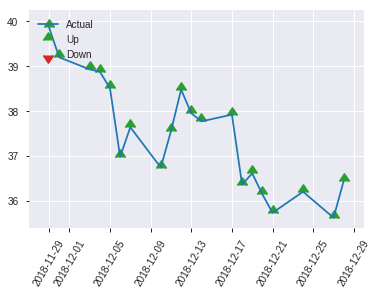


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24989945274045236
RMSE: 0.4998994426286674
LogLoss: 0.6929347657752958
Mean Per-Class Error: 0.45606176134197485
AUC: 0.5284979031643157
pr_auc: 0.56451398427031
Gini: 0.05699580632863133
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4526470525996043: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    116  0.9508   (116.0/122.0)
1      0    129  0        (0.0/129.0)
Total  6    245  0.4622   (116.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452647     0.68984   237
max f2                       0.452647     0.847569  237
max f0point5                 0.452647     0.581605  237
max accuracy                 0.48914      0.537849  63
max precision                0.501279     1         0
max recall                   0.452647     1         237
max specificity              0.501279     1         0
max absolute_mcc             0.452647     0.160919  237
max min_per_class_accuracy   0.483109     0.52459   118
max mean_per_class_accuracy  0.48914      0.543938  63

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 48.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.498224           1.94574   1.94574            1                0.49938   1                           0.49938             0.0232558       0.0232558                  94.5736   94.5736
    2        0.0239044                   0.497881           1.29716   1.62145            0.666667         0.497987  0.833333                    0.498684            0.0155039       0.0387597                  29.7158   62.1447
    3        0.0318725                   0.497557           0.972868  1.4593             0.5              0.49769   0.75                        0.498435            0.00775194      0.0465116                  -2.71318  45.9302
    4        0.0438247                   0.497335           1.29716   1.41508            0.666667         0.497425  0.727273                    0.49816             0.0155039       0.0620155                  29.7158   41.5081
    5        0.0517928                   0.497267           1.94574   1.49672            1                0.497293  0.769231                    0.498026            0.0155039       0.0775194                  94.5736   49.672
    6        0.10757                     0.496226           0.972868  1.22509            0.5              0.49654   0.62963                     0.497256            0.0542636       0.131783                   -2.71318  22.5093
    7        0.151394                    0.493986           0.707541  1.07528            0.363636         0.495147  0.552632                    0.496645            0.0310078       0.162791                   -29.2459  7.52754
    8        0.203187                    0.492018           1.0477    1.06825            0.538462         0.49302   0.54902                     0.495721            0.0542636       0.217054                   4.77042   6.82475
    9        0.302789                    0.488911           1.24527   1.12648            0.64             0.490103  0.578947                    0.493873            0.124031        0.341085                   24.5271   12.6479
    10       0.40239                     0.485935           0.778295  1.04029            0.4              0.487458  0.534653                    0.492285            0.0775194       0.418605                   -22.1705  4.02947
    11       0.501992                    0.483109           1.08961   1.05008            0.56             0.48432   0.539683                    0.490705            0.108527        0.527132                   8.96124   5.008
    12       0.601594                    0.479813           0.700465  0.992197           0.36             0.481339  0.509934                    0.489154            0.0697674       0.596899                   -29.9535  -0.780328
    13       0.701195                    0.47774            0.933953  0.983924           0.48             0.478652  0.505682                    0.487663            0.0930233       0.689922                   -6.60465  -1.60765
    14       0.800797                    0.473932           1.16744   1.00675            0.6              0.47553   0.517413                    0.486153            0.116279        0.806202                   16.7442   0.67492
    15       0.900398                    0.468099           1.08961   1.01592            0.56             0.471315  0.522124                    0.484512            0.108527        0.914729                   8.96124   1.59155
    16       1                           0.416083           0.856124  1                  0.44             0.456472  0.513944                    0.481719         

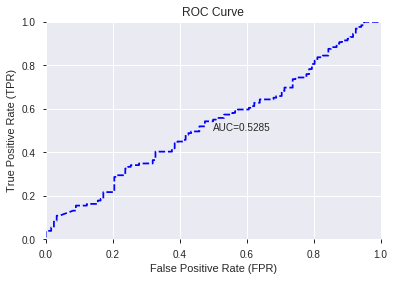

This function is available for GLM models only


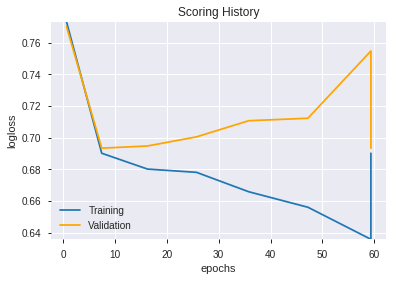

--2019-08-26 15:52:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_154319_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_154319_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['day',
 'COS',
 'SIN',
 'HT_DCPERIOD',
 'weekday_name',
 'OBV',
 'CORREL_12',
 'CORREL_8',
 'HT_TRENDMODE',
 'CORREL_30',
 'AD',
 'CDLRICKSHAWMAN',
 'CORREL_14',
 'CDLEVENINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'is_quarter_end',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'is_month_end',
 'CDLUNIQUE3RIVER',
 'CDLPIERCING',
 'CDLSEPARATINGLINES',
 'CDLONNECK',
 'CDL3WHITESOLDIERS',
 'CDLUPSIDEGAP2CROWS',
 'CDLADVANCEBLOCK',
 'CDL3BLACKCROWS',
 'CDLMATCHINGLOW',
 'EXP',
 'CDLHAMMER',
 'is_month_start',
 'CDLDARKCLOUDCOVER',
 'CDLLADDERBOTTOM',
 'CDLSHOOTINGSTAR',
 'SINH',
 'COSH',
 'TANH',
 'CDLINNECK',
 'CDLBREAKAWAY',
 'CDLHOMINGPIGEON',
 'CDLGAPSIDESIDEWHITE',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'is_quarter_start',
 'CDLMORNINGDOJISTAR',
 'CDLGRAVESTONEDOJI',
 'CDLSTICKSANDWICH',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_155302_model_1  0.53158  0.691284              0.462892  0.499067  0.249068

variable  relative_importance  scaled_importance  percentage
0    CDLSEPARATINGLINES             0.013475           1.000000    0.052009
1                   OBV             0.013002           0.964894    0.050183
2                   day             0.012055           0.894669    0.046531
3    CDLEVENINGDOJISTAR             0.009839           0.730218    0.037978
4       CDLADVANCEBLOCK             0.009715           0.720968    0.037497
5                   EXP             0.009455           0.701711    0.036496
6                  SINH             0.009439           0.700494    0.036432
7                  COSH             0.009427           0.699581    0.036385
8      is_quarter_start             0.009093           0.674816    0.035097
9                  TANH             0.009091           0.674643    0.035088
10    CDLINVERTEDHAMMER             0.008737           0.648393    0.033723
11                  SIN             0.008590           0.637510    0.033156
12         CDLTHRUSTING             0.008071           0.598983    0.031153
13       is_month_start             0.006618           0.491141    0.025544
14         is_month_end             0.006508           0.482954    0.025118
15                   AD             0.006254           0.464099    0.024137
16            CORREL_30             0.006122           0.454367    0.023631
17       CDLEVENINGSTAR             0.006009           0.445950    0.023194
18     CDLDRAGONFLYDOJI             0.005986           0.444240    0.023105
19            CDLTAKURI             0.005982           0.443980    0.023091
20      CDLUNIQUE3RIVER             0.005645           0.418959    0.021790
21   CDLUPSIDEGAP2CROWS             0.005642           0.418680    0.021775
22  CDLGAPSIDESIDEWHITE             0.005608           0.416190    0.021646
23    CDL3WHITESOLDIERS             0.005600           0.415604    0.021615
24       is_quarter_end             0.005519           0.409605    0.021303
25            CDLINNECK             0.005336           0.396031    0.020597
26       CDL3BLACKCROWS             0.005292           0.392767    0.020428
27    CDLSTALLEDPATTERN             0.005132           0.380868    0.019809
28         weekday_name             0.005103           0.378692    0.019696
29         CDLBREAKAWAY             0.005099           0.378385    0.019680
30     CDLSTICKSANDWICH             0.004842           0.359362    0.018690
31       CDLRICKSHAWMAN             0.004585           0.340260    0.017697
32      CDLLADDERBOTTOM             0.002668           0.197989    0.010297
33          CDLPIERCING             0.002602           0.193095    0.010043
34      CDLHOMINGPIGEON             0.002589           0.192107    0.009991
35      CDLSHOOTINGSTAR             0.002376           0.176323    0.009170
36    CDLGRAVESTONEDOJI             0.001815           0.134702    0.007006
37             CORREL_8             0.001751           0.129968    0.006760
38       CDLMATCHINGLOW             0.001350           0.100154    0.005209
39    CDLDARKCLOUDCOVER             0.001267           0.094019    0.004890
40            CORREL_14             0.001194           0.088637    0.004610
41            CORREL_12             0.000878           0.065157    0.003389
42        CDLHANGINGMAN             0.000829           0.061498    0.003198
43          HT_DCPERIOD             0.000641           0.047590    0.002475
44   CDLMORNINGDOJISTAR             0.000538           0.039932    0.002077
45       CDLMORNINGSTAR             0.000476           0.035360    0.001839
46         HT_TRENDMODE             0.000441           0.032704    0.001701
47            CDLHAMMER             0.000426           0.031612    0.001644
48                  COS             0.000328           0.024354    0.001267
49            CDLONNECK             0.000042           0.003097    0.000161

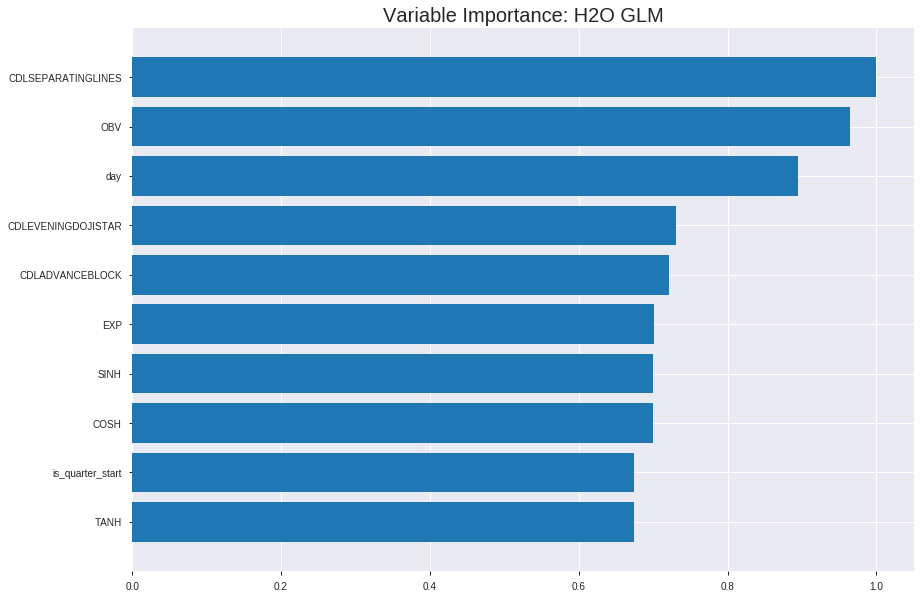

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_155302_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.247948860073792
RMSE: 0.49794463555077284
LogLoss: 0.6890270244126911
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2430.1049900608095
Residual deviance: 2415.728747590895
AIC: 2517.728747590895
AUC: 0.5720631536196568
pr_auc: 0.5769847282559428
Gini: 0.14412630723931352
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47091543180721074: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      37   834   0.9575   (834.0/871.0)
1      10   872   0.0113   (10.0/882.0)
Total  47   1706  0.4815   (844.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470915     0.673879  359
max f2                       0.444546     0.837134  382
max f0point5                 0.500943     0.572898  222
max accuracy                 0.500943     0.555619  222
max precision                0.598453     1         0
max recall                   0.427038     1         390
max specificity              0.598453     1         0
max absolute_mcc             0.500943     0.11667   222
max min_per_class_accuracy   0.504285     0.546498  184
max mean_per_class_accuracy  0.503071     0.554558  198

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 50.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0102681                   0.541777           1.65627   1.65627            0.833333         0.559305  0.833333                    0.559305            0.0170068       0.0170068                  65.6274     65.6274
    2        0.0205362                   0.532238           1.54586   1.60106            0.777778         0.535897  0.805556                    0.547601            0.015873        0.0328798                  54.5855     60.1064
    3        0.0302339                   0.528928           1.28605   1.50002            0.647059         0.530726  0.754717                    0.542188            0.0124717       0.0453515                  28.6048     50.0021
    4        0.040502                    0.524459           1.10418   1.39967            0.555556         0.526671  0.704225                    0.538254            0.0113379       0.0566893                  10.4182     39.9668
    5        0.0501997                   0.521141           1.16913   1.35513            0.588235         0.522804  0.681818                    0.535269            0.0113379       0.0680272                  16.9134     35.5133
    6        0.100399                    0.513581           1.24221   1.29867            0.625            0.516213  0.653409                    0.525741            0.0623583       0.130385                   24.2205     29.8669
    7        0.150029                    0.511032           1.05088   1.2167             0.528736         0.512208  0.612167                    0.521265            0.0521542       0.18254                    5.08771     21.67
    8        0.200228                    0.509684           1.01635   1.16647            0.511364         0.510281  0.586895                    0.518511            0.0510204       0.23356                    1.63497     16.647
    9        0.300057                    0.507571           1.0903    1.14113            0.548571         0.50858   0.574144                    0.515207            0.108844        0.342404                   9.03013     14.1128
    10       0.399886                    0.505794           1.05623   1.11993            0.531429         0.506659  0.563481                    0.513073            0.105442        0.447846                   5.62293     11.9934
    11       0.500285                    0.504282           1.01635   1.09915            0.511364         0.505009  0.553022                    0.511455            0.102041        0.549887                   1.63497     9.91462
    12       0.600114                    0.502573           0.988086  1.08067            0.497143         0.503508  0.543726                    0.510133            0.0986395       0.648526                   -1.19145    8.06713
    13       0.699943                    0.500473           0.999443  1.06909            0.502857         0.50158   0.537897                    0.508913            0.0997732       0.748299                   -0.0557175  6.90862
    14       0.799772                    0.497359           0.749582  1.02921            0.377143         0.499091  0.517832                    0.507687            0.0748299       0.823129                   -25.0418    2.92051
    15       0.899601                    0.49172            1.06759   1.03346            0.537143         0.494868  0.519975                    0.506264            0.106576        0.929705                   6.75867     3.34643
    16       1                           0.388826           0.700152  1                  0.352273         0.475119  0.503137      



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24990467560242002
RMSE: 0.49990466651394644
LogLoss: 0.6929559198627127
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 694.6159526243423
Residual deviance: 694.3418317024381
AIC: 796.3418317024381
AUC: 0.5163760678311871
pr_auc: 0.5140251911880032
Gini: 0.032752135662374116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4408016418952932: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    252  0.996    (252.0/253.0)
1      0    248  0        (0.0/248.0)
Total  1    500  0.503    (252.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.440802     0.663102   398
max f2                       0.440802     0.831099   398
max f0point5                 0.498502     0.558128   325
max accuracy                 0.51005      0.536926   84
max precision                0.571299     1          0
max recall                   0.440802     1          398
max specificity              0.571299     1          0
max absolute_mcc             0.51005      0.0878658  84
max min_per_class_accuracy   0.504373     0.504032   194
max mean_per_class_accuracy  0.509862     0.533812   86

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 50.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.54614            1.34677   1.34677            0.666667         0.559956  0.666667                    0.559956            0.016129        0.016129                   34.6774   34.6774
    2        0.0219561                   0.533041           0.808065  1.10191            0.4              0.533559  0.545455                    0.547958            0.00806452      0.0241935                  -19.1935  10.1906
    3        0.0319361                   0.530052           0.808065  1.01008            0.4              0.531449  0.5                         0.542799            0.00806452      0.0322581                  -19.1935  1.00806
    4        0.0419162                   0.524561           0.808065  0.961982           0.4              0.527385  0.47619                     0.539129            0.00806452      0.0403226                  -19.1935  -3.80184
    5        0.0518962                   0.521332           0.808065  0.932382           0.4              0.521882  0.461538                    0.535812            0.00806452      0.0483871                  -19.1935  -6.76179
    6        0.101796                    0.51286            1.05048   0.990275           0.52             0.515781  0.490196                    0.525993            0.0524194       0.100806                   5.04839   -0.972486
    7        0.151697                    0.510865           1.61613   1.19615            0.8              0.511815  0.592105                    0.521329            0.0806452       0.181452                   61.6129   19.6148
    8        0.201597                    0.509413           0.969677  1.14009            0.48             0.51011   0.564356                    0.518552            0.0483871       0.229839                   -3.03226  14.0091
    9        0.301397                    0.507464           0.808065  1.03015            0.4              0.508438  0.509934                    0.515203            0.0806452       0.310484                   -19.1935  3.01485
    10       0.401198                    0.505564           0.888871  0.995005           0.44             0.506472  0.492537                    0.513031            0.0887097       0.399194                   -11.1129  -0.499519
    11       0.500998                    0.504267           1.05048   1.00606            0.52             0.504942  0.498008                    0.51142             0.104839        0.504032                   5.04839   0.605642
    12       0.600798                    0.503082           0.929274  0.993302           0.46             0.503767  0.491694                    0.510149            0.0927419       0.596774                   -7.07258  -0.66981
    13       0.700599                    0.501856           1.01008   0.995692           0.5              0.502537  0.492877                    0.509064            0.100806        0.697581                   1.00806   -0.430797
    14       0.800399                    0.499771           1.17169   1.01764            0.58             0.500807  0.503741                    0.508035            0.116935        0.814516                   17.1694   1.76374
    15       0.9002                      0.496344           1.05048   1.02128            0.52             0.49823   0.505543                    0.506948            0.104839        0.919355                   5.04839   2.12789
    16       1                           0.437339           0.808065  1                  0.4              0.484868  0.49501                     0.50474


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 15:53:03  0.000 sec   2            3         51            1.38058           1.38595
    2019-08-26 15:53:03  0.032 sec   4            1.9       51            1.37805           1.38591
    2019-08-26 15:53:03  0.065 sec   6            1.2       51            1.37488           1.38612
    2019-08-26 15:53:03  0.097 sec   8            0.71      51            1.37124           1.3868
    2019-08-26 15:53:03  0.130 sec   10           0.44      51            1.36744           1.38827
    2019-08-26 15:53:03  0.164 sec   12           0.28      51            1.36388           1.39077
    2019-08-26 15:53:03  0.193 sec   14           0.17      51            1.36087           1.39441

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.549800796812749)

('F1', 0.6937669376693767)

('auc', 0.5315796162155293)

('logloss', 0.6912839795882136)

('mean_per_class_error', 0.45421908755877494)

('rmse', 0.49906693024252335)

('mse', 0.24906780086169567)

glm prediction progress: |████████████████████████████████████████████████| 100%


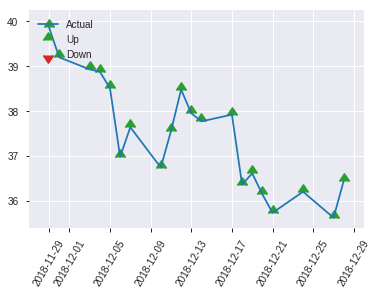


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24906780086169567
RMSE: 0.49906693024252335
LogLoss: 0.6912839795882136
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.88191742869697
Residual deviance: 347.02455775328326
AIC: 449.02455775328326
AUC: 0.5315796162155293
pr_auc: 0.5354310088227963
Gini: 0.06315923243105859
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49269832764652144: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   112  0.918    (112.0/122.0)
1      1    128  0.0078   (1.0/129.0)
Total  11   240  0.4502   (113.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492698     0.693767  239
max f2                       0.485313     0.847569  244
max f0point5                 0.492698     0.587695  239
max accuracy                 0.50196      0.549801  161
max precision                0.525896     0.75      7
max recall                   0.485313     1         244
max specificity              0.565184     0.991803  0
max absolute_mcc             0.492698     0.181203  239
max min_per_class_accuracy   0.505058     0.472868  122
max mean_per_class_accuracy  0.50196      0.545781  161

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.536291           0.648579  0.648579           0.333333         0.555626  0.333333                    0.555626            0.00775194      0.00775194                 -35.1421  -35.1421
    2        0.0239044                   0.529531           1.94574   1.29716            1                0.531568  0.666667                    0.543597            0.0232558       0.0310078                  94.5736   29.7158
    3        0.0318725                   0.524389           1.94574   1.4593             1                0.526857  0.75                        0.539412            0.0155039       0.0465116                  94.5736   45.9302
    4        0.0438247                   0.522414           0         1.06131            0                0.522684  0.545455                    0.53485             0               0.0465116                  -100      6.13108
    5        0.0517928                   0.518727           0.972868  1.0477             0.5              0.520309  0.538462                    0.532613            0.00775194      0.0542636                  -2.71318  4.77042
    6        0.103586                    0.515813           1.0477    1.0477             0.538462         0.516853  0.538462                    0.524733            0.0542636       0.108527                   4.77042   4.77042
    7        0.151394                    0.513318           1.13501   1.07528            0.583333         0.514662  0.552632                    0.521553            0.0542636       0.162791                   13.5013   7.52754
    8        0.203187                    0.511594           1.49672   1.1827             0.769231         0.512468  0.607843                    0.519237            0.0775194       0.24031                    49.672    18.2703
    9        0.302789                    0.508494           0.933953  1.10088            0.48             0.50982   0.565789                    0.516139            0.0930233       0.333333                   -6.60465  10.0877
    10       0.40239                     0.506813           0.700465  1.00177            0.36             0.507644  0.514851                    0.514036            0.0697674       0.403101                   -29.9535  0.176529
    11       0.501992                    0.504894           0.700465  0.941984           0.36             0.505739  0.484127                    0.51239             0.0697674       0.472868                   -29.9535  -5.80165
    12       0.601594                    0.502705           1.47876   1.03085            0.76             0.503529  0.529801                    0.510923            0.147287        0.620155                   47.876    3.08537
    13       0.701195                    0.501219           1.08961   1.0392             0.56             0.501968  0.534091                    0.509651            0.108527        0.728682                   8.96124   3.92001
    14       0.800797                    0.498694           1.08961   1.04547            0.56             0.499819  0.537313                    0.508428            0.108527        0.837209                   8.96124   4.54703
    15       0.900398                    0.495953           0.778295  1.01592            0.4              0.497195  0.522124                    0.507185            0.0775194       0.914729                   -22.1705  1.59155
    16       1                           0.445682           0.856124  1                  0.44             0.487045  0.513944                    0.505179      

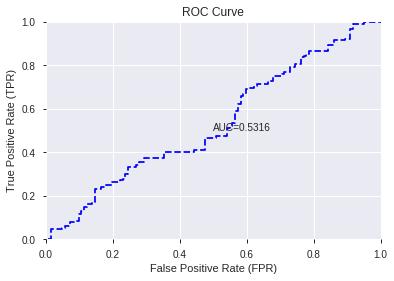

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


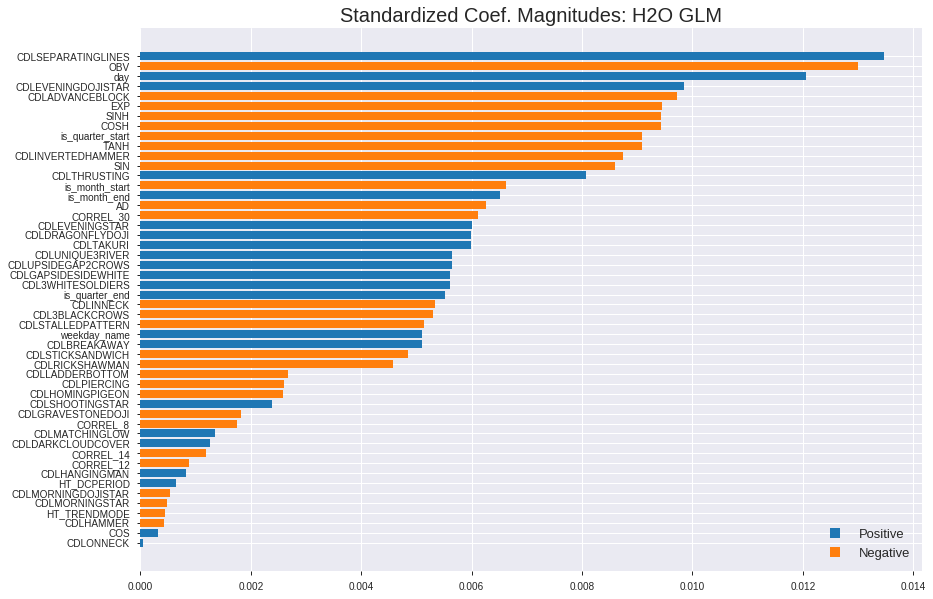

'log_likelihood'
--2019-08-26 15:53:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_155302_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_155302_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLSEPARATINGLINES',
 'OBV',
 'day',
 'CDLEVENINGDOJISTAR',
 'CDLADVANCEBLOCK',
 'EXP',
 'SINH',
 'COSH',
 'is_quarter_start',
 'TANH',
 'CDLINVERTEDHAMMER',
 'SIN',
 'CDLTHRUSTING',
 'is_month_start',
 'is_month_end',
 'AD',
 'CORREL_30',
 'CDLEVENINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLUNIQUE3RIVER',
 'CDLUPSIDEGAP2CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDL3WHITESOLDIERS',
 'is_quarter_end',
 'CDLINNECK',
 'CDL3BLACKCROWS',
 'CDLSTALLEDPATTERN',
 'weekday_name',
 'CDLBREAKAWAY',
 'CDLSTICKSANDWICH',
 'CDLRICKSHAWMAN',
 'CDLLADDERBOTTOM',
 'CDLPIERCING',
 'CDLHOMINGPIGEON',
 'CDLSHOOTINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CORREL_8',
 'CDLMATCHINGLOW',
 'CDLDARKCLOUDCOVER',
 'CORREL_14',
 'CORREL_12',
 'CDLHANGINGMAN',
 'HT_DCPERIOD',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'HT_TRENDMODE',
 'CDLHAMMER',
 'COS',
 'CDLONNECK']

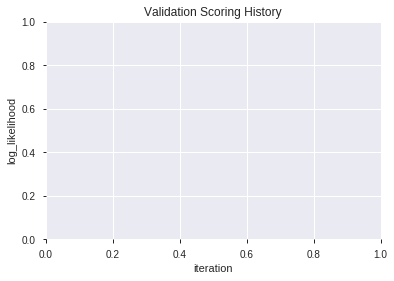

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_155312_model_6  0.519380  0.700581              0.469977  0.503540  0.253552
1  XGBoost_grid_1_AutoML_20190826_155312_model_7  0.518300  0.713607              0.470644  0.509050  0.259132
2  XGBoost_grid_1_AutoML_20190826_155312_model_5  0.513725  0.722365              0.487705  0.512999  0.263168
3  XGBoost_grid_1_AutoML_20190826_155312_model_3  0.511183  0.702488              0.483384  0.504369  0.254388
4  XGBoost_grid_1_AutoML_20190826_155312_model_4  0.488880  0.703148              0.491358  0.504907  0.254931
5  XGBoost_grid_1_AutoML_20190826_155312_model_2  0.485068  0.705632              0.479286  0.506130  0.256167
6               XGBoost_2_AutoML_20190826_155312  0.482272  0.716226              0.500000  0.510969  0.261089
7               XGBoost_1_AutoML_20190826_155312  0.481446  0.724011              0.483607  0.514160  0.264361
8               XGBoost_3_AutoML_20190826_155312  0.466387  0.715426              0.495679  0.510779  0.260896
9  XGBoost_grid_1_AutoML_20190826_155312_model_1  0.461240  0.721122              0.495679  0.513332  0.263510

variable  relative_importance  scaled_importance  percentage
0         CORREL_30           774.686523           1.000000    0.141330
1       HT_DCPERIOD           624.933472           0.806692    0.114010
2               SIN           546.010132           0.704814    0.099612
3               OBV           485.127228           0.626224    0.088504
4                AD           455.668091           0.588197    0.083130
5         CORREL_14           430.380310           0.555554    0.078517
6               COS           415.940948           0.536915    0.075882
7         CORREL_12           412.002472           0.531831    0.075164
8          CORREL_8           341.689056           0.441068    0.062336
9               day           327.743500           0.423066    0.059792
10             COSH           325.409149           0.420053    0.059366
11     weekday_name           180.252792           0.232678    0.032884
12              EXP            69.428284           0.089621    0.012666
13             SINH            21.217215           0.027388    0.003871
14     HT_TRENDMODE            20.090265           0.025933    0.003665
15     is_month_end            14.388058           0.018573    0.002625
16  CDLADVANCEBLOCK            14.373991           0.018555    0.002622
17  CDLSHOOTINGSTAR             8.869091           0.011449    0.001618
18   CDLRICKSHAWMAN             5.228150           0.006749    0.000954
19  CDLHOMINGPIGEON             4.002765           0.005167    0.000730
20     CDLTHRUSTING             3.951625           0.005101    0.000721

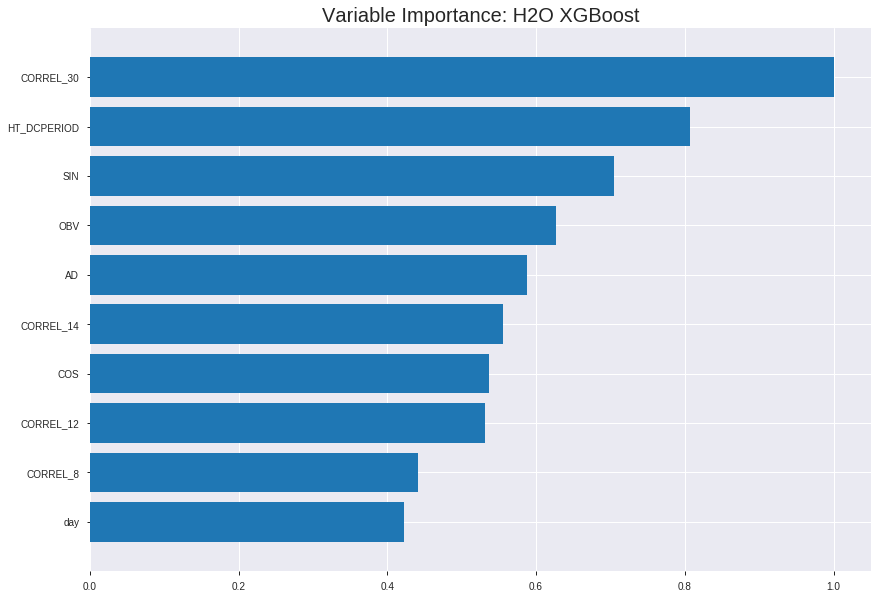

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_155312_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19858990052734235
RMSE: 0.4456342676762441
LogLoss: 0.5875780442053526
Mean Per-Class Error: 0.2166509160112572
AUC: 0.8735261421828586
pr_auc: 0.8768230841924044
Gini: 0.7470522843657172
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45590565885816303: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      540  331   0.38     (331.0/871.0)
1      73   809   0.0828   (73.0/882.0)
Total  613  1140  0.2305   (404.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455906     0.800198  261
max f2                       0.434109     0.880399  285
max f0point5                 0.529438     0.805834  177
max accuracy                 0.496382     0.783229  214
max precision                0.832327     1         0
max recall                   0.358033     1         359
max specificity              0.832327     1         0
max absolute_mcc             0.496382     0.56703   214
max min_per_class_accuracy   0.491764     0.778912  220
max mean_per_class_accuracy  0.496382     0.783349  214

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.747456           1.98753    1.98753            1                0.771592  1                           0.771592            0.0204082       0.0204082                  98.7528   98.7528
    2        0.0205362                   0.714687           1.98753    1.98753            1                0.729033  1                           0.750312            0.0204082       0.0408163                  98.7528   98.7528
    3        0.0302339                   0.696136           1.98753    1.98753            1                0.70286   1                           0.735092            0.0192744       0.0600907                  98.7528   98.7528
    4        0.040502                    0.683623           1.98753    1.98753            1                0.690334  1                           0.723745            0.0204082       0.0804989                  98.7528   98.7528
    5        0.0501997                   0.670231           1.98753    1.98753            1                0.675941  1                           0.71451             0.0192744       0.0997732                  98.7528   98.7528
    6        0.100399                    0.637147           1.91977    1.95365            0.965909         0.652717  0.982955                    0.683613            0.0963719       0.196145                   91.9772   95.365
    7        0.150029                    0.611661           1.8733     1.92707            0.942529         0.626096  0.969582                    0.664587            0.0929705       0.289116                   87.3303   92.7071
    8        0.200228                    0.588205           1.73909    1.87994            0.875            0.600052  0.945869                    0.648407            0.0873016       0.376417                   73.9087   87.9941
    9        0.300057                    0.549406           1.59002    1.78349            0.8              0.568139  0.897338                    0.621702            0.15873         0.535147                   59.0023   78.3486
    10       0.399886                    0.518541           1.30609    1.66431            0.657143         0.532942  0.837375                    0.599544            0.130385        0.665533                   30.609    66.4307
    11       0.500285                    0.491621           1.11798    1.55467            0.5625           0.504611  0.782212                    0.580492            0.112245        0.777778                   11.7985   55.4669
    12       0.600114                    0.469042           0.919942   1.44908            0.462857         0.479899  0.729087                    0.563758            0.0918367       0.869615                   -8.00583  44.9082
    13       0.699943                    0.444071           0.71551    1.34446            0.36             0.45589   0.676447                    0.548374            0.0714286       0.941043                   -28.449   34.4457
    14       0.799772                    0.417567           0.374791   1.22342            0.188571         0.430156  0.615549                    0.533618            0.037415        0.978458                   -62.5209  22.3422
    15       0.899601                    0.387802           0.159002   1.1053             0.08             0.403798  0.556119                    0.519212            0.015873        0.994331                   -84.0998  10.5303
    16       1                           0.231322           0.0564639  1                  0.0284091        0.352651  0.503137                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2532225346707652
RMSE: 0.5032122163369698
LogLoss: 0.7002613254674529
Mean Per-Class Error: 0.4479073696289685
AUC: 0.5313496111181946
pr_auc: 0.5175673902974959
Gini: 0.06269922223638913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3564857840538025: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    252  0.996    (252.0/253.0)
1      0    248  0        (0.0/248.0)
Total  1    500  0.503    (252.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356486     0.663102  398
max f2                       0.356486     0.831099  398
max f0point5                 0.356486     0.551601  398
max accuracy                 0.534316     0.552894  151
max precision                0.565943     0.590164  110
max recall                   0.356486     1         398
max specificity              0.752205     0.996047  0
max absolute_mcc             0.565943     0.107979  110
max min_per_class_accuracy   0.502288     0.532258  205
max mean_per_class_accuracy  0.521036     0.552093  177

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.726513           0.673387  0.673387           0.333333         0.737833  0.333333                    0.737833            0.00806452      0.00806452                 -32.6613  -32.6613
    2        0.0219561                   0.688799           1.2121    0.918255           0.6              0.697811  0.454545                    0.719641            0.0120968       0.0201613                  21.2097   -8.17449
    3        0.0319361                   0.676254           1.2121    1.01008            0.6              0.681522  0.5                         0.707729            0.0120968       0.0322581                  21.2097   1.00806
    4        0.0419162                   0.668876           1.2121    1.05818            0.6              0.670642  0.52381                     0.698899            0.0120968       0.0443548                  21.2097   5.81797
    5        0.0518962                   0.666334           0.404032  0.932382           0.2              0.667573  0.461538                    0.692875            0.00403226      0.0483871                  -59.5968  -6.76179
    6        0.101796                    0.633719           1.2121    1.0695             0.6              0.648012  0.529412                    0.670883            0.0604839       0.108871                   21.2097   6.94972
    7        0.151697                    0.610122           1.13129   1.08982            0.56             0.618927  0.539474                    0.653792            0.0564516       0.165323                   13.129    8.98239
    8        0.201597                    0.582692           1.2929    1.14009            0.64             0.593903  0.564356                    0.638968            0.0645161       0.229839                   29.2903   14.0091
    9        0.301397                    0.544734           1.09089   1.1238             0.54             0.561609  0.556291                    0.613353            0.108871        0.33871                    9.08871   12.3798
    10       0.401198                    0.526505           1.01008   1.09551            0.5              0.534528  0.542289                    0.593744            0.100806        0.439516                   1.00806   9.55104
    11       0.500998                    0.501959           0.929274  1.0624             0.46             0.514401  0.525896                    0.577939            0.0927419       0.532258                   -7.07258  6.23956
    12       0.600798                    0.483788           0.969677  1.04699            0.48             0.491745  0.518272                    0.563621            0.0967742       0.629032                   -3.03226  4.69939
    13       0.700599                    0.467414           0.808065  1.01296            0.4              0.476506  0.501425                    0.551211            0.0806452       0.709677                   -19.1935  1.29584
    14       0.800399                    0.446897           0.929274  1.00252            0.46             0.456638  0.496259                    0.539419            0.0927419       0.802419                   -7.07258  0.252393
    15       0.9002                      0.418918           0.808065  0.980965           0.4              0.434098  0.485588                    0.527743            0.0806452       0.883065                   -19.1935  -1.90348
    16       1                           0.345705           1.17169   1                  0.58             0.391142  0.49501                     0.51411     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:53:22  5.923 sec   0                  0.5              0.693147            0.5             0                  1                0.496863                         0.5                0.693147              0.5               0                    1                  0.50499
    2019-08-26 15:53:23  5.983 sec   5                  0.492598         0.678425            0.705661        0.71673            1.88292          0.411295                         0.499972           0.693094              0.517962          0.509117             1.01008            0.50499
    2019-08-26 15:53:23  6.021 sec   10                 0.486805         0.666979            0.744453        0.753839           1.98753          0.341129                         0.499841           0.69285               0.527572          0.528118             1.01008            0.50499
    2019-08-26 15:53:23  6.074 sec   15                 0.480489         0.65458             0.775909        0.783318           1.98753          0.319452                         0.499685           0.692563              0.532489          0.522923             1.01008            0.50499
    2019-08-26 15:53:23  6.140 sec   20                 0.474379         0.642622            0.794859        0.803031           1.98753          0.293212                         0.500535           0.694373              0.529031          0.517363             1.01008            0.502994
    2019-08-26 15:53:23  6.202 sec   25                 0.468601         0.631442            0.818002        0.820684           1.98753          0.284084                         0.50186            0.69716               0.525899          0.508212             0.673387           0.50499
    2019-08-26 15:53:23  6.256 sec   30                 0.463944         0.622441            0.830125        0.833131           1.98753          0.262978                         0.502797           0.699153              0.522241          0.50732              0.673387           0.50499
    2019-08-26 15:53:23  6.310 sec   35                 0.459072         0.613053            0.838797        0.843893           1.98753          0.271535                         0.503515           0.700675              0.518344          0.504645             0.673387           0.50499
    2019-08-26 15:53:23  6.375 sec   40                 0.453843         0.603094            0.854514        0.858407           1.98753          0.243012                         0.503966           0.701781              0.520831          0.508568             0.673387           0.50499
    2019-08-26 15:53:23  6.436 sec   45                 0.449309         0.594497            0.865245        0.868949           1.98753          0.232744                         0.503533           0.700922              0.527118          0.513038             0.673387           0.502994
    2019-08-26 15:53:23  6.496 sec   50                 0.445634         0.587578            0.873526        0.876823           1.98753          0.230462                         0.503212           0.700261              0.53135           0.517567             0.673387           0.502994

Variable Importances: 


variable         relative_importance    scaled_importance     percentage
---------------  ---------------------  --------------------  ---------------------
CORREL_30        774.6865234375         1.0                   0.1413302251651707
HT_DCPERIOD      624.9334716796875      0.8066920654649877    0.11400997125112332
SIN              546.0101318359375      0.7048142898022007    0.09961156227737489
OBV              485.1272277832031      0.6262239152303288    0.08850436694331713
AD               455.6680908203125      0.588196744146763     0.08312997829168231
---              ---                    ---                   ---
CDLADVANCEBLOCK  14.373991012573242     0.0185545902474098    0.0026223244175139072
CDLSHOOTINGSTAR  8.869091033935547      0.011448619235792198  0.0016180359344248158
CDLRICKSHAWMAN   5.228150367736816      0.006748730240637279  0.0009537995644882632
CDLHOMINGPIGEON  4.002764701843262      0.005166947637196371  0.0007302458729816098
CDLTHRUSTING     3.951624870300293      0.005100934056224229  0.0007209161587188577


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6814404432132963)

('auc', 0.5193798449612403)

('logloss', 0.7005813618791227)

('mean_per_class_error', 0.442019316304486)

('rmse', 0.5035395222501512)

('mse', 0.2535520504679105)

xgboost prediction progress: |████████████████████████████████████████████| 100%


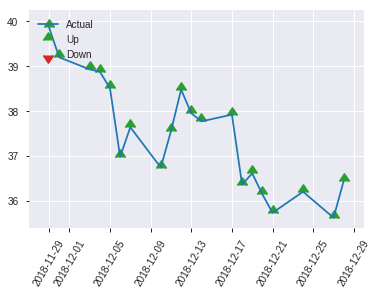


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2535520504679105
RMSE: 0.5035395222501512
LogLoss: 0.7005813618791227
Mean Per-Class Error: 0.442019316304486
AUC: 0.5193798449612403
pr_auc: 0.5301007627255073
Gini: 0.03875968992248069
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40152204036712646: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   109  0.8934   (109.0/122.0)
1      6    123  0.0465   (6.0/129.0)
Total  19   232  0.4582   (115.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401522     0.68144   231
max f2                       0.32274      0.842037  249
max f0point5                 0.401522     0.581835  231
max accuracy                 0.507405     0.557769  123
max precision                0.726103     1         0
max recall                   0.32274      1         249
max specificity              0.726103     1         0
max absolute_mcc             0.507405     0.115925  123
max min_per_class_accuracy   0.507405     0.550388  123
max mean_per_class_accuracy  0.507405     0.557981  123

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 51.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.716881           1.94574   1.94574            1                0.722287  1                           0.722287            0.0232558       0.0232558                  94.5736   94.5736
    2        0.0239044                   0.70688            1.29716   1.62145            0.666667         0.711256  0.833333                    0.716772            0.0155039       0.0387597                  29.7158   62.1447
    3        0.0318725                   0.68608            0         1.21609            0                0.693735  0.625                       0.711012            0               0.0387597                  -100      21.6085
    4        0.0438247                   0.679443           0.648579  1.06131            0.333333         0.681303  0.545455                    0.70291             0.00775194      0.0465116                  -35.1421  6.13108
    5        0.0517928                   0.665917           0.972868  1.0477             0.5              0.668386  0.538462                    0.697599            0.00775194      0.0542636                  -2.71318  4.77042
    6        0.103586                    0.626861           1.0477    1.0477             0.538462         0.641471  0.538462                    0.669535            0.0542636       0.108527                   4.77042   4.77042
    7        0.151394                    0.59959            0.810724  0.972868           0.416667         0.611188  0.5                         0.651109            0.0387597       0.147287                   -18.9276  -2.71318
    8        0.203187                    0.577707           0.598688  0.877489           0.307692         0.587133  0.45098                     0.634802            0.0310078       0.178295                   -40.1312  -12.2511
    9        0.302789                    0.554686           1.24527   0.99847            0.64             0.565658  0.513158                    0.612057            0.124031        0.302326                   24.5271   -0.152999
    10       0.40239                     0.521927           1.08961   1.02103            0.56             0.537966  0.524752                    0.593718            0.108527        0.410853                   8.96124   2.103
    11       0.501992                    0.505594           1.40093   1.09641            0.72             0.514453  0.563492                    0.577991            0.139535        0.550388                   40.093    9.6407
    12       0.601594                    0.484565           0.778295  1.04374            0.4              0.493343  0.536424                    0.563976            0.0775194       0.627907                   -22.1705  4.37394
    13       0.701195                    0.463192           0.778295  1.00603            0.4              0.473452  0.517045                    0.551118            0.0775194       0.705426                   -22.1705  0.603418
    14       0.800797                    0.441149           0.933953  0.997069           0.48             0.449747  0.512438                    0.538509            0.0930233       0.79845                    -6.60465  -0.293108
    15       0.900398                    0.418476           1.24527   1.02452            0.64             0.432042  0.526549                    0.526732            0.124031        0.922481                   24.5271   2.45249
    16       1                           0.322629           0.778295  1                  0.4              0.380534  0.513944                    0.51217      

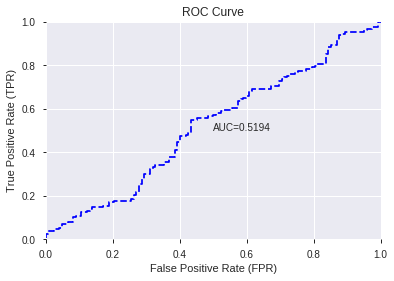

This function is available for GLM models only


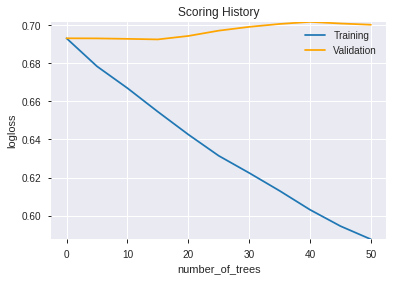

--2019-08-26 15:53:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_155312_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_155312_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CORREL_30',
 'HT_DCPERIOD',
 'SIN',
 'OBV',
 'AD',
 'CORREL_14',
 'COS',
 'CORREL_12',
 'CORREL_8',
 'day',
 'COSH',
 'weekday_name',
 'EXP',
 'SINH',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'CDLSHOOTINGSTAR',
 'CDLRICKSHAWMAN',
 'CDLHOMINGPIGEON',
 'CDLTHRUSTING']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_155334_model_1  0.501716  0.697137              0.495902  0.501987  0.251991

variable  relative_importance  scaled_importance    percentage
0           CDLSEPARATINGLINES         1.193185e-02       1.000000e+00  1.257163e-02
1                          day         1.065493e-02       8.929825e-01  1.122624e-02
2          CDLXSIDEGAP3METHODS         1.050920e-02       8.807686e-01  1.107269e-02
3           CDLCLOSINGMARUBOZU         9.245710e-03       7.748767e-01  9.741460e-03
4              CDLADVANCEBLOCK         9.067737e-03       7.599609e-01  9.553945e-03
...                        ...                  ...                ...           ...
1038   BBANDS_upperband_20_0_5         3.081055e-07       2.582212e-05  3.246260e-07
1039   BBANDS_lowerband_30_7_2         2.894001e-07       2.425443e-05  3.049176e-07
1040  BBANDS_middleband_24_3_4         1.610715e-07       1.349929e-05  1.697081e-07
1041                      mama         6.010166e-08       5.037079e-06  6.332428e-08
1042   BBANDS_middleband_8_2_4         5.092204e-09       4.267742e-07  5.365246e-09

[1043 rows x 4 columns]

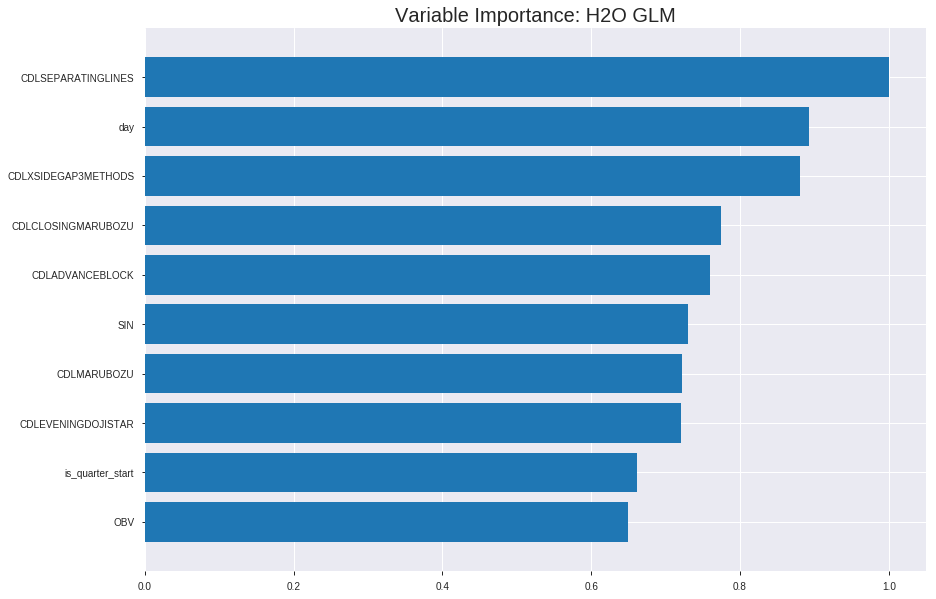

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_155334_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24534016393917765
RMSE: 0.49531824511033073
LogLoss: 0.6837823297094041
Null degrees of freedom: 1752
Residual degrees of freedom: 709
Null deviance: 2430.1049900608095
Residual deviance: 2397.3408479611703
AIC: 4485.34084796117
AUC: 0.5996300548539355
pr_auc: 0.5945025498978221
Gini: 0.199260109707871
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4303563266878682: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      40   831   0.9541   (831.0/871.0)
1      13   869   0.0147   (13.0/882.0)
Total  53   1700  0.4815   (844.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430356     0.673122  365
max f2                       0.393775     0.836177  392
max f0point5                 0.490831     0.58753   237
max accuracy                 0.490831     0.572732  237
max precision                0.607857     1         0
max recall                   0.393775     1         392
max specificity              0.607857     1         0
max absolute_mcc             0.490831     0.156922  237
max min_per_class_accuracy   0.50705      0.569161  178
max mean_per_class_accuracy  0.50622      0.571528  182

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 50.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.568197           1.54586   1.54586            0.777778         0.58268   0.777778                    0.58268             0.015873        0.015873                   54.5855   54.5855
    2        0.0205362                   0.560314           1.43544   1.49065            0.722222         0.563397  0.75                        0.573038            0.0147392       0.0306122                  43.5437   49.0646
    3        0.0302339                   0.556217           0.935307  1.31252            0.470588         0.557693  0.660377                    0.568116            0.00907029      0.0396825                  -6.46925  31.2519
    4        0.040502                    0.551984           1.76669   1.42766            0.888889         0.554172  0.71831                     0.564581            0.0181406       0.0578231                  76.6692   42.7661
    5        0.0501997                   0.548849           1.40296   1.42289            0.705882         0.550404  0.715909                    0.561842            0.0136054       0.0714286                  40.2961   42.289
    6        0.100399                    0.537984           1.30996   1.36643            0.659091         0.542301  0.6875                      0.552072            0.0657596       0.137188                   30.9962   36.6426
    7        0.150029                    0.532347           1.1651    1.29983            0.586207         0.534787  0.653992                    0.546354            0.0578231       0.195011                   16.5103   29.9828
    8        0.200228                    0.528128           1.26479   1.29104            0.636364         0.530259  0.649573                    0.542319            0.0634921       0.258503                   26.4791   29.1044
    9        0.300057                    0.521024           0.954014  1.17891            0.48             0.524334  0.593156                    0.536335            0.0952381       0.353741                   -4.59864  17.8914
    10       0.399886                    0.514243           1.07894   1.15396            0.542857         0.517719  0.580599                    0.531688            0.10771         0.461451                   7.8944    15.3957
    11       0.500285                    0.506987           1.07281   1.13767            0.539773         0.51055   0.572406                    0.527446            0.10771         0.569161                   7.28136   13.7673
    12       0.600114                    0.499502           0.965371  1.10901            0.485714         0.503217  0.557985                    0.523415            0.0963719       0.665533                   -3.46291  10.9011
    13       0.699943                    0.491519           1.04487   1.09986            0.525714         0.495681  0.553382                    0.51946             0.104308        0.769841                   4.4872    9.98629
    14       0.799772                    0.479709           0.829083  1.06606            0.417143         0.485528  0.536377                    0.515224            0.0827664       0.852608                   -17.0917  6.60637
    15       0.899601                    0.462766           0.71551   1.02716            0.36             0.47239   0.516804                    0.510471            0.0714286       0.924036                   -28.449   2.71627
    16       1                           0.372296           0.756616  1                  0.380682         0.437428  0.503137                    0.503137          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24978489928889241
RMSE: 0.4997848530006611
LogLoss: 0.6927243532940243
Null degrees of freedom: 500
Residual degrees of freedom: -543
Null deviance: 694.6159526243423
Residual deviance: 694.1098020006123
AIC: 2782.109802000612
AUC: 0.5218028815504272
pr_auc: 0.5275812392304237
Gini: 0.0436057631008544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40793251158321303: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    253  1        (253.0/253.0)
1      0    248  0        (0.0/248.0)
Total  0    501  0.505    (253.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407933     0.662216  399
max f2                       0.407933     0.830543  399
max f0point5                 0.444853     0.553241  378
max accuracy                 0.481929     0.53493   194
max precision                0.54756      1         0
max recall                   0.407933     1         399
max specificity              0.54756      1         0
max absolute_mcc             0.520609     0.101095  16
max min_per_class_accuracy   0.480905     0.524194  201
max mean_per_class_accuracy  0.476952     0.535302  217

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 48.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.52694            1.34677   1.34677            0.666667         0.535601  0.666667                    0.535601            0.016129        0.016129                   34.6774   34.6774
    2        0.0219561                   0.523467           1.61613   1.46921            0.8              0.525     0.727273                    0.530782            0.016129        0.0322581                  61.6129   46.9208
    3        0.0319361                   0.521127           1.61613   1.51512            0.8              0.521999  0.75                        0.528037            0.016129        0.0483871                  61.6129   51.5121
    4        0.0419162                   0.518364           0.808065  1.34677            0.4              0.518923  0.666667                    0.525867            0.00806452      0.0564516                  -19.1935  34.6774
    5        0.0518962                   0.514578           1.2121    1.32087            0.6              0.515444  0.653846                    0.523863            0.0120968       0.0685484                  21.2097   32.0875
    6        0.101796                    0.509283           0.969677  1.14872            0.48             0.51154   0.568627                    0.517822            0.0483871       0.116935                   -3.03226  14.8719
    7        0.151697                    0.505774           0.888871  1.06324            0.44             0.5075    0.526316                    0.514427            0.0443548       0.16129                    -11.1129  6.32428
    8        0.201597                    0.501323           1.2121    1.10009            0.6              0.503508  0.544554                    0.511724            0.0604839       0.221774                   21.2097   10.0088
    9        0.301397                    0.494147           1.01008   1.07028            0.5              0.497309  0.529801                    0.506951            0.100806        0.322581                   1.00806   7.02841
    10       0.401198                    0.48671            1.05048   1.06536            0.52             0.490556  0.527363                    0.502873            0.104839        0.427419                   5.04839   6.53587
    11       0.500998                    0.480475           0.969677  1.0463             0.48             0.483715  0.517928                    0.499056            0.0967742       0.524194                   -3.03226  4.62987
    12       0.600798                    0.472967           0.929274  1.02686            0.46             0.476128  0.508306                    0.495248            0.0927419       0.616935                   -7.07258  2.68594
    13       0.700599                    0.467272           0.686855  0.978426           0.34             0.470175  0.48433                     0.491676            0.0685484       0.685484                   -31.3145  -2.15743
    14       0.800399                    0.460989           1.09089   0.992448           0.54             0.463982  0.491272                    0.488223            0.108871        0.794355                   9.08871   -0.755169
    15       0.9002                      0.451879           1.01008   0.994403           0.5              0.457067  0.492239                    0.484769            0.100806        0.895161                   1.00806   -0.559688
    16       1                           0.407933           1.05048   1                  0.52             0.440311  0.49501                     0.480332    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 15:53:38  0.000 sec   2            3         1044          1.37103           1.38556
    2019-08-26 15:53:40  2.052 sec   4            2.2       1044          1.36756           1.38545
    2019-08-26 15:53:42  4.035 sec   6            1.6       1044          1.36346           1.38546
    2019-08-26 15:53:44  6.045 sec   8            1.2       1044          1.35866           1.38575
    2019-08-26 15:53:46  8.099 sec   10           0.84      1044          1.3532            1.38648
    2019-08-26 15:53:48  10.077 sec  12           0.61      1044          1.34716           1.38792
    2019-08-26 15:53:50  12.090 sec  14           0.44      1044          1.34068           1.39031

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5338645418326693)

('F1', 0.6807387862796834)

('auc', 0.5017155928326344)

('logloss', 0.6971372808700412)

('mean_per_class_error', 0.4719468801626636)

('rmse', 0.5019867262068692)

('mse', 0.2519906732878903)

glm prediction progress: |████████████████████████████████████████████████| 100%


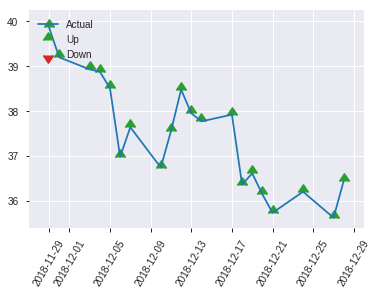


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2519906732878903
RMSE: 0.5019867262068692
LogLoss: 0.6971372808700412
Null degrees of freedom: 250
Residual degrees of freedom: -793
Null deviance: 347.88191742869697
Residual deviance: 349.9629149967607
AIC: 2437.9629149967604
AUC: 0.5017155928326344
pr_auc: 0.5104144714889269
Gini: 0.003431185665268899
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4249403231266746: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    121  0.9918   (121.0/122.0)
1      0    129  0        (0.0/129.0)
Total  1    250  0.4821   (121.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42494      0.680739  249
max f2                       0.42494      0.842037  249
max f0point5                 0.441871     0.575673  236
max accuracy                 0.461268     0.533865  177
max precision                0.497827     0.608696  22
max recall                   0.42494      1         249
max specificity              0.541429     0.991803  0
max absolute_mcc             0.477193     0.112178  96
max min_per_class_accuracy   0.4702       0.47541   125
max mean_per_class_accuracy  0.461268     0.528053  177

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 47.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.511697           0.648579  0.648579           0.333333         0.527727  0.333333                    0.527727            0.00775194      0.00775194                 -35.1421  -35.1421
    2        0.0239044                   0.509697           0.648579  0.648579           0.333333         0.510377  0.333333                    0.519052            0.00775194      0.0155039                  -35.1421  -35.1421
    3        0.0318725                   0.507206           0.972868  0.729651           0.5              0.508509  0.375                       0.516416            0.00775194      0.0232558                  -2.71318  -27.0349
    4        0.0438247                   0.502011           0.648579  0.707541           0.333333         0.503523  0.363636                    0.5129              0.00775194      0.0310078                  -35.1421  -29.2459
    5        0.0517928                   0.501081           0.972868  0.74836            0.5              0.501509  0.384615                    0.511148            0.00775194      0.0387597                  -2.71318  -25.164
    6        0.103586                    0.497471           1.34705   1.0477             0.692308         0.499058  0.538462                    0.505103            0.0697674       0.108527                   34.7048   4.77042
    7        0.151394                    0.49385            1.29716   1.12648            0.666667         0.495985  0.578947                    0.502223            0.0620155       0.170543                   29.7158   12.6479
    8        0.203187                    0.490465           1.0477    1.1064             0.538462         0.491473  0.568627                    0.499483            0.0542636       0.224806                   4.77042   10.6399
    9        0.302789                    0.481926           0.778295  0.99847            0.4              0.486024  0.513158                    0.495056            0.0775194       0.302326                   -22.1705  -0.152999
    10       0.40239                     0.475957           0.544806  0.886177           0.28             0.478881  0.455446                    0.491052            0.0542636       0.356589                   -45.5194  -11.3823
    11       0.501992                    0.4702             1.24527   0.957426           0.64             0.472767  0.492063                    0.487424            0.124031        0.48062                    24.5271   -4.25741
    12       0.601594                    0.466469           1.3231    1.01797            0.68             0.468563  0.523179                    0.484301            0.131783        0.612403                   32.3101   1.79681
    13       0.701195                    0.461576           1.08961   1.02814            0.56             0.463929  0.528409                    0.481408            0.108527        0.72093                    8.96124   2.81448
    14       0.800797                    0.455489           0.933953  1.01643            0.48             0.458175  0.522388                    0.478518            0.0930233       0.813953                   -6.60465  1.64295
    15       0.900398                    0.447106           0.856124  0.998697           0.44             0.452041  0.513274                    0.475589            0.0852713       0.899225                   -14.3876  -0.130342
    16       1                           0.411536           1.01178   1                  0.52             0.438644  0.513944                    0.47190

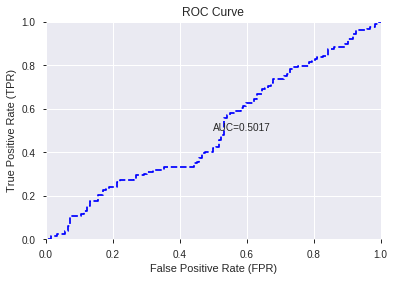

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


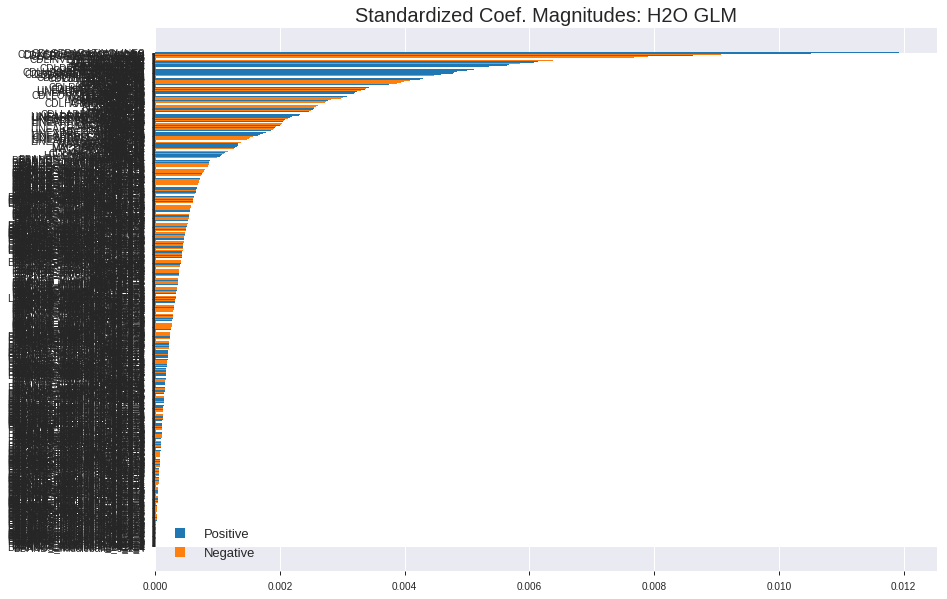

'log_likelihood'
--2019-08-26 15:54:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.80
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.80|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_155334_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_155334_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

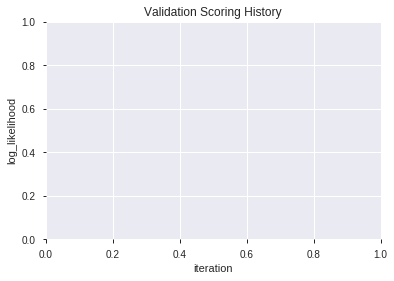

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_155415_model_3  0.498475  0.708491              0.491803  0.507406  0.257461
1  XGBoost_grid_1_AutoML_20190826_155415_model_4  0.496696  0.699949              0.474965  0.503364  0.253376
2  XGBoost_grid_1_AutoML_20190826_155415_model_6  0.495870  0.708638              0.483607  0.507517  0.257574
3  XGBoost_grid_1_AutoML_20190826_155415_model_1  0.495647  0.709019              0.500000  0.507596  0.257653
4               XGBoost_3_AutoML_20190826_155415  0.492756  0.706675              0.500000  0.506496  0.256538
5  XGBoost_grid_1_AutoML_20190826_155415_model_5  0.487038  0.735853              0.491803  0.519191  0.269559
6  XGBoost_grid_1_AutoML_20190826_155415_model_7  0.470200  0.728231              0.483607  0.516689  0.266968
7  XGBoost_grid_1_AutoML_20190826_155415_model_2  0.467849  0.712638              0.500000  0.509423  0.259511
8               XGBoost_1_AutoML_20190826_155415  0.458190  0.735827              0.487705  0.519880  0.270275
9               XGBoost_2_AutoML_20190826_155415  0.440590  0.743399              0.500000  0.523405  0.273953

variable  relative_importance  scaled_importance  percentage
0                     MFI_24            89.333817           1.000000    0.015653
1                    BETA_20            88.172203           0.986997    0.015449
2                HT_DCPERIOD            78.053696           0.873731    0.013676
3             STOCHRSI_fastd            76.472076           0.856026    0.013399
4       HT_PHASOR_quadrature            76.457558           0.855864    0.013397
..                       ...                  ...                ...         ...
298  BBANDS_upperband_24_7_3             1.579975           0.017686    0.000277
299  BBANDS_lowerband_12_6_5             1.558894           0.017450    0.000273
300  BBANDS_lowerband_12_1_4             1.076355           0.012049    0.000189
301  BBANDS_lowerband_20_1_4             0.984054           0.011015    0.000172
302               aroonup_24             0.204193           0.002286    0.000036

[303 rows x 4 columns]

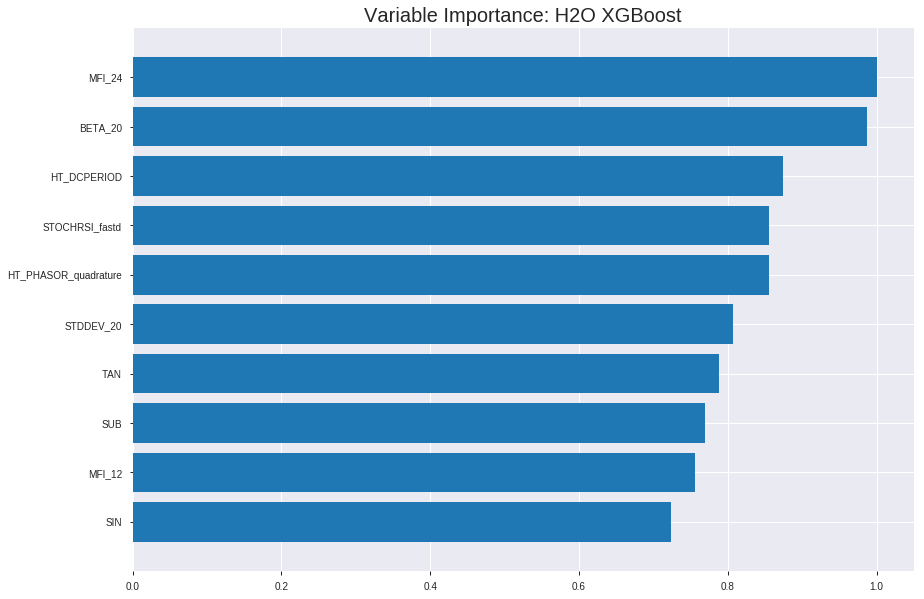

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_155415_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1773902277738218
RMSE: 0.4211771928462198
LogLoss: 0.543103897198243
Mean Per-Class Error: 0.14209434252078168
AUC: 0.9376371673813039
pr_auc: 0.9366679764943042
Gini: 0.8752743347626077
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48976338903109234: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      717  154  0.1768   (154.0/871.0)
1      95   787  0.1077   (95.0/882.0)
Total  812  941  0.142    (249.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489763     0.863412  220
max f2                       0.442272     0.916631  263
max f0point5                 0.527139     0.875837  184
max accuracy                 0.498822     0.857958  210
max precision                0.84003      1         0
max recall                   0.335857     1         352
max specificity              0.84003      1         0
max absolute_mcc             0.489763     0.717413  220
max min_per_class_accuracy   0.501705     0.853741  207
max mean_per_class_accuracy  0.498822     0.857906  210

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 50.29 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.769126           1.98753    1.98753            1                0.800604  1                           0.800604            0.0204082       0.0204082                  98.7528   98.7528
    2        0.0205362                   0.74303            1.98753    1.98753            1                0.753215  1                           0.776909            0.0204082       0.0408163                  98.7528   98.7528
    3        0.0302339                   0.72523            1.98753    1.98753            1                0.732418  1                           0.762638            0.0192744       0.0600907                  98.7528   98.7528
    4        0.040502                    0.716167           1.98753    1.98753            1                0.720724  1                           0.752012            0.0204082       0.0804989                  98.7528   98.7528
    5        0.0501997                   0.704649           1.98753    1.98753            1                0.709837  1                           0.743865            0.0192744       0.0997732                  98.7528   98.7528
    6        0.100399                    0.657498           1.96494    1.97624            0.988636         0.678197  0.994318                    0.711031            0.0986395       0.198413                   96.4943   97.6236
    7        0.150029                    0.631576           1.94184    1.96486            0.977011         0.644831  0.988593                    0.689132            0.0963719       0.294785                   94.1838   96.4857
    8        0.200228                    0.606158           1.89719    1.94789            0.954545         0.617463  0.980057                    0.671164            0.0952381       0.390023                   89.7186   94.7891
    9        0.300057                    0.569381           1.80581    1.90062            0.908571         0.586202  0.956274                    0.642897            0.180272        0.570295                   80.5811   90.0621
    10       0.399886                    0.538081           1.55595    1.81458            0.782857         0.553933  0.912981                    0.620688            0.155329        0.725624                   55.5951   81.4577
    11       0.500285                    0.501162           1.27608    1.70651            0.642045         0.519571  0.858609                    0.600395            0.128118        0.853741                   27.6084   70.651
    12       0.600114                    0.467948           0.863155   1.56622            0.434286         0.484283  0.788023                    0.58108             0.0861678       0.939909                   -13.6845  56.6218
    13       0.699943                    0.429852           0.42022    1.40277            0.211429         0.449484  0.705786                    0.562311            0.0419501       0.981859                   -57.978   40.2771
    14       0.799772                    0.392726           0.12493    1.24327            0.0628571        0.410739  0.625535                    0.543392            0.0124717       0.994331                   -87.507   24.3268
    15       0.899601                    0.3496             0.0340719  1.10908            0.0171429        0.371253  0.558022                    0.524289            0.00340136      0.997732                   -96.5928  10.9084
    16       1                           0.200737           0.0225855  1                  0.0113636        0.311594  0.503137                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2513367321965244
RMSE: 0.5013349501047423
LogLoss: 0.6962752013456563
Mean Per-Class Error: 0.45353340558459776
AUC: 0.5418765140889965
pr_auc: 0.540239292884873
Gini: 0.08375302817799302
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2556598484516144: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    252  0.996    (252.0/253.0)
1      0    248  0        (0.0/248.0)
Total  1    500  0.503    (252.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25566      0.663102  398
max f2                       0.25566      0.831099  398
max f0point5                 0.387577     0.558176  324
max accuracy                 0.526796     0.548902  107
max precision                0.700237     1         0
max recall                   0.25566      1         398
max specificity              0.700237     1         0
max absolute_mcc             0.526796     0.106536  107
max min_per_class_accuracy   0.474439     0.524194  194
max mean_per_class_accuracy  0.526796     0.546467  107

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 47.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.671688           1.34677   1.34677            0.666667         0.688145  0.666667                    0.688145            0.016129        0.016129                   34.6774   34.6774
    2        0.0219561                   0.655607           1.2121    1.28556            0.6              0.66253   0.636364                    0.676502            0.0120968       0.0282258                  21.2097   28.5557
    3        0.0319361                   0.62699            1.61613   1.38886            0.8              0.628845  0.6875                      0.661609            0.016129        0.0443548                  61.6129   38.8861
    4        0.0419162                   0.614535           0.808065  1.25058            0.4              0.619124  0.619048                    0.651494            0.00806452      0.0524194                  -19.1935  25.0576
    5        0.0518962                   0.609349           1.2121    1.24318            0.6              0.611195  0.615385                    0.643744            0.0120968       0.0645161                  21.2097   24.3176
    6        0.101796                    0.566673           1.13129   1.18833            0.56             0.587665  0.588235                    0.616254            0.0564516       0.120968                   13.129    18.833
    7        0.151697                    0.547799           1.05048   1.14299            0.52             0.55823   0.565789                    0.597167            0.0524194       0.173387                   5.04839   14.2986
    8        0.201597                    0.535983           1.2929    1.18009            0.64             0.542306  0.584158                    0.583588            0.0645161       0.237903                   29.2903   18.0094
    9        0.301397                    0.511568           1.05048   1.13718            0.52             0.525787  0.562914                    0.564448            0.104839        0.342742                   5.04839   13.7177
    10       0.401198                    0.491932           0.848468  1.06536            0.42             0.502768  0.527363                    0.549105            0.0846774       0.427419                   -15.1532  6.53587
    11       0.500998                    0.474194           0.969677  1.0463             0.48             0.481997  0.517928                    0.535737            0.0967742       0.524194                   -3.03226  4.62987
    12       0.600798                    0.453351           0.969677  1.03357            0.48             0.463431  0.511628                    0.523726            0.0967742       0.620968                   -3.03226  3.35709
    13       0.700599                    0.427236           1.17169   1.05325            0.58             0.439625  0.521368                    0.511746            0.116935        0.737903                   17.1694   5.32465
    14       0.800399                    0.398623           0.727258  1.0126             0.36             0.412418  0.501247                    0.499361            0.0725806       0.810484                   -27.2742  1.25995
    15       0.9002                      0.363078           1.01008   1.01232            0.5              0.380943  0.501109                    0.486232            0.100806        0.91129                    1.00806   1.23203
    16       1                           0.244106           0.888871  1                  0.44             0.327793  0.49501                     0.47042           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:54:35  6.219 sec   0                  0.5              0.693147            0.5             0                  1                0.496863                         0.5                0.693147              0.5               0                    1                  0.50499
    2019-08-26 15:54:36  6.928 sec   5                  0.492302         0.677839            0.720744        0.732661           1.98753          0.40445                          0.500519           0.694188              0.497083          0.487539             1.01008            0.502994
    2019-08-26 15:54:36  7.262 sec   10                 0.481782         0.657205            0.810225        0.812034           1.98753          0.269823                         0.502062           0.697303              0.479982          0.476353             0.673387           0.50499
    2019-08-26 15:54:37  7.588 sec   15                 0.473162         0.640485            0.843819        0.845532           1.98753          0.256132                         0.501378           0.695965              0.512774          0.503045             0.673387           0.50499
    2019-08-26 15:54:37  7.912 sec   20                 0.464267         0.623412            0.867212        0.863366           1.98753          0.220194                         0.499889           0.693012              0.542379          0.519055             0.336694           0.500998
    2019-08-26 15:54:37  8.253 sec   25                 0.455735         0.607197            0.88381         0.882883           1.98753          0.200228                         0.498614           0.690438              0.551591          0.543279             1.34677            0.50499
    2019-08-26 15:54:38  8.603 sec   30                 0.449241         0.594946            0.898441        0.898712           1.98753          0.183115                         0.499948           0.693166              0.539868          0.532076             1.34677            0.50499
    2019-08-26 15:54:38  8.957 sec   35                 0.440287         0.578354            0.917938        0.918397           1.98753          0.165431                         0.498957           0.691241              0.551591          0.549214             1.68347            0.50499
    2019-08-26 15:54:38  9.332 sec   40                 0.431985         0.563044            0.928568        0.927391           1.98753          0.163719                         0.500081           0.693678              0.549375          0.545451             1.68347            0.50499
    2019-08-26 15:54:39  9.694 sec   45                 0.426642         0.553156            0.933612        0.931675           1.98753          0.155733                         0.500856           0.695282              0.544705          0.544454             1.68347            0.502994
    2019-08-26 15:54:39  10.051 sec  50                 0.421177         0.543104            0.937637        0.936668           1.98753          0.142042                         0.501335           0.696275              0.541877          0.540239             1.34677            0.502994

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
MFI_24                   89.33381652832031      1.0                   0.01565270395712176
BETA_20                  88.17220306396484      0.9869969345372452    0.015449170822898187
HT_DCPERIOD              78.05369567871094      0.8737306734674949    0.013676247570043319
STOCHRSI_fastd           76.47207641601562      0.8560260759907498    0.013399122747059823
HT_PHASOR_quadrature     76.45755767822266      0.8558635536855669    0.013396578833530366
---                      ---                    ---                   ---
BBANDS_upperband_24_7_3  1.5799751281738281     0.01768619308538049   0.00027683674449395474
BBANDS_lowerband_12_6_5  1.558894157409668      0.017450213345754376  0.0002731430234897085
BBANDS_lowerband_12_1_4  1.07635498046875       0.01204868461124716   0.00018859449329258047
BBANDS_lowerband_20_1_4  0.9840536117553711     0.011015465923180498  0.0001724218270453073
aroonup_24               0.204193115234375      0.00228573146395959   3.577787793083799e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6825396825396826)

('auc', 0.49847502859321385)

('logloss', 0.7084908116326202)

('mean_per_class_error', 0.4675625873681535)

('rmse', 0.5074057389980612)

('mse', 0.2574605839681686)

xgboost prediction progress: |████████████████████████████████████████████| 100%


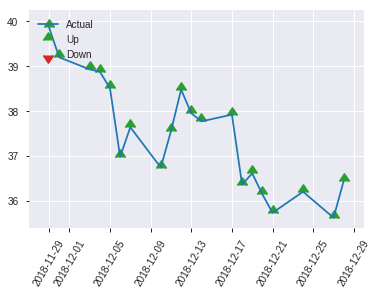


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2574605839681686
RMSE: 0.5074057389980612
LogLoss: 0.7084908116326202
Mean Per-Class Error: 0.4675625873681535
AUC: 0.49847502859321385
pr_auc: 0.5251532169679308
Gini: -0.003049942813572293
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2691193222999573: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    120  0.9836   (120.0/122.0)
1      0    129  0        (0.0/129.0)
Total  2    249  0.4781   (120.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.269119     0.68254   248
max f2                       0.269119     0.843137  248
max f0point5                 0.352794     0.581506  229
max accuracy                 0.352794     0.541833  229
max precision                0.70716      1         0
max recall                   0.269119     1         248
max specificity              0.70716      1         0
max absolute_mcc             0.352794     0.109191  229
max min_per_class_accuracy   0.451101     0.47541   125
max mean_per_class_accuracy  0.557851     0.532437  30

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 46.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.647514           0.648579  0.648579           0.333333         0.673181  0.333333                    0.673181            0.00775194      0.00775194                 -35.1421  -35.1421
    2        0.0239044                   0.632966           1.94574   1.29716            1                0.637955  0.666667                    0.655568            0.0232558       0.0310078                  94.5736   29.7158
    3        0.0318725                   0.621157           0.972868  1.21609            0.5              0.624526  0.625                       0.647808            0.00775194      0.0387597                  -2.71318  21.6085
    4        0.0438247                   0.610133           0.648579  1.06131            0.333333         0.615313  0.545455                    0.638946            0.00775194      0.0465116                  -35.1421  6.13108
    5        0.0517928                   0.602977           1.94574   1.19738            1                0.606799  0.615385                    0.634               0.0155039       0.0620155                  94.5736   19.7376
    6        0.103586                    0.57268            1.0477    1.12254            0.538462         0.585613  0.576923                    0.609806            0.0542636       0.116279                   4.77042   12.254
    7        0.151394                    0.551467           1.29716   1.17768            0.666667         0.56002   0.605263                    0.594084            0.0620155       0.178295                   29.7158   17.7683
    8        0.203187                    0.53062            0.74836   1.06825            0.384615         0.538803  0.54902                     0.579993            0.0387597       0.217054                   -25.164   6.82475
    9        0.302789                    0.506385           1.01178   1.04967            0.52             0.520268  0.539474                    0.560347            0.100775        0.317829                   1.17829   4.96736
    10       0.40239                     0.480333           0.778295  0.982501           0.4              0.491862  0.50495                     0.543395            0.0775194       0.395349                   -22.1705  -1.74994
    11       0.501992                    0.451101           0.856124  0.957426           0.44             0.462117  0.492063                    0.527269            0.0852713       0.48062                    -14.3876  -4.25741
    12       0.601594                    0.430119           0.856124  0.940654           0.44             0.440222  0.483444                    0.512857            0.0852713       0.565891                   -14.3876  -5.9346
    13       0.701195                    0.417867           1.16744   0.972868           0.6              0.424376  0.5                         0.500288            0.116279        0.682171                   16.7442   -2.71318
    14       0.800797                    0.396194           1.08961   0.987389           0.56             0.405477  0.507463                    0.488496            0.108527        0.790698                   8.96124   -1.26114
    15       0.900398                    0.360315           1.24527   1.01592            0.64             0.379262  0.522124                    0.476413            0.124031        0.914729                   24.5271   1.59155
    16       1                           0.242139           0.856124  1                  0.44             0.325556  0.513944                    0.461387     

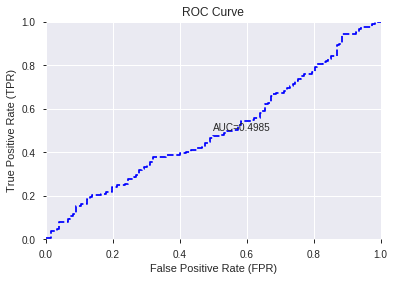

This function is available for GLM models only


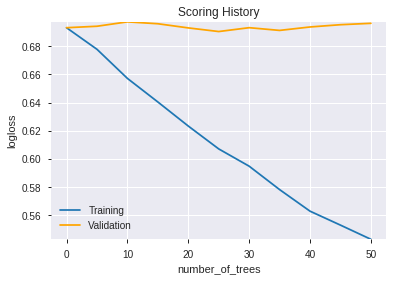

--2019-08-26 15:55:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_155415_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_155415_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_155509_model_5  0.578536  0.694036              0.449263  0.500502  0.250502
1  DeepLearning_grid_1_AutoML_20190826_155509_model_9  0.546257  0.688904              0.446277  0.497930  0.247934
2  DeepLearning_grid_1_AutoML_20190826_155509_model_6  0.544669  0.686329              0.483384  0.496757  0.246767
3  DeepLearning_grid_1_AutoML_20190826_155509_model_8  0.537711  0.690528              0.487705  0.498719  0.248721
4  DeepLearning_grid_1_AutoML_20190826_155509_model_2  0.524527  0.858778              0.458349  0.537403  0.288802
5               DeepLearning_1_AutoML_20190826_155509  0.499238  0.765271              0.466768  0.522490  0.272996
6  DeepLearning_grid_1_AutoML_20190826_155509_model_1  0.496759  1.165855              0.470644  0.573021  0.328353
7  DeepLearning_grid_1_AutoML_20190826_155509_model_3  0.492756  0.785148              0.466324  0.522360  0.272860
8  DeepLearning_grid_1_AutoML_20190826_155509_model_7  0.492693  0.737248              0.500000  0.515972  0.266228
9  DeepLearning_grid_1_AutoML_20190826_155509_model_4  0.489325  0.827831              0.487705  0.548783  0.301162

variable  relative_importance  scaled_importance  percentage
0     CDLSTALLEDPATTERN             1.000000           1.000000    0.022850
1        CDLMATCHINGLOW             0.943375           0.943375    0.021556
2             CDLHAMMER             0.940995           0.940995    0.021502
3           HT_DCPERIOD             0.934380           0.934380    0.021351
4      CDLSTICKSANDWICH             0.921911           0.921911    0.021066
5       CDLADVANCEBLOCK             0.919553           0.919553    0.021012
6     CDL3WHITESOLDIERS             0.918027           0.918027    0.020977
7      CDLDRAGONFLYDOJI             0.914351           0.914351    0.020893
8                   SIN             0.905726           0.905726    0.020696
9             CDLONNECK             0.905604           0.905604    0.020693
10                  day             0.905055           0.905055    0.020680
11   CDLEVENINGDOJISTAR             0.900305           0.900305    0.020572
12   CDLMORNINGDOJISTAR             0.899243           0.899243    0.020548
13            CDLTAKURI             0.899147           0.899147    0.020545
14         weekday_name             0.898334           0.898334    0.020527
15                  OBV             0.896198           0.896198    0.020478
16            CDLINNECK             0.895613           0.895613    0.020465
17       is_quarter_end             0.893203           0.893203    0.020410
18          CDLPIERCING             0.893202           0.893202    0.020410
19            CORREL_12             0.892918           0.892918    0.020403
20         CDLTHRUSTING             0.892816           0.892816    0.020401
21       CDLEVENINGSTAR             0.887680           0.887680    0.020283
22                  COS             0.886925           0.886925    0.020266
23   CDLUPSIDEGAP2CROWS             0.882869           0.882869    0.020173
24       CDLRICKSHAWMAN             0.881468           0.881468    0.020141
25      CDLUNIQUE3RIVER             0.881449           0.881449    0.020141
26      CDLLADDERBOTTOM             0.881275           0.881275    0.020137
27       CDL3BLACKCROWS             0.878888           0.878888    0.020083
28       CDLMORNINGSTAR             0.876813           0.876813    0.020035
29      CDLSHOOTINGSTAR             0.872997           0.872997    0.019948
30         is_month_end             0.871628           0.871628    0.019917
31             CORREL_8             0.871096           0.871096    0.019904
32   CDLSEPARATINGLINES             0.870600           0.870600    0.019893
33            CORREL_14             0.867896           0.867896    0.019831
34  CDLGAPSIDESIDEWHITE             0.861552           0.861552    0.019686
35            CORREL_30             0.857239           0.857239    0.019588
36       is_month_start             0.852443           0.852443    0.019478
37                  EXP             0.848079           0.848079    0.019379
38        CDLHANGINGMAN             0.842123           0.842123    0.019242
39                 SINH             0.826912           0.826912    0.018895
40    CDLGRAVESTONEDOJI             0.826518           0.826518    0.018886
41         CDLBREAKAWAY             0.822664           0.822664    0.018798
42                 TANH             0.816876           0.816876    0.018666
43         HT_TRENDMODE             0.815379           0.815379    0.018631
44    CDLINVERTEDHAMMER             0.814233           0.814233    0.018605
45                   AD             0.813179           0.813179    0.018581
46    CDLDARKCLOUDCOVER             0.802708           0.802708    0.018342
47      CDLHOMINGPIGEON             0.799104           0.799104    0.018259
48     is_quarter_start             0.792191           0.792191    0.018101
49                 COSH             0.791093           0.791093    0.018076

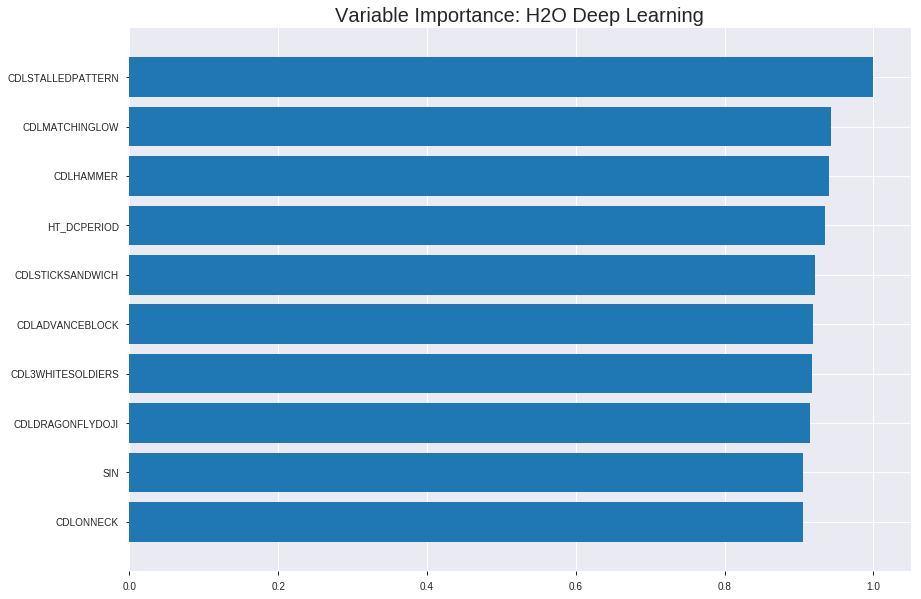

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_155509_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24918320575711558
RMSE: 0.4991825375121966
LogLoss: 0.6913515844953372
Mean Per-Class Error: 0.45412654154658416
AUC: 0.5559721018143193
pr_auc: 0.5573617866452361
Gini: 0.11194420362863866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3836312174082802: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      44   827   0.9495   (827.0/871.0)
1      16   866   0.0181   (16.0/882.0)
Total  60   1693  0.4809   (843.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.383631     0.672621   349
max f2                       0.27496      0.835705   389
max f0point5                 0.393067     0.566124   342
max accuracy                 0.46353      0.545351   168
max precision                0.701353     1          0
max recall                   0.222499     1          395
max specificity              0.701353     1          0
max absolute_mcc             0.479003     0.0978477  115
max min_per_class_accuracy   0.458717     0.525832   186
max mean_per_class_accuracy  0.46353      0.545873   168

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 45.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.572542           1.2146    1.2146             0.611111         0.657271  0.611111                    0.657271            0.0124717       0.0124717                  21.4601   21.4601
    2        0.0205362                   0.53551            1.2146    1.2146             0.611111         0.549522  0.611111                    0.603397            0.0124717       0.0249433                  21.4601   21.4601
    3        0.0302339                   0.516603           1.28605   1.23752            0.647059         0.525483  0.622642                    0.578405            0.0124717       0.037415                   28.6048   23.7518
    4        0.040502                    0.507318           1.43544   1.28769            0.722222         0.510357  0.647887                    0.561154            0.0147392       0.0521542                  43.5437   28.7694
    5        0.0501997                   0.504102           1.28605   1.28738            0.647059         0.505084  0.647727                    0.550322            0.0124717       0.0646259                  28.6048   28.7376
    6        0.100399                    0.490744           1.21962   1.2535             0.613636         0.496477  0.630682                    0.5234              0.0612245       0.12585                    21.962    25.3498
    7        0.150029                    0.484275           1.05088   1.18647            0.528736         0.487171  0.596958                    0.511415            0.0521542       0.178005                   5.08771   18.6471
    8        0.200228                    0.47892            1.21962   1.19478            0.613636         0.481431  0.60114                     0.503898            0.0612245       0.239229                   21.962    19.4782
    9        0.300057                    0.471971           0.988086  1.12601            0.497143         0.475278  0.56654                     0.494376            0.0986395       0.337868                   -1.19145  12.6014
    10       0.399886                    0.464296           1.05623   1.10859            0.531429         0.467974  0.557775                    0.487785            0.105442        0.443311                   5.62293   10.8593
    11       0.500285                    0.458614           0.824373  1.05155            0.414773         0.461463  0.529076                    0.482503            0.0827664       0.526077                   -17.5627  5.15543
    12       0.600114                    0.452435           1.06759   1.05422            0.537143         0.455418  0.530418                    0.477997            0.106576        0.632653                   6.75867   5.42213
    13       0.699943                    0.445529           0.942656  1.03831            0.474286         0.449181  0.522412                    0.473887            0.0941043       0.726757                   -5.73437  3.83094
    14       0.799772                    0.43551            0.965371  1.02921            0.485714         0.440849  0.517832                    0.469763            0.0963719       0.823129                   -3.46291  2.92051
    15       0.899601                    0.419269           0.954014  1.02086            0.48             0.428634  0.513633                    0.465199            0.0952381       0.918367                   -4.59864  2.08611
    16       1                           0.188467           0.81308   1                  0.409091         0.37714   0.503137                    0.456358         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2519348746971032
RMSE: 0.5019311453746451
LogLoss: 0.6971355885537817
Mean Per-Class Error: 0.4685547622083387
AUC: 0.5209820859365039
pr_auc: 0.5100584292750879
Gini: 0.041964171873007716
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3217273061240744: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    253  1        (253.0/253.0)
1      0    248  0        (0.0/248.0)
Total  0    501  0.505    (253.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.321727     0.662216   399
max f2                       0.321727     0.830543   399
max f0point5                 0.433764     0.557573   326
max accuracy                 0.442472     0.528942   289
max precision                0.48933      0.633333   28
max recall                   0.321727     1          399
max specificity              0.684955     0.996047   0
max absolute_mcc             0.433764     0.0769461  326
max min_per_class_accuracy   0.45703      0.501976   197
max mean_per_class_accuracy  0.442472     0.531445   289

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 45.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.564946           1.01008   1.01008            0.5              0.634462  0.5                         0.634462            0.0120968       0.0120968                  1.00806   1.00806
    2        0.0219561                   0.548967           0.808065  0.918255           0.4              0.556652  0.454545                    0.599094            0.00806452      0.0201613                  -19.1935  -8.17449
    3        0.0319361                   0.521311           1.2121    1.01008            0.6              0.534923  0.5                         0.579041            0.0120968       0.0322581                  21.2097   1.00806
    4        0.0419162                   0.514671           1.2121    1.05818            0.6              0.517799  0.52381                     0.564459            0.0120968       0.0443548                  21.2097   5.81797
    5        0.0518962                   0.493821           1.61613   1.16548            0.8              0.499227  0.576923                    0.551915            0.016129        0.0604839                  61.6129   16.5478
    6        0.101796                    0.481347           1.13129   1.14872            0.56             0.485545  0.568627                    0.519381            0.0564516       0.116935                   13.129    14.8719
    7        0.151697                    0.476406           0.808065  1.03666            0.4              0.478651  0.513158                    0.505983            0.0403226       0.157258                   -19.1935  3.66617
    8        0.201597                    0.472372           1.2121    1.08009            0.6              0.474413  0.534653                    0.498168            0.0604839       0.217742                   21.2097   8.00862
    9        0.301397                    0.466756           0.929274  1.03015            0.46             0.46932   0.509934                    0.488616            0.0927419       0.310484                   -7.07258  3.01485
    10       0.401198                    0.461445           1.05048   1.03521            0.52             0.463941  0.512438                    0.482478            0.104839        0.415323                   5.04839   3.5207
    11       0.500998                    0.457021           0.888871  1.00606            0.44             0.459081  0.498008                    0.477817            0.0887097       0.504032                   -11.1129  0.605642
    12       0.600798                    0.451742           1.13129   1.02686            0.56             0.45417   0.508306                    0.473889            0.112903        0.616935                   13.129    2.68594
    13       0.700599                    0.445662           0.969677  1.01871            0.48             0.448798  0.504274                    0.470315            0.0967742       0.71371                    -3.03226  1.87138
    14       0.800399                    0.437019           1.13129   1.03275            0.56             0.441889  0.511222                    0.46677             0.112903        0.826613                   13.129    3.27508
    15       0.9002                      0.425158           0.727258  0.998882           0.36             0.431549  0.494457                    0.462866            0.0725806       0.899194                   -27.2742  -0.111759
    16       1                           0.321727           1.01008   1                  0.5              0.407981  0.49501                     0.457388      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:58:39  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 15:58:41  1 min 35.358 sec  1204 obs/sec      1.30804   1             2293       0.499183         0.691352            0.00322793     0.555972        0.557362           1.2146           0.48089                          0.501931           0.697136              -0.00783988      0.520982          0.510058             1.01008            0.50499
    2019-08-26 15:58:49  1 min 43.296 sec  2008 obs/sec      10.4022   8             18235      0.48851          0.668605            0.0453927      0.604966        0.617754           1.87711          0.460924                         0.50375            0.701025              -0.0151568       0.494796          0.496109             1.34677            0.500998
    2019-08-26 15:58:57  1 min 51.244 sec  2247 obs/sec      20.8985   16            36635      0.478124         0.645464            0.0855548      0.651057        0.655631           1.87711          0.419281                         0.507444           0.710963              -0.0300988       0.513045          0.505874             1.01008            0.499002
    2019-08-26 15:59:04  1 min 58.686 sec  2385 obs/sec      31.3234   24            54910      0.469156         0.624605            0.119536       0.70373         0.718515           1.98753          0.396463                         0.518055           0.753344              -0.07363         0.496127          0.488361             1.01008            0.502994
    2019-08-26 15:59:12  2 min  6.698 sec  2490 obs/sec      43.0319   33            75435      0.457823         0.599               0.16156        0.727722        0.742753           1.98753          0.378779                         0.523226           0.783365              -0.0951689       0.487098          0.484378             1.01008            0.502994
    2019-08-26 15:59:20  2 min 14.486 sec  2570 obs/sec      54.7878   42            96043      0.446785         0.573787            0.201502       0.762427        0.778477           1.98753          0.348545                         0.52493            0.803909              -0.102316        0.500446          0.489418             0.673387           0.502994
    2019-08-26 15:59:21  2 min 15.236 sec  2569 obs/sec      54.7878   42            96043      0.499183         0.691352            0.00322793     0.555972        0.557362           1.2146           0.48089                          0.501931           0.697136              -0.00783988      0.520982          0.510058             1.01008            0.50499

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLSTALLEDPATTERN  1.0                    1.0                  0.022849918174116822
CDLMATCHINGLOW     0.9433749318122864     0.9433749318122864   0.021556039999423782
CDLHAMMER          0.940995454788208      0.940995454788208    0.0215016691441264
HT_DCPERIOD        0.9343804717063904     0.9343804717063904   0.0213505173219837
CDLSTICKSANDWICH   0.9219107031822205     0.9219107031822205   0.02106558413155624
---                ---                    ---                  ---
AD                 0.8131786584854126     0.8131786584854126   0.018581065807329766
CDLDARKCLOUDCOVER  0.8027075529098511     0.8027075529098511   0.01834180190173565
CDLHOMINGPIGEON    0.7991037368774414     0.7991037368774414   0.018259455000280516
is_quarter_start   0.7921905517578125     0.7921905517578125   0.018101489285974475
COSH               0.7910934686660767     0.7910934686660767   0.018076421027098104


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6175298804780877)

('F1', 0.6892655367231639)

('auc', 0.5785360274494853)

('logloss', 0.6940358460885292)

('mean_per_class_error', 0.3874380480365993)

('rmse', 0.5005021822315959)

('mse', 0.25050243441858966)

deeplearning prediction progress: |███████████████████████████████████████| 100%


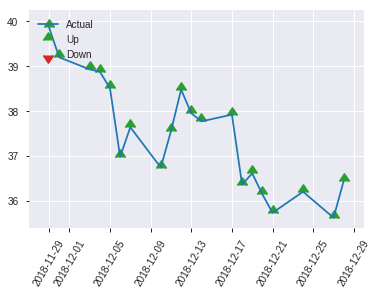


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25050243441858966
RMSE: 0.5005021822315959
LogLoss: 0.6940358460885292
Mean Per-Class Error: 0.3874380480365993
AUC: 0.5785360274494853
pr_auc: 0.545137192283107
Gini: 0.15707205489897058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4283312236884997: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   103  0.8443   (103.0/122.0)
1      7    122  0.0543   (7.0/129.0)
Total  26   225  0.4382   (110.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428331     0.689266  224
max f2                       0.394114     0.843137  248
max f0point5                 0.448023     0.627306  170
max accuracy                 0.448023     0.61753   170
max precision                0.479224     0.615385  25
max recall                   0.394114     1         248
max specificity              0.532721     0.991803  0
max absolute_mcc             0.448023     0.241465  170
max min_per_class_accuracy   0.458761     0.540984  125
max mean_per_class_accuracy  0.448023     0.612562  170

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 45.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.528605           0.648579  0.648579           0.333333         0.531085  0.333333                    0.531085            0.00775194      0.00775194                 -35.1421  -35.1421
    2        0.0239044                   0.518702           1.29716   0.972868           0.666667         0.524329  0.5                         0.527707            0.0155039       0.0232558                  29.7158   -2.71318
    3        0.0318725                   0.508064           0         0.729651           0                0.513344  0.375                       0.524116            0               0.0232558                  -100      -27.0349
    4        0.0438247                   0.500785           0.648579  0.707541           0.333333         0.503614  0.363636                    0.518525            0.00775194      0.0310078                  -35.1421  -29.2459
    5        0.0517928                   0.48882            0.972868  0.74836            0.5              0.494068  0.384615                    0.514762            0.00775194      0.0387597                  -2.71318  -25.164
    6        0.103586                    0.479224           1.64639   1.19738            0.846154         0.482435  0.615385                    0.498598            0.0852713       0.124031                   64.6392   19.7376
    7        0.151394                    0.476215           0.648579  1.02407            0.333333         0.478027  0.526316                    0.492102            0.0310078       0.155039                   -35.1421  2.40718
    8        0.203187                    0.472185           0.898032  0.991944           0.461538         0.474479  0.509804                    0.48761             0.0465116       0.20155                    -10.1968  -0.805594
    9        0.302789                    0.466981           1.16744   1.04967            0.6              0.470067  0.539474                    0.481839            0.116279        0.317829                   16.7442   4.96736
    10       0.40239                     0.462636           1.24527   1.09809            0.64             0.464675  0.564356                    0.477591            0.124031        0.44186                    24.5271   9.80889
    11       0.501992                    0.458761           1.01178   1.08096            0.52             0.460653  0.555556                    0.47423             0.100775        0.542636                   1.17829   8.09647
    12       0.601594                    0.452606           1.3231    1.12105            0.68             0.455834  0.576159                    0.471184            0.131783        0.674419                   32.3101   12.1053
    13       0.701195                    0.446347           1.24527   1.1387             0.64             0.449357  0.585227                    0.468084            0.124031        0.79845                    24.5271   13.8698
    14       0.800797                    0.440052           0.544806  1.06483            0.28             0.443204  0.547264                    0.464989            0.0542636       0.852713                   -45.5194  6.48309
    15       0.900398                    0.428058           0.933953  1.05035            0.48             0.434762  0.539823                    0.461646            0.0930233       0.945736                   -6.60465  5.03533
    16       1                           0.309716           0.544806  1                  0.28             0.407618  0.513944                    0.456264   

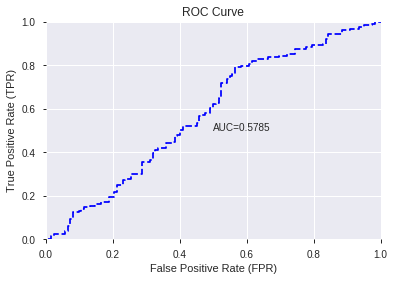

This function is available for GLM models only


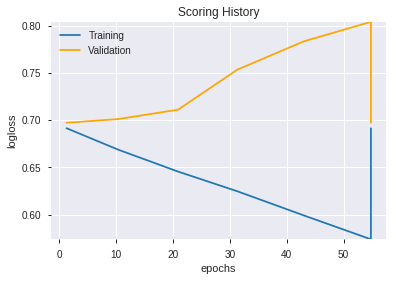

--2019-08-26 16:04:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_155509_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_155509_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSTALLEDPATTERN',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'HT_DCPERIOD',
 'CDLSTICKSANDWICH',
 'CDLADVANCEBLOCK',
 'CDL3WHITESOLDIERS',
 'CDLDRAGONFLYDOJI',
 'SIN',
 'CDLONNECK',
 'day',
 'CDLEVENINGDOJISTAR',
 'CDLMORNINGDOJISTAR',
 'CDLTAKURI',
 'weekday_name',
 'OBV',
 'CDLINNECK',
 'is_quarter_end',
 'CDLPIERCING',
 'CORREL_12',
 'CDLTHRUSTING',
 'CDLEVENINGSTAR',
 'COS',
 'CDLUPSIDEGAP2CROWS',
 'CDLRICKSHAWMAN',
 'CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'CDL3BLACKCROWS',
 'CDLMORNINGSTAR',
 'CDLSHOOTINGSTAR',
 'is_month_end',
 'CORREL_8',
 'CDLSEPARATINGLINES',
 'CORREL_14',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_30',
 'is_month_start',
 'EXP',
 'CDLHANGINGMAN',
 'SINH',
 'CDLGRAVESTONEDOJI',
 'CDLBREAKAWAY',
 'TANH',
 'HT_TRENDMODE',
 'CDLINVERTEDHAMMER',
 'AD',
 'CDLDARKCLOUDCOVER',
 'CDLHOMINGPIGEON',
 'is_quarter_start',
 'COSH']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_160503_model_1  0.53158  0.691284              0.462892  0.499067  0.249068

variable  relative_importance  scaled_importance  percentage
0    CDLSEPARATINGLINES             0.013475           1.000000    0.052009
1                   OBV             0.013002           0.964894    0.050183
2                   day             0.012055           0.894669    0.046531
3    CDLEVENINGDOJISTAR             0.009839           0.730218    0.037978
4       CDLADVANCEBLOCK             0.009715           0.720968    0.037497
5                   EXP             0.009455           0.701711    0.036496
6                  SINH             0.009439           0.700494    0.036432
7                  COSH             0.009427           0.699581    0.036385
8      is_quarter_start             0.009093           0.674816    0.035097
9                  TANH             0.009091           0.674643    0.035088
10    CDLINVERTEDHAMMER             0.008737           0.648393    0.033723
11                  SIN             0.008590           0.637510    0.033156
12         CDLTHRUSTING             0.008071           0.598983    0.031153
13       is_month_start             0.006618           0.491141    0.025544
14         is_month_end             0.006508           0.482954    0.025118
15                   AD             0.006254           0.464099    0.024137
16            CORREL_30             0.006122           0.454367    0.023631
17       CDLEVENINGSTAR             0.006009           0.445950    0.023194
18     CDLDRAGONFLYDOJI             0.005986           0.444240    0.023105
19            CDLTAKURI             0.005982           0.443980    0.023091
20      CDLUNIQUE3RIVER             0.005645           0.418959    0.021790
21   CDLUPSIDEGAP2CROWS             0.005642           0.418680    0.021775
22  CDLGAPSIDESIDEWHITE             0.005608           0.416190    0.021646
23    CDL3WHITESOLDIERS             0.005600           0.415604    0.021615
24       is_quarter_end             0.005519           0.409605    0.021303
25            CDLINNECK             0.005336           0.396031    0.020597
26       CDL3BLACKCROWS             0.005292           0.392767    0.020428
27    CDLSTALLEDPATTERN             0.005132           0.380868    0.019809
28         weekday_name             0.005103           0.378692    0.019696
29         CDLBREAKAWAY             0.005099           0.378385    0.019680
30     CDLSTICKSANDWICH             0.004842           0.359362    0.018690
31       CDLRICKSHAWMAN             0.004585           0.340260    0.017697
32      CDLLADDERBOTTOM             0.002668           0.197989    0.010297
33          CDLPIERCING             0.002602           0.193095    0.010043
34      CDLHOMINGPIGEON             0.002589           0.192107    0.009991
35      CDLSHOOTINGSTAR             0.002376           0.176323    0.009170
36    CDLGRAVESTONEDOJI             0.001815           0.134702    0.007006
37             CORREL_8             0.001751           0.129968    0.006760
38       CDLMATCHINGLOW             0.001350           0.100154    0.005209
39    CDLDARKCLOUDCOVER             0.001267           0.094019    0.004890
40            CORREL_14             0.001194           0.088637    0.004610
41            CORREL_12             0.000878           0.065157    0.003389
42        CDLHANGINGMAN             0.000829           0.061498    0.003198
43          HT_DCPERIOD             0.000641           0.047590    0.002475
44   CDLMORNINGDOJISTAR             0.000538           0.039932    0.002077
45       CDLMORNINGSTAR             0.000476           0.035360    0.001839
46         HT_TRENDMODE             0.000441           0.032704    0.001701
47            CDLHAMMER             0.000426           0.031612    0.001644
48                  COS             0.000328           0.024354    0.001267
49            CDLONNECK             0.000042           0.003097    0.000161

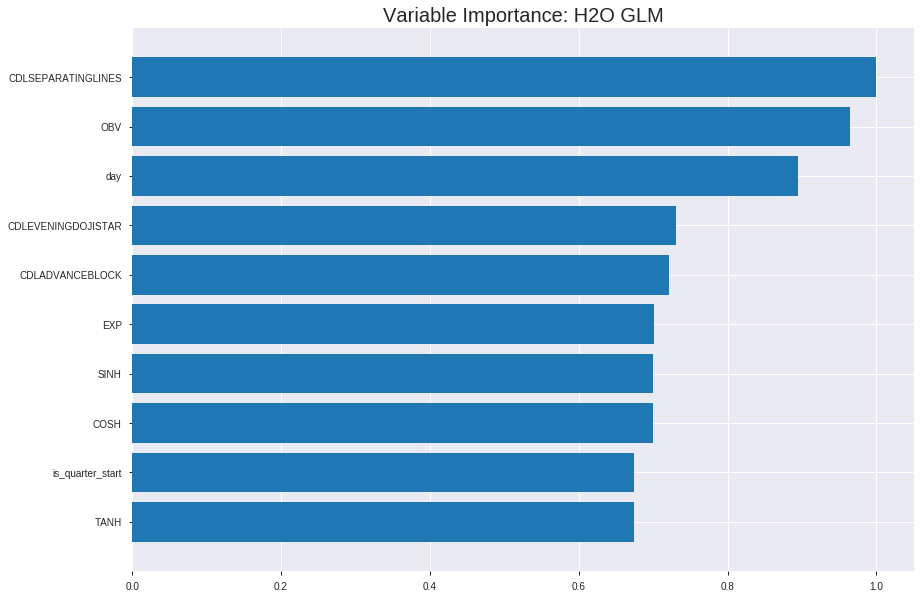

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_160503_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.247948860073792
RMSE: 0.49794463555077284
LogLoss: 0.6890270244126911
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2430.1049900608095
Residual deviance: 2415.728747590895
AIC: 2517.728747590895
AUC: 0.5720631536196568
pr_auc: 0.5769847282559428
Gini: 0.14412630723931352
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47091543180721074: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      37   834   0.9575   (834.0/871.0)
1      10   872   0.0113   (10.0/882.0)
Total  47   1706  0.4815   (844.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470915     0.673879  359
max f2                       0.444546     0.837134  382
max f0point5                 0.500943     0.572898  222
max accuracy                 0.500943     0.555619  222
max precision                0.598453     1         0
max recall                   0.427038     1         390
max specificity              0.598453     1         0
max absolute_mcc             0.500943     0.11667   222
max min_per_class_accuracy   0.504285     0.546498  184
max mean_per_class_accuracy  0.503071     0.554558  198

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 50.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0102681                   0.541777           1.65627   1.65627            0.833333         0.559305  0.833333                    0.559305            0.0170068       0.0170068                  65.6274     65.6274
    2        0.0205362                   0.532238           1.54586   1.60106            0.777778         0.535897  0.805556                    0.547601            0.015873        0.0328798                  54.5855     60.1064
    3        0.0302339                   0.528928           1.28605   1.50002            0.647059         0.530726  0.754717                    0.542188            0.0124717       0.0453515                  28.6048     50.0021
    4        0.040502                    0.524459           1.10418   1.39967            0.555556         0.526671  0.704225                    0.538254            0.0113379       0.0566893                  10.4182     39.9668
    5        0.0501997                   0.521141           1.16913   1.35513            0.588235         0.522804  0.681818                    0.535269            0.0113379       0.0680272                  16.9134     35.5133
    6        0.100399                    0.513581           1.24221   1.29867            0.625            0.516213  0.653409                    0.525741            0.0623583       0.130385                   24.2205     29.8669
    7        0.150029                    0.511032           1.05088   1.2167             0.528736         0.512208  0.612167                    0.521265            0.0521542       0.18254                    5.08771     21.67
    8        0.200228                    0.509684           1.01635   1.16647            0.511364         0.510281  0.586895                    0.518511            0.0510204       0.23356                    1.63497     16.647
    9        0.300057                    0.507571           1.0903    1.14113            0.548571         0.50858   0.574144                    0.515207            0.108844        0.342404                   9.03013     14.1128
    10       0.399886                    0.505794           1.05623   1.11993            0.531429         0.506659  0.563481                    0.513073            0.105442        0.447846                   5.62293     11.9934
    11       0.500285                    0.504282           1.01635   1.09915            0.511364         0.505009  0.553022                    0.511455            0.102041        0.549887                   1.63497     9.91462
    12       0.600114                    0.502573           0.988086  1.08067            0.497143         0.503508  0.543726                    0.510133            0.0986395       0.648526                   -1.19145    8.06713
    13       0.699943                    0.500473           0.999443  1.06909            0.502857         0.50158   0.537897                    0.508913            0.0997732       0.748299                   -0.0557175  6.90862
    14       0.799772                    0.497359           0.749582  1.02921            0.377143         0.499091  0.517832                    0.507687            0.0748299       0.823129                   -25.0418    2.92051
    15       0.899601                    0.49172            1.06759   1.03346            0.537143         0.494868  0.519975                    0.506264            0.106576        0.929705                   6.75867     3.34643
    16       1                           0.388826           0.700152  1                  0.352273         0.475119  0.503137      



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24990467560242002
RMSE: 0.49990466651394644
LogLoss: 0.6929559198627127
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 694.6159526243423
Residual deviance: 694.3418317024381
AIC: 796.3418317024381
AUC: 0.5163760678311871
pr_auc: 0.5140251911880032
Gini: 0.032752135662374116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4408016418952932: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    252  0.996    (252.0/253.0)
1      0    248  0        (0.0/248.0)
Total  1    500  0.503    (252.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.440802     0.663102   398
max f2                       0.440802     0.831099   398
max f0point5                 0.498502     0.558128   325
max accuracy                 0.51005      0.536926   84
max precision                0.571299     1          0
max recall                   0.440802     1          398
max specificity              0.571299     1          0
max absolute_mcc             0.51005      0.0878658  84
max min_per_class_accuracy   0.504373     0.504032   194
max mean_per_class_accuracy  0.509862     0.533812   86

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 50.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.54614            1.34677   1.34677            0.666667         0.559956  0.666667                    0.559956            0.016129        0.016129                   34.6774   34.6774
    2        0.0219561                   0.533041           0.808065  1.10191            0.4              0.533559  0.545455                    0.547958            0.00806452      0.0241935                  -19.1935  10.1906
    3        0.0319361                   0.530052           0.808065  1.01008            0.4              0.531449  0.5                         0.542799            0.00806452      0.0322581                  -19.1935  1.00806
    4        0.0419162                   0.524561           0.808065  0.961982           0.4              0.527385  0.47619                     0.539129            0.00806452      0.0403226                  -19.1935  -3.80184
    5        0.0518962                   0.521332           0.808065  0.932382           0.4              0.521882  0.461538                    0.535812            0.00806452      0.0483871                  -19.1935  -6.76179
    6        0.101796                    0.51286            1.05048   0.990275           0.52             0.515781  0.490196                    0.525993            0.0524194       0.100806                   5.04839   -0.972486
    7        0.151697                    0.510865           1.61613   1.19615            0.8              0.511815  0.592105                    0.521329            0.0806452       0.181452                   61.6129   19.6148
    8        0.201597                    0.509413           0.969677  1.14009            0.48             0.51011   0.564356                    0.518552            0.0483871       0.229839                   -3.03226  14.0091
    9        0.301397                    0.507464           0.808065  1.03015            0.4              0.508438  0.509934                    0.515203            0.0806452       0.310484                   -19.1935  3.01485
    10       0.401198                    0.505564           0.888871  0.995005           0.44             0.506472  0.492537                    0.513031            0.0887097       0.399194                   -11.1129  -0.499519
    11       0.500998                    0.504267           1.05048   1.00606            0.52             0.504942  0.498008                    0.51142             0.104839        0.504032                   5.04839   0.605642
    12       0.600798                    0.503082           0.929274  0.993302           0.46             0.503767  0.491694                    0.510149            0.0927419       0.596774                   -7.07258  -0.66981
    13       0.700599                    0.501856           1.01008   0.995692           0.5              0.502537  0.492877                    0.509064            0.100806        0.697581                   1.00806   -0.430797
    14       0.800399                    0.499771           1.17169   1.01764            0.58             0.500807  0.503741                    0.508035            0.116935        0.814516                   17.1694   1.76374
    15       0.9002                      0.496344           1.05048   1.02128            0.52             0.49823   0.505543                    0.506948            0.104839        0.919355                   5.04839   2.12789
    16       1                           0.437339           0.808065  1                  0.4              0.484868  0.49501                     0.50474


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 16:05:03  0.000 sec   2            3         51            1.38058           1.38595
    2019-08-26 16:05:03  0.011 sec   4            1.9       51            1.37805           1.38591
    2019-08-26 16:05:03  0.020 sec   6            1.2       51            1.37488           1.38612
    2019-08-26 16:05:03  0.027 sec   8            0.71      51            1.37124           1.3868
    2019-08-26 16:05:03  0.036 sec   10           0.44      51            1.36744           1.38827
    2019-08-26 16:05:03  0.046 sec   12           0.28      51            1.36388           1.39077
    2019-08-26 16:05:03  0.055 sec   14           0.17      51            1.36087           1.39441

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.549800796812749)

('F1', 0.6937669376693767)

('auc', 0.5315796162155293)

('logloss', 0.6912839795882136)

('mean_per_class_error', 0.45421908755877494)

('rmse', 0.49906693024252335)

('mse', 0.24906780086169567)

glm prediction progress: |████████████████████████████████████████████████| 100%


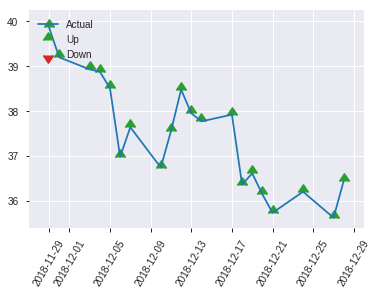


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24906780086169567
RMSE: 0.49906693024252335
LogLoss: 0.6912839795882136
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.88191742869697
Residual deviance: 347.02455775328326
AIC: 449.02455775328326
AUC: 0.5315796162155293
pr_auc: 0.5354310088227963
Gini: 0.06315923243105859
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49269832764652144: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   112  0.918    (112.0/122.0)
1      1    128  0.0078   (1.0/129.0)
Total  11   240  0.4502   (113.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492698     0.693767  239
max f2                       0.485313     0.847569  244
max f0point5                 0.492698     0.587695  239
max accuracy                 0.50196      0.549801  161
max precision                0.525896     0.75      7
max recall                   0.485313     1         244
max specificity              0.565184     0.991803  0
max absolute_mcc             0.492698     0.181203  239
max min_per_class_accuracy   0.505058     0.472868  122
max mean_per_class_accuracy  0.50196      0.545781  161

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.536291           0.648579  0.648579           0.333333         0.555626  0.333333                    0.555626            0.00775194      0.00775194                 -35.1421  -35.1421
    2        0.0239044                   0.529531           1.94574   1.29716            1                0.531568  0.666667                    0.543597            0.0232558       0.0310078                  94.5736   29.7158
    3        0.0318725                   0.524389           1.94574   1.4593             1                0.526857  0.75                        0.539412            0.0155039       0.0465116                  94.5736   45.9302
    4        0.0438247                   0.522414           0         1.06131            0                0.522684  0.545455                    0.53485             0               0.0465116                  -100      6.13108
    5        0.0517928                   0.518727           0.972868  1.0477             0.5              0.520309  0.538462                    0.532613            0.00775194      0.0542636                  -2.71318  4.77042
    6        0.103586                    0.515813           1.0477    1.0477             0.538462         0.516853  0.538462                    0.524733            0.0542636       0.108527                   4.77042   4.77042
    7        0.151394                    0.513318           1.13501   1.07528            0.583333         0.514662  0.552632                    0.521553            0.0542636       0.162791                   13.5013   7.52754
    8        0.203187                    0.511594           1.49672   1.1827             0.769231         0.512468  0.607843                    0.519237            0.0775194       0.24031                    49.672    18.2703
    9        0.302789                    0.508494           0.933953  1.10088            0.48             0.50982   0.565789                    0.516139            0.0930233       0.333333                   -6.60465  10.0877
    10       0.40239                     0.506813           0.700465  1.00177            0.36             0.507644  0.514851                    0.514036            0.0697674       0.403101                   -29.9535  0.176529
    11       0.501992                    0.504894           0.700465  0.941984           0.36             0.505739  0.484127                    0.51239             0.0697674       0.472868                   -29.9535  -5.80165
    12       0.601594                    0.502705           1.47876   1.03085            0.76             0.503529  0.529801                    0.510923            0.147287        0.620155                   47.876    3.08537
    13       0.701195                    0.501219           1.08961   1.0392             0.56             0.501968  0.534091                    0.509651            0.108527        0.728682                   8.96124   3.92001
    14       0.800797                    0.498694           1.08961   1.04547            0.56             0.499819  0.537313                    0.508428            0.108527        0.837209                   8.96124   4.54703
    15       0.900398                    0.495953           0.778295  1.01592            0.4              0.497195  0.522124                    0.507185            0.0775194       0.914729                   -22.1705  1.59155
    16       1                           0.445682           0.856124  1                  0.44             0.487045  0.513944                    0.505179      

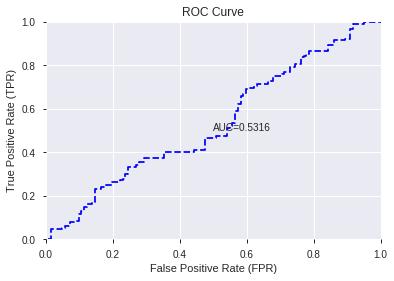

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


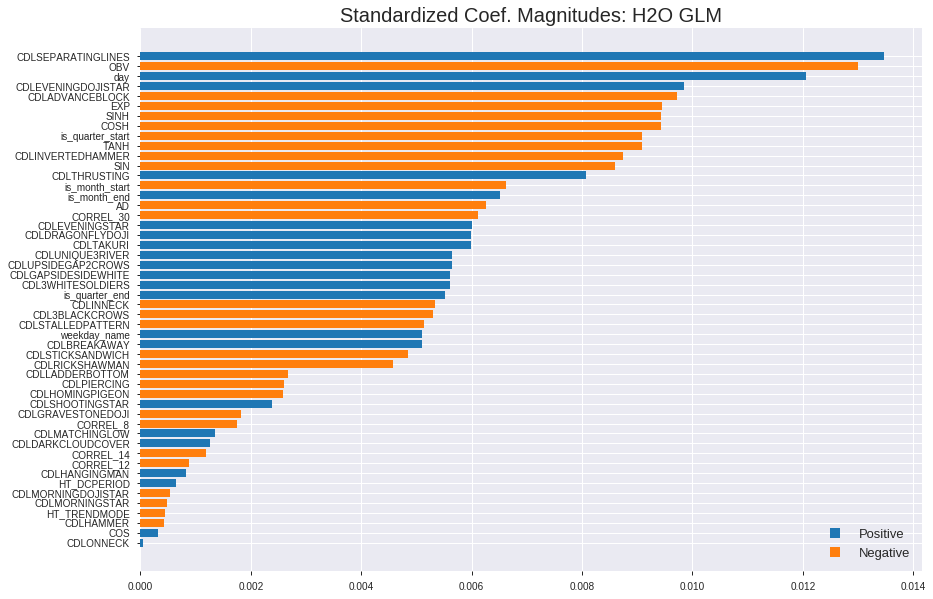

'log_likelihood'
--2019-08-26 16:05:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.92
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.92|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_160503_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_160503_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLSEPARATINGLINES',
 'OBV',
 'day',
 'CDLEVENINGDOJISTAR',
 'CDLADVANCEBLOCK',
 'EXP',
 'SINH',
 'COSH',
 'is_quarter_start',
 'TANH',
 'CDLINVERTEDHAMMER',
 'SIN',
 'CDLTHRUSTING',
 'is_month_start',
 'is_month_end',
 'AD',
 'CORREL_30',
 'CDLEVENINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLUNIQUE3RIVER',
 'CDLUPSIDEGAP2CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDL3WHITESOLDIERS',
 'is_quarter_end',
 'CDLINNECK',
 'CDL3BLACKCROWS',
 'CDLSTALLEDPATTERN',
 'weekday_name',
 'CDLBREAKAWAY',
 'CDLSTICKSANDWICH',
 'CDLRICKSHAWMAN',
 'CDLLADDERBOTTOM',
 'CDLPIERCING',
 'CDLHOMINGPIGEON',
 'CDLSHOOTINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CORREL_8',
 'CDLMATCHINGLOW',
 'CDLDARKCLOUDCOVER',
 'CORREL_14',
 'CORREL_12',
 'CDLHANGINGMAN',
 'HT_DCPERIOD',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'HT_TRENDMODE',
 'CDLHAMMER',
 'COS',
 'CDLONNECK']

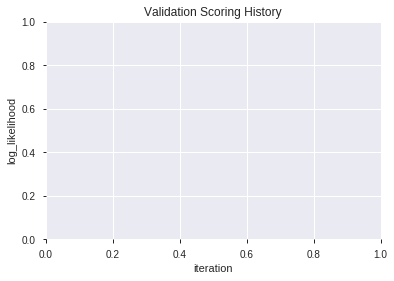

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_160514_model_6  0.519380  0.700581              0.469977  0.503540  0.253552
1  XGBoost_grid_1_AutoML_20190826_160514_model_7  0.518300  0.713607              0.470644  0.509050  0.259132
2  XGBoost_grid_1_AutoML_20190826_160514_model_5  0.513725  0.722365              0.487705  0.512999  0.263168
3  XGBoost_grid_1_AutoML_20190826_160514_model_3  0.511183  0.702488              0.483384  0.504369  0.254388
4  XGBoost_grid_1_AutoML_20190826_160514_model_4  0.488880  0.703148              0.491358  0.504907  0.254931
5  XGBoost_grid_1_AutoML_20190826_160514_model_2  0.485068  0.705632              0.479286  0.506130  0.256167
6               XGBoost_2_AutoML_20190826_160514  0.482272  0.716226              0.500000  0.510969  0.261089
7               XGBoost_1_AutoML_20190826_160514  0.481446  0.724011              0.483607  0.514160  0.264361
8               XGBoost_3_AutoML_20190826_160514  0.466387  0.715426              0.495679  0.510779  0.260896
9  XGBoost_grid_1_AutoML_20190826_160514_model_1  0.461240  0.721122              0.495679  0.513332  0.263510

variable  relative_importance  scaled_importance  percentage
0         CORREL_30           774.686523           1.000000    0.141330
1       HT_DCPERIOD           624.933472           0.806692    0.114010
2               SIN           546.010132           0.704814    0.099612
3               OBV           485.127228           0.626224    0.088504
4                AD           455.668091           0.588197    0.083130
5         CORREL_14           430.380310           0.555554    0.078517
6               COS           415.940948           0.536915    0.075882
7         CORREL_12           412.002472           0.531831    0.075164
8          CORREL_8           341.689056           0.441068    0.062336
9               day           327.743500           0.423066    0.059792
10             COSH           325.409149           0.420053    0.059366
11     weekday_name           180.252792           0.232678    0.032884
12              EXP            69.428284           0.089621    0.012666
13             SINH            21.217215           0.027388    0.003871
14     HT_TRENDMODE            20.090265           0.025933    0.003665
15     is_month_end            14.388058           0.018573    0.002625
16  CDLADVANCEBLOCK            14.373991           0.018555    0.002622
17  CDLSHOOTINGSTAR             8.869091           0.011449    0.001618
18   CDLRICKSHAWMAN             5.228150           0.006749    0.000954
19  CDLHOMINGPIGEON             4.002765           0.005167    0.000730
20     CDLTHRUSTING             3.951625           0.005101    0.000721

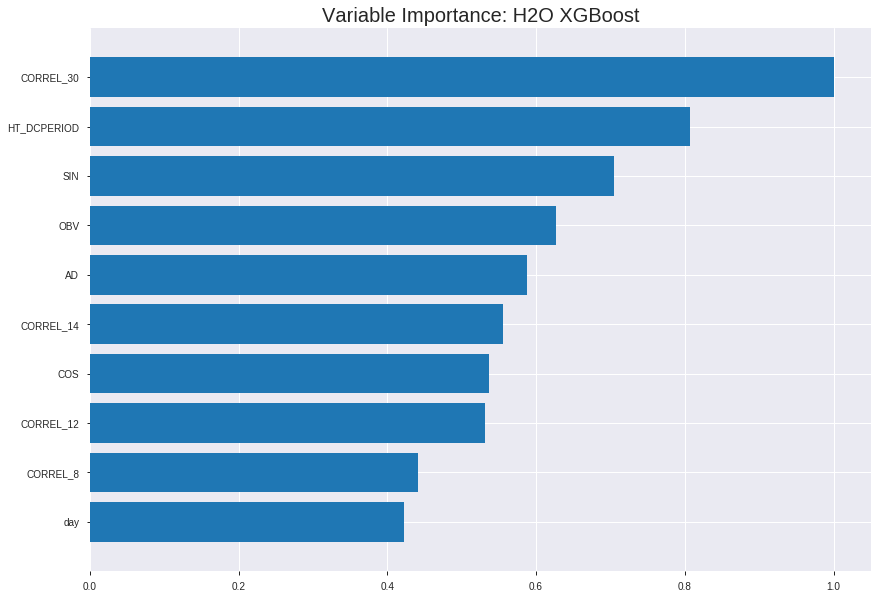

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_160514_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19858990052734235
RMSE: 0.4456342676762441
LogLoss: 0.5875780442053526
Mean Per-Class Error: 0.2166509160112572
AUC: 0.8735261421828586
pr_auc: 0.8768230841924044
Gini: 0.7470522843657172
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45590565885816303: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      540  331   0.38     (331.0/871.0)
1      73   809   0.0828   (73.0/882.0)
Total  613  1140  0.2305   (404.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455906     0.800198  261
max f2                       0.434109     0.880399  285
max f0point5                 0.529438     0.805834  177
max accuracy                 0.496382     0.783229  214
max precision                0.832327     1         0
max recall                   0.358033     1         359
max specificity              0.832327     1         0
max absolute_mcc             0.496382     0.56703   214
max min_per_class_accuracy   0.491764     0.778912  220
max mean_per_class_accuracy  0.496382     0.783349  214

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.747456           1.98753    1.98753            1                0.771592  1                           0.771592            0.0204082       0.0204082                  98.7528   98.7528
    2        0.0205362                   0.714687           1.98753    1.98753            1                0.729033  1                           0.750312            0.0204082       0.0408163                  98.7528   98.7528
    3        0.0302339                   0.696136           1.98753    1.98753            1                0.70286   1                           0.735092            0.0192744       0.0600907                  98.7528   98.7528
    4        0.040502                    0.683623           1.98753    1.98753            1                0.690334  1                           0.723745            0.0204082       0.0804989                  98.7528   98.7528
    5        0.0501997                   0.670231           1.98753    1.98753            1                0.675941  1                           0.71451             0.0192744       0.0997732                  98.7528   98.7528
    6        0.100399                    0.637147           1.91977    1.95365            0.965909         0.652717  0.982955                    0.683613            0.0963719       0.196145                   91.9772   95.365
    7        0.150029                    0.611661           1.8733     1.92707            0.942529         0.626096  0.969582                    0.664587            0.0929705       0.289116                   87.3303   92.7071
    8        0.200228                    0.588205           1.73909    1.87994            0.875            0.600052  0.945869                    0.648407            0.0873016       0.376417                   73.9087   87.9941
    9        0.300057                    0.549406           1.59002    1.78349            0.8              0.568139  0.897338                    0.621702            0.15873         0.535147                   59.0023   78.3486
    10       0.399886                    0.518541           1.30609    1.66431            0.657143         0.532942  0.837375                    0.599544            0.130385        0.665533                   30.609    66.4307
    11       0.500285                    0.491621           1.11798    1.55467            0.5625           0.504611  0.782212                    0.580492            0.112245        0.777778                   11.7985   55.4669
    12       0.600114                    0.469042           0.919942   1.44908            0.462857         0.479899  0.729087                    0.563758            0.0918367       0.869615                   -8.00583  44.9082
    13       0.699943                    0.444071           0.71551    1.34446            0.36             0.45589   0.676447                    0.548374            0.0714286       0.941043                   -28.449   34.4457
    14       0.799772                    0.417567           0.374791   1.22342            0.188571         0.430156  0.615549                    0.533618            0.037415        0.978458                   -62.5209  22.3422
    15       0.899601                    0.387802           0.159002   1.1053             0.08             0.403798  0.556119                    0.519212            0.015873        0.994331                   -84.0998  10.5303
    16       1                           0.231322           0.0564639  1                  0.0284091        0.352651  0.503137                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2532225346707652
RMSE: 0.5032122163369698
LogLoss: 0.7002613254674529
Mean Per-Class Error: 0.4479073696289685
AUC: 0.5313496111181946
pr_auc: 0.5175673902974959
Gini: 0.06269922223638913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3564857840538025: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    252  0.996    (252.0/253.0)
1      0    248  0        (0.0/248.0)
Total  1    500  0.503    (252.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356486     0.663102  398
max f2                       0.356486     0.831099  398
max f0point5                 0.356486     0.551601  398
max accuracy                 0.534316     0.552894  151
max precision                0.565943     0.590164  110
max recall                   0.356486     1         398
max specificity              0.752205     0.996047  0
max absolute_mcc             0.565943     0.107979  110
max min_per_class_accuracy   0.502288     0.532258  205
max mean_per_class_accuracy  0.521036     0.552093  177

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.726513           0.673387  0.673387           0.333333         0.737833  0.333333                    0.737833            0.00806452      0.00806452                 -32.6613  -32.6613
    2        0.0219561                   0.688799           1.2121    0.918255           0.6              0.697811  0.454545                    0.719641            0.0120968       0.0201613                  21.2097   -8.17449
    3        0.0319361                   0.676254           1.2121    1.01008            0.6              0.681522  0.5                         0.707729            0.0120968       0.0322581                  21.2097   1.00806
    4        0.0419162                   0.668876           1.2121    1.05818            0.6              0.670642  0.52381                     0.698899            0.0120968       0.0443548                  21.2097   5.81797
    5        0.0518962                   0.666334           0.404032  0.932382           0.2              0.667573  0.461538                    0.692875            0.00403226      0.0483871                  -59.5968  -6.76179
    6        0.101796                    0.633719           1.2121    1.0695             0.6              0.648012  0.529412                    0.670883            0.0604839       0.108871                   21.2097   6.94972
    7        0.151697                    0.610122           1.13129   1.08982            0.56             0.618927  0.539474                    0.653792            0.0564516       0.165323                   13.129    8.98239
    8        0.201597                    0.582692           1.2929    1.14009            0.64             0.593903  0.564356                    0.638968            0.0645161       0.229839                   29.2903   14.0091
    9        0.301397                    0.544734           1.09089   1.1238             0.54             0.561609  0.556291                    0.613353            0.108871        0.33871                    9.08871   12.3798
    10       0.401198                    0.526505           1.01008   1.09551            0.5              0.534528  0.542289                    0.593744            0.100806        0.439516                   1.00806   9.55104
    11       0.500998                    0.501959           0.929274  1.0624             0.46             0.514401  0.525896                    0.577939            0.0927419       0.532258                   -7.07258  6.23956
    12       0.600798                    0.483788           0.969677  1.04699            0.48             0.491745  0.518272                    0.563621            0.0967742       0.629032                   -3.03226  4.69939
    13       0.700599                    0.467414           0.808065  1.01296            0.4              0.476506  0.501425                    0.551211            0.0806452       0.709677                   -19.1935  1.29584
    14       0.800399                    0.446897           0.929274  1.00252            0.46             0.456638  0.496259                    0.539419            0.0927419       0.802419                   -7.07258  0.252393
    15       0.9002                      0.418918           0.808065  0.980965           0.4              0.434098  0.485588                    0.527743            0.0806452       0.883065                   -19.1935  -1.90348
    16       1                           0.345705           1.17169   1                  0.58             0.391142  0.49501                     0.51411     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 16:05:23  5.860 sec   0                  0.5              0.693147            0.5             0                  1                0.496863                         0.5                0.693147              0.5               0                    1                  0.50499
    2019-08-26 16:05:23  5.909 sec   5                  0.492598         0.678425            0.705661        0.71673            1.88292          0.411295                         0.499972           0.693094              0.517962          0.509117             1.01008            0.50499
    2019-08-26 16:05:23  5.944 sec   10                 0.486805         0.666979            0.744453        0.753839           1.98753          0.341129                         0.499841           0.69285               0.527572          0.528118             1.01008            0.50499
    2019-08-26 16:05:23  5.985 sec   15                 0.480489         0.65458             0.775909        0.783318           1.98753          0.319452                         0.499685           0.692563              0.532489          0.522923             1.01008            0.50499
    2019-08-26 16:05:23  6.027 sec   20                 0.474379         0.642622            0.794859        0.803031           1.98753          0.293212                         0.500535           0.694373              0.529031          0.517363             1.01008            0.502994
    2019-08-26 16:05:23  6.077 sec   25                 0.468601         0.631442            0.818002        0.820684           1.98753          0.284084                         0.50186            0.69716               0.525899          0.508212             0.673387           0.50499
    2019-08-26 16:05:23  6.126 sec   30                 0.463944         0.622441            0.830125        0.833131           1.98753          0.262978                         0.502797           0.699153              0.522241          0.50732              0.673387           0.50499
    2019-08-26 16:05:23  6.170 sec   35                 0.459072         0.613053            0.838797        0.843893           1.98753          0.271535                         0.503515           0.700675              0.518344          0.504645             0.673387           0.50499
    2019-08-26 16:05:23  6.213 sec   40                 0.453843         0.603094            0.854514        0.858407           1.98753          0.243012                         0.503966           0.701781              0.520831          0.508568             0.673387           0.50499
    2019-08-26 16:05:23  6.259 sec   45                 0.449309         0.594497            0.865245        0.868949           1.98753          0.232744                         0.503533           0.700922              0.527118          0.513038             0.673387           0.502994
    2019-08-26 16:05:23  6.304 sec   50                 0.445634         0.587578            0.873526        0.876823           1.98753          0.230462                         0.503212           0.700261              0.53135           0.517567             0.673387           0.502994

Variable Importances: 


variable         relative_importance    scaled_importance     percentage
---------------  ---------------------  --------------------  ---------------------
CORREL_30        774.6865234375         1.0                   0.1413302251651707
HT_DCPERIOD      624.9334716796875      0.8066920654649877    0.11400997125112332
SIN              546.0101318359375      0.7048142898022007    0.09961156227737489
OBV              485.1272277832031      0.6262239152303288    0.08850436694331713
AD               455.6680908203125      0.588196744146763     0.08312997829168231
---              ---                    ---                   ---
CDLADVANCEBLOCK  14.373991012573242     0.0185545902474098    0.0026223244175139072
CDLSHOOTINGSTAR  8.869091033935547      0.011448619235792198  0.0016180359344248158
CDLRICKSHAWMAN   5.228150367736816      0.006748730240637279  0.0009537995644882632
CDLHOMINGPIGEON  4.002764701843262      0.005166947637196371  0.0007302458729816098
CDLTHRUSTING     3.951624870300293      0.005100934056224229  0.0007209161587188577


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6814404432132963)

('auc', 0.5193798449612403)

('logloss', 0.7005813618791227)

('mean_per_class_error', 0.442019316304486)

('rmse', 0.5035395222501512)

('mse', 0.2535520504679105)

xgboost prediction progress: |████████████████████████████████████████████| 100%


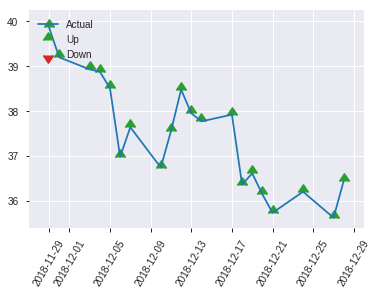


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2535520504679105
RMSE: 0.5035395222501512
LogLoss: 0.7005813618791227
Mean Per-Class Error: 0.442019316304486
AUC: 0.5193798449612403
pr_auc: 0.5301007627255073
Gini: 0.03875968992248069
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40152204036712646: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   109  0.8934   (109.0/122.0)
1      6    123  0.0465   (6.0/129.0)
Total  19   232  0.4582   (115.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401522     0.68144   231
max f2                       0.32274      0.842037  249
max f0point5                 0.401522     0.581835  231
max accuracy                 0.507405     0.557769  123
max precision                0.726103     1         0
max recall                   0.32274      1         249
max specificity              0.726103     1         0
max absolute_mcc             0.507405     0.115925  123
max min_per_class_accuracy   0.507405     0.550388  123
max mean_per_class_accuracy  0.507405     0.557981  123

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 51.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.716881           1.94574   1.94574            1                0.722287  1                           0.722287            0.0232558       0.0232558                  94.5736   94.5736
    2        0.0239044                   0.70688            1.29716   1.62145            0.666667         0.711256  0.833333                    0.716772            0.0155039       0.0387597                  29.7158   62.1447
    3        0.0318725                   0.68608            0         1.21609            0                0.693735  0.625                       0.711012            0               0.0387597                  -100      21.6085
    4        0.0438247                   0.679443           0.648579  1.06131            0.333333         0.681303  0.545455                    0.70291             0.00775194      0.0465116                  -35.1421  6.13108
    5        0.0517928                   0.665917           0.972868  1.0477             0.5              0.668386  0.538462                    0.697599            0.00775194      0.0542636                  -2.71318  4.77042
    6        0.103586                    0.626861           1.0477    1.0477             0.538462         0.641471  0.538462                    0.669535            0.0542636       0.108527                   4.77042   4.77042
    7        0.151394                    0.59959            0.810724  0.972868           0.416667         0.611188  0.5                         0.651109            0.0387597       0.147287                   -18.9276  -2.71318
    8        0.203187                    0.577707           0.598688  0.877489           0.307692         0.587133  0.45098                     0.634802            0.0310078       0.178295                   -40.1312  -12.2511
    9        0.302789                    0.554686           1.24527   0.99847            0.64             0.565658  0.513158                    0.612057            0.124031        0.302326                   24.5271   -0.152999
    10       0.40239                     0.521927           1.08961   1.02103            0.56             0.537966  0.524752                    0.593718            0.108527        0.410853                   8.96124   2.103
    11       0.501992                    0.505594           1.40093   1.09641            0.72             0.514453  0.563492                    0.577991            0.139535        0.550388                   40.093    9.6407
    12       0.601594                    0.484565           0.778295  1.04374            0.4              0.493343  0.536424                    0.563976            0.0775194       0.627907                   -22.1705  4.37394
    13       0.701195                    0.463192           0.778295  1.00603            0.4              0.473452  0.517045                    0.551118            0.0775194       0.705426                   -22.1705  0.603418
    14       0.800797                    0.441149           0.933953  0.997069           0.48             0.449747  0.512438                    0.538509            0.0930233       0.79845                    -6.60465  -0.293108
    15       0.900398                    0.418476           1.24527   1.02452            0.64             0.432042  0.526549                    0.526732            0.124031        0.922481                   24.5271   2.45249
    16       1                           0.322629           0.778295  1                  0.4              0.380534  0.513944                    0.51217      

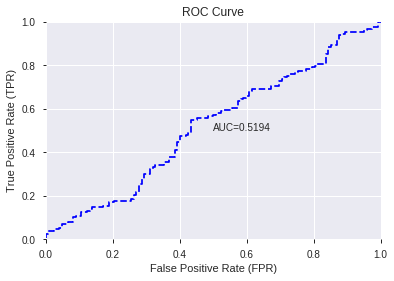

This function is available for GLM models only


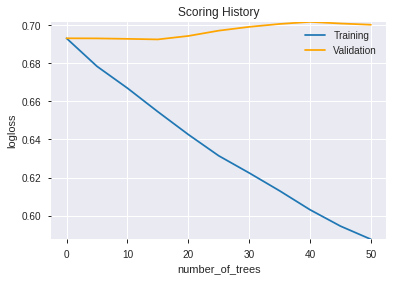

--2019-08-26 16:05:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.52|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_160514_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_160514_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CORREL_30',
 'HT_DCPERIOD',
 'SIN',
 'OBV',
 'AD',
 'CORREL_14',
 'COS',
 'CORREL_12',
 'CORREL_8',
 'day',
 'COSH',
 'weekday_name',
 'EXP',
 'SINH',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'CDLSHOOTINGSTAR',
 'CDLRICKSHAWMAN',
 'CDLHOMINGPIGEON',
 'CDLTHRUSTING']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [917] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_160536_model_4  0.563795  1.357793              0.483607  0.625748  0.391561
1  DeepLearning_grid_1_AutoML_20190826_160536_model_3  0.557822  0.711396              0.453361  0.507774  0.257835
2  DeepLearning_grid_1_AutoML_20190826_160536_model_2  0.544224  0.769426              0.479508  0.532598  0.283661
3  DeepLearning_grid_1_AutoML_20190826_160536_model_1  0.521985  1.902776              0.500000  0.628201  0.394637
4  DeepLearning_grid_1_AutoML_20190826_160536_model_6  0.520142  0.692742              0.500000  0.499797  0.249797
5  DeepLearning_grid_1_AutoML_20190826_160536_model_9  0.512708  0.693514              0.500000  0.500183  0.250183
6               DeepLearning_1_AutoML_20190826_160536  0.507943  0.690884              0.491803  0.499032  0.249033
7  DeepLearning_grid_1_AutoML_20190826_160536_model_5  0.500000  0.693075              0.500000  0.499964  0.249964
8  DeepLearning_grid_1_AutoML_20190826_160536_model_8  0.500000  0.693266              0.500000  0.500059  0.250059
9  DeepLearning_grid_1_AutoML_20190826_160536_model_7  0.473567  0.699543              0.500000  0.503177  0.253187

variable  relative_importance  scaled_importance  percentage
0          CDLGAPSIDESIDEWHITE             1.000000           1.000000    0.002136
1               CDL3BLACKCROWS             0.981580           0.981580    0.002096
2              CDLUNIQUE3RIVER             0.972516           0.972516    0.002077
3                    CDLINNECK             0.950084           0.950084    0.002029
4           CDLUPSIDEGAP2CROWS             0.937744           0.937744    0.002003
...                        ...                  ...                ...         ...
1038                   TRIMA_8             0.401925           0.401925    0.000858
1039             MINMAX_min_12             0.401102           0.401102    0.000857
1040    BBANDS_lowerband_8_2_4             0.400874           0.400874    0.000856
1041  BBANDS_middleband_24_7_4             0.400377           0.400377    0.000855
1042   BBANDS_upperband_24_2_5             0.390008           0.390008    0.000833

[1043 rows x 4 columns]

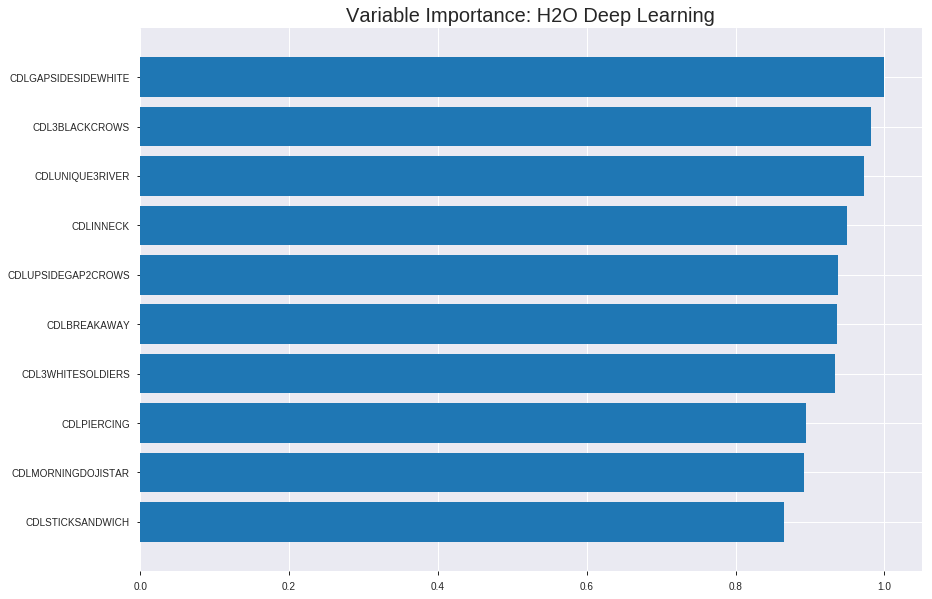

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_160536_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2520997687322302
RMSE: 0.502095378122753
LogLoss: 0.7453318116993184
Mean Per-Class Error: 0.3418614671279916
AUC: 0.7187668408350711
pr_auc: 0.7045777167019022
Gini: 0.4375336816701423
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07956921831760004: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      292  579   0.6648   (579.0/871.0)
1      72   810   0.0816   (72.0/882.0)
Total  364  1389  0.3714   (651.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0795692    0.713342  351
max f2                       0.0301551    0.840467  381
max f0point5                 0.388289     0.665612  205
max accuracy                 0.329301     0.65773   230
max precision                0.994816     1         0
max recall                   0.006873     1         396
max specificity              0.994816     1         0
max absolute_mcc             0.105079     0.322797  336
max min_per_class_accuracy   0.27304      0.649828  254
max mean_per_class_accuracy  0.329301     0.658139  230

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 33.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.972417           1.76669   1.76669            0.888889         0.985574   0.888889                    0.985574            0.0181406       0.0181406                  76.6692   76.6692
    2        0.0205362                   0.948405           1.98753   1.87711            1                0.957434   0.944444                    0.971504            0.0204082       0.0385488                  98.7528   87.711
    3        0.0302339                   0.919885           1.40296   1.72502            0.705882         0.931059   0.867925                    0.958531            0.0136054       0.0521542                  40.2961   72.5025
    4        0.040502                    0.902542           1.87711   1.76358            0.944444         0.911054   0.887324                    0.946495            0.0192744       0.0714286                  87.711    76.3581
    5        0.0501997                   0.877375           1.63679   1.73909            0.823529         0.894565   0.875                       0.936463            0.015873        0.0873016                  63.6788   73.9087
    6        0.100399                    0.767062           1.46806   1.60357            0.738636         0.818301   0.806818                    0.877382            0.0736961       0.160998                   46.8061   60.3574
    7        0.150029                    0.677982           1.39355   1.5341             0.701149         0.719408   0.771863                    0.825124            0.069161        0.230159                   39.3554   53.41
    8        0.200228                    0.609625           1.4003    1.50056            0.704545         0.645851   0.754986                    0.780178            0.0702948       0.300454                   40.0304   50.0556
    9        0.300057                    0.476124           1.35152   1.45097            0.68             0.536606   0.730038                    0.699142            0.134921        0.435374                   35.1519   45.0971
    10       0.399886                    0.362181           1.13573   1.37227            0.571429         0.414491   0.690442                    0.628081            0.113379        0.548753                   13.573    37.2273
    11       0.500285                    0.274594           1.00506   1.29858            0.505682         0.318367   0.653364                    0.565926            0.100907        0.64966                    0.505695  29.8579
    12       0.600114                    0.194535           1.0108    1.25071            0.508571         0.233295   0.629278                    0.510593            0.100907        0.750567                   1.08001   25.0707
    13       0.699943                    0.128601           0.897227  1.20029            0.451429         0.159361   0.603912                    0.460499            0.0895692       0.840136                   -10.2773  20.0292
    14       0.799772                    0.0746713          0.817726  1.15254            0.411429         0.10142    0.579886                    0.415678            0.0816327       0.921769                   -18.2274  15.254
    15       0.899601                    0.0376278          0.499721  1.0801             0.251429         0.0555847  0.543437                    0.375718            0.0498866       0.971655                   -50.0279  8.00963
    16       1                           0.00026449         0.282319  1                  0.142045         0.0190428  0.503137                    0.3



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3580543748468101
RMSE: 0.5983764491077587
LogLoss: 1.131154310945469
Mean Per-Class Error: 0.4681244421777381
AUC: 0.5007570444982787
pr_auc: 0.4980616675348912
Gini: 0.0015140889965574722
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0019452657734803653: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    251  0.9921   (251.0/253.0)
1      0    248  0        (0.0/248.0)
Total  2    499  0.501    (251.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00194527   0.663989   397
max f2                       0.00194527   0.831657   397
max f0point5                 0.00829917   0.556586   388
max accuracy                 0.590748     0.53493    87
max precision                0.990162     1          0
max recall                   0.00194527   1          397
max specificity              0.990162     1          0
max absolute_mcc             0.590748     0.0812093  87
max min_per_class_accuracy   0.214084     0.495968   223
max mean_per_class_accuracy  0.582163     0.531876   89

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 30.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.938112           1.01008   1.01008            0.5              0.958352   0.5                         0.958352            0.0120968       0.0120968                  1.00806   1.00806
    2        0.0219561                   0.919557           0.404032  0.734604           0.2              0.92852    0.363636                    0.944792            0.00403226      0.016129                   -59.5968  -26.5396
    3        0.0319361                   0.900201           1.61613   1.01008            0.8              0.911442   0.5                         0.93437             0.016129        0.0322581                  61.6129   1.00806
    4        0.0419162                   0.889577           0.808065  0.961982           0.4              0.894484   0.47619                     0.924873            0.00806452      0.0403226                  -19.1935  -3.80184
    5        0.0518962                   0.868411           1.61613   1.08778            0.8              0.879931   0.538462                    0.916231            0.016129        0.0564516                  61.6129   8.77792
    6        0.101796                    0.749005           0.646452  0.871442           0.32             0.818084   0.431373                    0.868119            0.0322581       0.0887097                  -35.3548  -12.8558
    7        0.151697                    0.656592           1.61613   1.1164             0.8              0.700221   0.552632                    0.812889            0.0806452       0.169355                   61.6129   11.6405
    8        0.201597                    0.563078           1.13129   1.12009            0.56             0.619362   0.554455                    0.764987            0.0564516       0.225806                   13.129    12.0089
    9        0.301397                    0.419173           0.686855  0.976634           0.34             0.484003   0.483444                    0.671946            0.0685484       0.294355                   -31.3145  -2.33657
    10       0.401198                    0.28628            0.929274  0.964853           0.46             0.346723   0.477612                    0.591044            0.0927419       0.387097                   -7.07258  -3.51468
    11       0.500998                    0.210085           1.09089   0.98996            0.54             0.242624   0.49004                     0.521638            0.108871        0.495968                   9.08871   -1.00405
    12       0.600798                    0.152593           0.969677  0.98659            0.48             0.179394   0.488372                    0.464787            0.0967742       0.592742                   -3.03226  -1.34096
    13       0.700599                    0.103277           1.01008   0.989937           0.5              0.12483    0.490028                    0.41636             0.100806        0.693548                   1.00806   -1.00634
    14       0.800399                    0.0690978          1.05048   0.997486           0.52             0.0853863  0.493766                    0.375091            0.104839        0.798387                   5.04839   -0.251388
    15       0.9002                      0.0278054          1.05048   1.00336            0.52             0.0481425  0.496674                    0.338844            0.104839        0.903226                   5.04839   0.336171
    16       1                           0.000150984        0.969677  1                  0.48             0.0110798  0.49501         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 16:13:48  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 16:13:53  7.516 sec         148 obs/sec       0.39247   1             688        0.666039         2.69277             -0.774501      0.518185        0.510625           0.883346         0.496863                         0.636968           1.61363               -0.623075        0.506654          0.502619             1.68347            0.50499
    2019-08-26 16:14:21  35.832 sec        156 obs/sec       2.68568   7             4708       0.609241         1.63667             -0.484759      0.596792        0.604793           1.43544          0.496863                         0.670559           2.37618               -0.798779        0.520472          0.518709             1.68347            0.499002
    2019-08-26 16:14:50  1 min  4.669 sec  166 obs/sec       5.33029   14            9344       0.563868         1.13599             -0.271841      0.610911        0.56605            1.54586          0.447804                         0.635573           1.55411               -0.615974        0.488182          0.490894             1.01008            0.502994
    2019-08-26 16:15:18  1 min 32.297 sec  173 obs/sec       8.01711   21            14054      0.604558         1.72895             -0.46202       0.597823        0.638049           1.98753          0.496863                         0.664406           2.25684               -0.765919        0.520847          0.513134             1.01008            0.49501
    2019-08-26 16:15:48  2 min  1.984 sec  179 obs/sec       11.0662   29            19399      0.502095         0.745332            -0.00843878    0.718767        0.704578           1.76669          0.371363                         0.598376           1.13115               -0.43236         0.500757          0.498062             1.01008            0.500998
    2019-08-26 16:16:16  2 min 30.608 sec  184 obs/sec       14.0953   37            24709      0.526163         0.888876            -0.107432      0.723559        0.73626            1.98753          0.357673                         0.646134           1.49101               -0.670122        0.478261          0.471155             0.336694           0.497006
    2019-08-26 16:16:44  2 min 59.032 sec  189 obs/sec       17.1683   45            30096      0.528059         0.993519            -0.115428      0.713135        0.66245            1.65627          0.346264                         0.604882           1.16086               -0.463676        0.490302          0.488637             1.34677            0.502994
    2019-08-26 16:17:18  3 min 32.594 sec  193 obs/sec       20.9755   55            36770      0.459104         0.667295            0.156861       0.772254        0.77654            1.87711          0.297205                         0.600713           1.19458               -0.443567        0.507786          0.509569             1.34677            0.499002
    2019-08-26 16:17:48  

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLGAPSIDESIDEWHITE       1.0                    1.0                  0.002135814125251552
CDL3BLACKCROWS            0.9815800189971924     0.9815800189971924   0.00209647246963889
CDLUNIQUE3RIVER           0.9725161790847778     0.9725161790847778   0.0020771137923249364
CDLINNECK                 0.9500835537910461     0.9500835537910461   0.0020292018743561092
CDLUPSIDEGAP2CROWS        0.9377439022064209     0.9377439022064209   0.0020028466722009836
---                       ---                    ---                  ---
TRIMA_8                   0.40192484855651855    0.40192484855651855  0.0008584367688366032
MINMAX_min_12             0.40110212564468384    0.40110212564468384  0.0008566795856203385
BBANDS_lowerband_8_2_4    0.4008738696575165     0.4008738696575165   0.0008561920732587732
BBANDS_middleband_24_7_4  0.4003773331642151     0.4003773331642151   0.0008551315636026772
BBANDS_upperband_24_2_5   0.39000821113586426    0.39000821113586426  0.0008329850463080684


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5856573705179283)

('F1', 0.6861702127659575)

('auc', 0.5637946371838862)

('logloss', 1.357793138182035)

('mean_per_class_error', 0.4200025416190114)

('rmse', 0.6257481014426358)

('mse', 0.3915606864590633)

deeplearning prediction progress: |███████████████████████████████████████| 100%


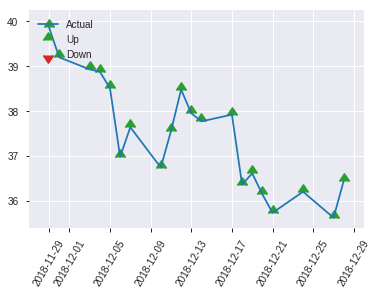


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3915606864590633
RMSE: 0.6257481014426358
LogLoss: 1.357793138182035
Mean Per-Class Error: 0.4200025416190114
AUC: 0.5637946371838862
pr_auc: 0.5564922202134928
Gini: 0.12758927436777245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00429075872355473: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    118  0.9672   (118.0/122.0)
1      0    129  0        (0.0/129.0)
Total  4    247  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00429076   0.68617   246
max f2                       0.00429076   0.845347  246
max f0point5                 0.027401     0.60355   178
max accuracy                 0.02791      0.585657  176
max precision                0.642797     0.785714  13
max recall                   0.00429076   1         246
max specificity              0.86891      0.991803  0
max absolute_mcc             0.027401     0.176311  178
max min_per_class_accuracy   0.0775468    0.54918   125
max mean_per_class_accuracy  0.02791      0.579997  176

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 17.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.816328           0.648579  0.648579           0.333333         0.83877     0.333333                    0.83877             0.00775194      0.00775194                 -35.1421  -35.1421
    2        0.0239044                   0.750162           1.29716   0.972868           0.666667         0.778806    0.5                         0.808788            0.0155039       0.0232558                  29.7158   -2.71318
    3        0.0318725                   0.727508           1.94574   1.21609            1                0.745536    0.625                       0.792975            0.0155039       0.0387597                  94.5736   21.6085
    4        0.0438247                   0.687494           1.94574   1.41508            1                0.696724    0.727273                    0.766725            0.0232558       0.0620155                  94.5736   41.5081
    5        0.0517928                   0.643015           1.94574   1.49672            1                0.644946    0.769231                    0.74799             0.0155039       0.0775194                  94.5736   49.672
    6        0.103586                    0.515865           1.0477    1.27221            0.538462         0.558879    0.653846                    0.653434            0.0542636       0.131783                   4.77042   27.2212
    7        0.151394                    0.398563           0.486434  1.02407            0.25             0.456908    0.526316                    0.591373            0.0232558       0.155039                   -51.3566  2.40718
    8        0.203187                    0.330203           1.0477    1.0301             0.538462         0.366278    0.529412                    0.533996            0.0542636       0.209302                   4.77042   3.00958
    9        0.302789                    0.223718           1.16744   1.07528            0.6              0.273829    0.552632                    0.448415            0.116279        0.325581                   16.7442   7.52754
    10       0.40239                     0.125128           0.933953  1.04029            0.48             0.171862    0.534653                    0.379961            0.0930233       0.418605                   -6.60465  4.02947
    11       0.501992                    0.0775468          1.3231    1.09641            0.68             0.0957684   0.563492                    0.323574            0.131783        0.550388                   32.3101   9.6407
    12       0.601594                    0.0488884          1.08961   1.09528            0.56             0.0620349   0.562914                    0.280273            0.108527        0.658915                   8.96124   9.52821
    13       0.701195                    0.0313497          1.16744   1.10553            0.6              0.0408145   0.568182                    0.246259            0.116279        0.775194                   16.7442   10.5532
    14       0.800797                    0.0158393          0.700465  1.05515            0.36             0.0225946   0.542289                    0.21844             0.0697674       0.844961                   -29.9535  5.51506
    15       0.900398                    0.00961419         0.933953  1.04174            0.48             0.0129047   0.535398                    0.195704            0.0930233       0.937984                   -6.60465  4.17438
    16       1                           0.000208452        0.622636  1                  0.32             0.00589116  0.513944 

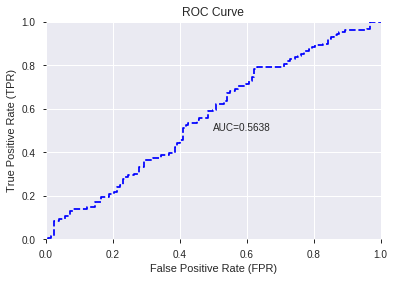

This function is available for GLM models only


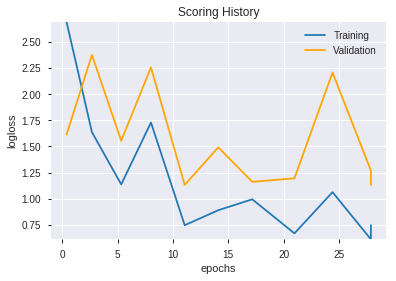

--2019-08-26 16:38:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_160536_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_160536_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLGAPSIDESIDEWHITE',
 'CDL3BLACKCROWS',
 'CDLUNIQUE3RIVER',
 'CDLINNECK',
 'CDLUPSIDEGAP2CROWS',
 'CDLBREAKAWAY',
 'CDL3WHITESOLDIERS',
 'CDLPIERCING',
 'CDLMORNINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'CDLLADDERBOTTOM',
 'TANH',
 'CDLTHRUSTING',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLMATCHINGLOW',
 'is_quarter_start',
 'CDLSTALLEDPATTERN',
 'CDLADVANCEBLOCK',
 'CDLHOMINGPIGEON',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI',
 'COSH',
 'CDLDRAGONFLYDOJI',
 'EXP',
 'SINH',
 'CDLDARKCLOUDCOVER',
 'CDLGRAVESTONEDOJI',
 'is_quarter_end',
 'CDLINVERTEDHAMMER',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLXSIDEGAP3METHODS',
 'CDLTASUKIGAP',
 'CDL3INSIDE',
 'dayofweek',
 'is_month_end',
 'day',
 'SIN',
 'is_month_start',
 'CDLDOJI',
 'weekday',
 'CORREL_14',
 'COS',
 'weekday_name',
 'CDLLONGLEGGEDDOJI',
 'STOCHRSI_fastk',
 'CDLRICKSHAWMAN',
 'ADXR_14',
 'SUB',
 'days_in_month',
 'CORREL_20',
 'ADX_14',
 'SAREXT',
 'CORREL_12',
 'CDL3OUTSIDE',
 'BETA_1

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_163828_model_1  0.501716  0.697137              0.495902  0.501987  0.251991

variable  relative_importance  scaled_importance    percentage
0           CDLSEPARATINGLINES         1.193185e-02       1.000000e+00  1.257163e-02
1                          day         1.065493e-02       8.929825e-01  1.122624e-02
2          CDLXSIDEGAP3METHODS         1.050920e-02       8.807686e-01  1.107269e-02
3           CDLCLOSINGMARUBOZU         9.245710e-03       7.748767e-01  9.741460e-03
4              CDLADVANCEBLOCK         9.067737e-03       7.599609e-01  9.553945e-03
...                        ...                  ...                ...           ...
1038   BBANDS_upperband_20_0_5         3.081055e-07       2.582212e-05  3.246260e-07
1039   BBANDS_lowerband_30_7_2         2.894001e-07       2.425443e-05  3.049176e-07
1040  BBANDS_middleband_24_3_4         1.610715e-07       1.349929e-05  1.697081e-07
1041                      mama         6.010166e-08       5.037079e-06  6.332428e-08
1042   BBANDS_middleband_8_2_4         5.092204e-09       4.267742e-07  5.365246e-09

[1043 rows x 4 columns]

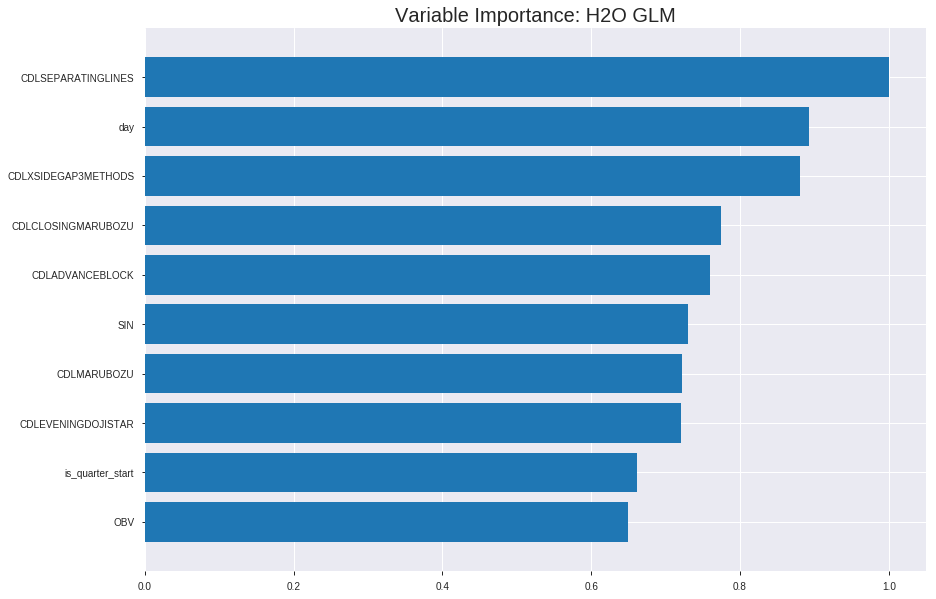

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_163828_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24534016393917765
RMSE: 0.49531824511033073
LogLoss: 0.6837823297094041
Null degrees of freedom: 1752
Residual degrees of freedom: 709
Null deviance: 2430.1049900608095
Residual deviance: 2397.3408479611703
AIC: 4485.34084796117
AUC: 0.5996300548539355
pr_auc: 0.5945025498978221
Gini: 0.199260109707871
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4303563266878682: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      40   831   0.9541   (831.0/871.0)
1      13   869   0.0147   (13.0/882.0)
Total  53   1700  0.4815   (844.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430356     0.673122  365
max f2                       0.393775     0.836177  392
max f0point5                 0.490831     0.58753   237
max accuracy                 0.490831     0.572732  237
max precision                0.607857     1         0
max recall                   0.393775     1         392
max specificity              0.607857     1         0
max absolute_mcc             0.490831     0.156922  237
max min_per_class_accuracy   0.50705      0.569161  178
max mean_per_class_accuracy  0.50622      0.571528  182

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 50.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.568197           1.54586   1.54586            0.777778         0.58268   0.777778                    0.58268             0.015873        0.015873                   54.5855   54.5855
    2        0.0205362                   0.560314           1.43544   1.49065            0.722222         0.563397  0.75                        0.573038            0.0147392       0.0306122                  43.5437   49.0646
    3        0.0302339                   0.556217           0.935307  1.31252            0.470588         0.557693  0.660377                    0.568116            0.00907029      0.0396825                  -6.46925  31.2519
    4        0.040502                    0.551984           1.76669   1.42766            0.888889         0.554172  0.71831                     0.564581            0.0181406       0.0578231                  76.6692   42.7661
    5        0.0501997                   0.548849           1.40296   1.42289            0.705882         0.550404  0.715909                    0.561842            0.0136054       0.0714286                  40.2961   42.289
    6        0.100399                    0.537984           1.30996   1.36643            0.659091         0.542301  0.6875                      0.552072            0.0657596       0.137188                   30.9962   36.6426
    7        0.150029                    0.532347           1.1651    1.29983            0.586207         0.534787  0.653992                    0.546354            0.0578231       0.195011                   16.5103   29.9828
    8        0.200228                    0.528128           1.26479   1.29104            0.636364         0.530259  0.649573                    0.542319            0.0634921       0.258503                   26.4791   29.1044
    9        0.300057                    0.521024           0.954014  1.17891            0.48             0.524334  0.593156                    0.536335            0.0952381       0.353741                   -4.59864  17.8914
    10       0.399886                    0.514243           1.07894   1.15396            0.542857         0.517719  0.580599                    0.531688            0.10771         0.461451                   7.8944    15.3957
    11       0.500285                    0.506987           1.07281   1.13767            0.539773         0.51055   0.572406                    0.527446            0.10771         0.569161                   7.28136   13.7673
    12       0.600114                    0.499502           0.965371  1.10901            0.485714         0.503217  0.557985                    0.523415            0.0963719       0.665533                   -3.46291  10.9011
    13       0.699943                    0.491519           1.04487   1.09986            0.525714         0.495681  0.553382                    0.51946             0.104308        0.769841                   4.4872    9.98629
    14       0.799772                    0.479709           0.829083  1.06606            0.417143         0.485528  0.536377                    0.515224            0.0827664       0.852608                   -17.0917  6.60637
    15       0.899601                    0.462766           0.71551   1.02716            0.36             0.47239   0.516804                    0.510471            0.0714286       0.924036                   -28.449   2.71627
    16       1                           0.372296           0.756616  1                  0.380682         0.437428  0.503137                    0.503137          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24978489928889241
RMSE: 0.4997848530006611
LogLoss: 0.6927243532940243
Null degrees of freedom: 500
Residual degrees of freedom: -543
Null deviance: 694.6159526243423
Residual deviance: 694.1098020006123
AIC: 2782.109802000612
AUC: 0.5218028815504272
pr_auc: 0.5275812392304237
Gini: 0.0436057631008544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40793251158321303: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    253  1        (253.0/253.0)
1      0    248  0        (0.0/248.0)
Total  0    501  0.505    (253.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407933     0.662216  399
max f2                       0.407933     0.830543  399
max f0point5                 0.444853     0.553241  378
max accuracy                 0.481929     0.53493   194
max precision                0.54756      1         0
max recall                   0.407933     1         399
max specificity              0.54756      1         0
max absolute_mcc             0.520609     0.101095  16
max min_per_class_accuracy   0.480905     0.524194  201
max mean_per_class_accuracy  0.476952     0.535302  217

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 48.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.52694            1.34677   1.34677            0.666667         0.535601  0.666667                    0.535601            0.016129        0.016129                   34.6774   34.6774
    2        0.0219561                   0.523467           1.61613   1.46921            0.8              0.525     0.727273                    0.530782            0.016129        0.0322581                  61.6129   46.9208
    3        0.0319361                   0.521127           1.61613   1.51512            0.8              0.521999  0.75                        0.528037            0.016129        0.0483871                  61.6129   51.5121
    4        0.0419162                   0.518364           0.808065  1.34677            0.4              0.518923  0.666667                    0.525867            0.00806452      0.0564516                  -19.1935  34.6774
    5        0.0518962                   0.514578           1.2121    1.32087            0.6              0.515444  0.653846                    0.523863            0.0120968       0.0685484                  21.2097   32.0875
    6        0.101796                    0.509283           0.969677  1.14872            0.48             0.51154   0.568627                    0.517822            0.0483871       0.116935                   -3.03226  14.8719
    7        0.151697                    0.505774           0.888871  1.06324            0.44             0.5075    0.526316                    0.514427            0.0443548       0.16129                    -11.1129  6.32428
    8        0.201597                    0.501323           1.2121    1.10009            0.6              0.503508  0.544554                    0.511724            0.0604839       0.221774                   21.2097   10.0088
    9        0.301397                    0.494147           1.01008   1.07028            0.5              0.497309  0.529801                    0.506951            0.100806        0.322581                   1.00806   7.02841
    10       0.401198                    0.48671            1.05048   1.06536            0.52             0.490556  0.527363                    0.502873            0.104839        0.427419                   5.04839   6.53587
    11       0.500998                    0.480475           0.969677  1.0463             0.48             0.483715  0.517928                    0.499056            0.0967742       0.524194                   -3.03226  4.62987
    12       0.600798                    0.472967           0.929274  1.02686            0.46             0.476128  0.508306                    0.495248            0.0927419       0.616935                   -7.07258  2.68594
    13       0.700599                    0.467272           0.686855  0.978426           0.34             0.470175  0.48433                     0.491676            0.0685484       0.685484                   -31.3145  -2.15743
    14       0.800399                    0.460989           1.09089   0.992448           0.54             0.463982  0.491272                    0.488223            0.108871        0.794355                   9.08871   -0.755169
    15       0.9002                      0.451879           1.01008   0.994403           0.5              0.457067  0.492239                    0.484769            0.100806        0.895161                   1.00806   -0.559688
    16       1                           0.407933           1.05048   1                  0.52             0.440311  0.49501                     0.480332    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 16:38:32  0.000 sec   2            3         1044          1.37103           1.38556
    2019-08-26 16:38:34  1.991 sec   4            2.2       1044          1.36756           1.38545
    2019-08-26 16:38:36  4.015 sec   6            1.6       1044          1.36346           1.38546
    2019-08-26 16:38:38  6.035 sec   8            1.2       1044          1.35866           1.38575
    2019-08-26 16:38:41  9.263 sec   10           0.84      1044          1.3532            1.38648
    2019-08-26 16:38:43  11.256 sec  12           0.61      1044          1.34716           1.38792
    2019-08-26 16:38:45  13.245 sec  14           0.44      1044          1.34068           1.39031

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5338645418326693)

('F1', 0.6807387862796834)

('auc', 0.5017155928326344)

('logloss', 0.6971372808700412)

('mean_per_class_error', 0.4719468801626636)

('rmse', 0.5019867262068692)

('mse', 0.2519906732878903)

glm prediction progress: |████████████████████████████████████████████████| 100%


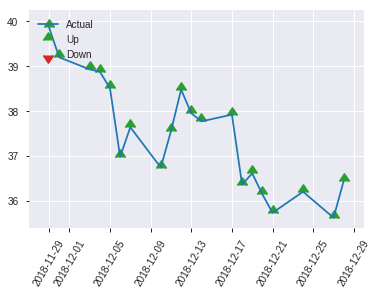


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2519906732878903
RMSE: 0.5019867262068692
LogLoss: 0.6971372808700412
Null degrees of freedom: 250
Residual degrees of freedom: -793
Null deviance: 347.88191742869697
Residual deviance: 349.9629149967607
AIC: 2437.9629149967604
AUC: 0.5017155928326344
pr_auc: 0.5104144714889269
Gini: 0.003431185665268899
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4249403231266746: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    121  0.9918   (121.0/122.0)
1      0    129  0        (0.0/129.0)
Total  1    250  0.4821   (121.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42494      0.680739  249
max f2                       0.42494      0.842037  249
max f0point5                 0.441871     0.575673  236
max accuracy                 0.461268     0.533865  177
max precision                0.497827     0.608696  22
max recall                   0.42494      1         249
max specificity              0.541429     0.991803  0
max absolute_mcc             0.477193     0.112178  96
max min_per_class_accuracy   0.4702       0.47541   125
max mean_per_class_accuracy  0.461268     0.528053  177

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 47.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.511697           0.648579  0.648579           0.333333         0.527727  0.333333                    0.527727            0.00775194      0.00775194                 -35.1421  -35.1421
    2        0.0239044                   0.509697           0.648579  0.648579           0.333333         0.510377  0.333333                    0.519052            0.00775194      0.0155039                  -35.1421  -35.1421
    3        0.0318725                   0.507206           0.972868  0.729651           0.5              0.508509  0.375                       0.516416            0.00775194      0.0232558                  -2.71318  -27.0349
    4        0.0438247                   0.502011           0.648579  0.707541           0.333333         0.503523  0.363636                    0.5129              0.00775194      0.0310078                  -35.1421  -29.2459
    5        0.0517928                   0.501081           0.972868  0.74836            0.5              0.501509  0.384615                    0.511148            0.00775194      0.0387597                  -2.71318  -25.164
    6        0.103586                    0.497471           1.34705   1.0477             0.692308         0.499058  0.538462                    0.505103            0.0697674       0.108527                   34.7048   4.77042
    7        0.151394                    0.49385            1.29716   1.12648            0.666667         0.495985  0.578947                    0.502223            0.0620155       0.170543                   29.7158   12.6479
    8        0.203187                    0.490465           1.0477    1.1064             0.538462         0.491473  0.568627                    0.499483            0.0542636       0.224806                   4.77042   10.6399
    9        0.302789                    0.481926           0.778295  0.99847            0.4              0.486024  0.513158                    0.495056            0.0775194       0.302326                   -22.1705  -0.152999
    10       0.40239                     0.475957           0.544806  0.886177           0.28             0.478881  0.455446                    0.491052            0.0542636       0.356589                   -45.5194  -11.3823
    11       0.501992                    0.4702             1.24527   0.957426           0.64             0.472767  0.492063                    0.487424            0.124031        0.48062                    24.5271   -4.25741
    12       0.601594                    0.466469           1.3231    1.01797            0.68             0.468563  0.523179                    0.484301            0.131783        0.612403                   32.3101   1.79681
    13       0.701195                    0.461576           1.08961   1.02814            0.56             0.463929  0.528409                    0.481408            0.108527        0.72093                    8.96124   2.81448
    14       0.800797                    0.455489           0.933953  1.01643            0.48             0.458175  0.522388                    0.478518            0.0930233       0.813953                   -6.60465  1.64295
    15       0.900398                    0.447106           0.856124  0.998697           0.44             0.452041  0.513274                    0.475589            0.0852713       0.899225                   -14.3876  -0.130342
    16       1                           0.411536           1.01178   1                  0.52             0.438644  0.513944                    0.47190

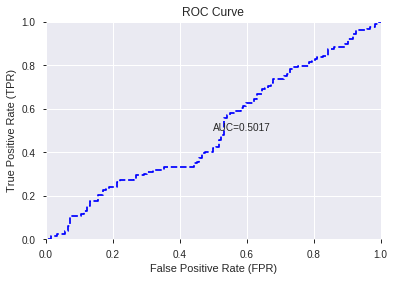

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


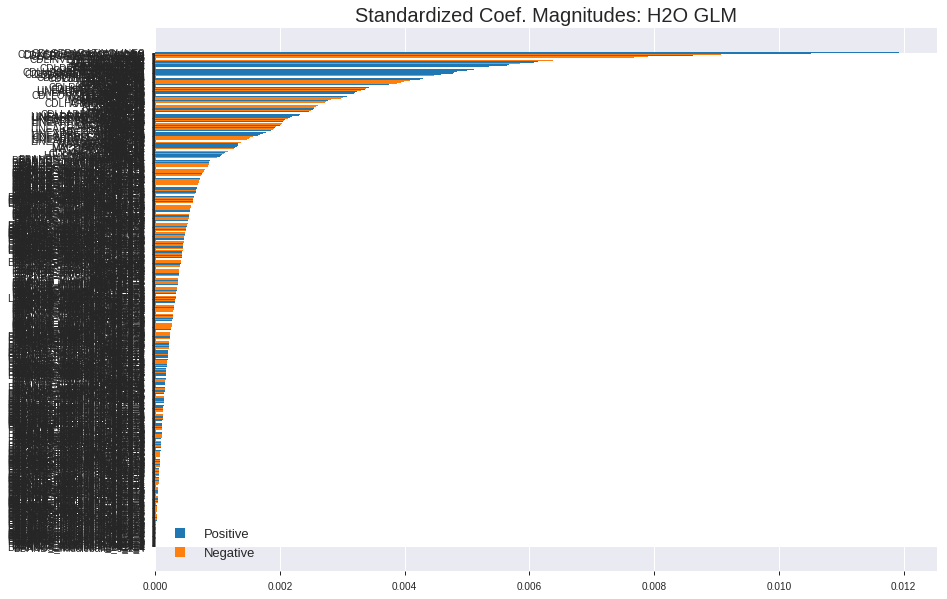

'log_likelihood'
--2019-08-26 16:39:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.135.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.135.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_163828_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_163828_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLSEPARATINGLINES',
 'day',
 'CDLXSIDEGAP3METHODS',
 'CDLCLOSINGMARUBOZU',
 'CDLADVANCEBLOCK',
 'SIN',
 'CDLMARUBOZU',
 'CDLEVENINGDOJISTAR',
 'is_quarter_start',
 'OBV',
 'CORREL_30',
 'MFI_12',
 'CDLINVERTEDHAMMER',
 'TANH',
 'CDLTHRUSTING',
 'EXP',
 'COSH',
 'SINH',
 'CDLHIGHWAVE',
 'aroonup_20',
 'AROONOSC_14',
 'CDLDOJISTAR',
 'days_in_month',
 'is_month_start',
 'TAN',
 'is_month_end',
 'AROONOSC_20',
 'aroonup_24',
 'aroondown_14',
 'aroonup_14',
 'CDLSHORTLINE',
 'ADX_24',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCHRSI_fastd',
 'BOP',
 'CDLEVENINGSTAR',
 'VAR_24',
 'is_quarter_end',
 'CDLUPSIDEGAP2CROWS',
 'ADX_20',
 'CDLUNIQUE3RIVER',
 'VAR_8',
 'AD',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'ADX_14',
 'CDLSTICKSANDWICH',
 'PLUS_DI_30',
 'ADX_12',
 'CDL3WHITESOLDIERS',
 'PLUS_DI_24',
 'CDLBREAKAWAY',
 'CDL3BLACKCROWS',
 'CDLINNECK',
 'CDLHARAMI',
 'PLUS_DI_20',
 'weekday_name',
 'PLUS_DM_30',
 'PLUS_DM_24',
 'Volume',
 'MFI_8',
 'aroondown_20',
 'PLUS_DI_14',
 'CCI_8',

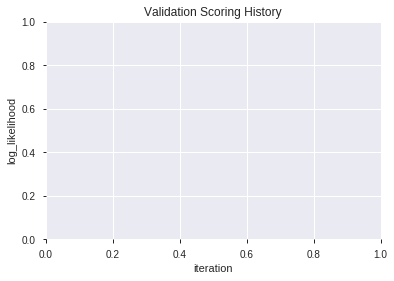

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_163910_model_3  0.498475  0.708491              0.491803  0.507406  0.257461
1  XGBoost_grid_1_AutoML_20190826_163910_model_4  0.496696  0.699949              0.474965  0.503364  0.253376
2  XGBoost_grid_1_AutoML_20190826_163910_model_6  0.495870  0.708638              0.483607  0.507517  0.257574
3  XGBoost_grid_1_AutoML_20190826_163910_model_1  0.495647  0.709019              0.500000  0.507596  0.257653
4               XGBoost_3_AutoML_20190826_163910  0.492756  0.706675              0.500000  0.506496  0.256538
5  XGBoost_grid_1_AutoML_20190826_163910_model_5  0.487038  0.735853              0.491803  0.519191  0.269559
6  XGBoost_grid_1_AutoML_20190826_163910_model_7  0.470200  0.728231              0.483607  0.516689  0.266968
7  XGBoost_grid_1_AutoML_20190826_163910_model_2  0.467849  0.712638              0.500000  0.509423  0.259511
8               XGBoost_1_AutoML_20190826_163910  0.458190  0.735827              0.487705  0.519880  0.270275
9               XGBoost_2_AutoML_20190826_163910  0.440590  0.743399              0.500000  0.523405  0.273953

variable  relative_importance  scaled_importance  percentage
0                     MFI_24            89.333817           1.000000    0.015653
1                    BETA_20            88.172203           0.986997    0.015449
2                HT_DCPERIOD            78.053696           0.873731    0.013676
3             STOCHRSI_fastd            76.472076           0.856026    0.013399
4       HT_PHASOR_quadrature            76.457558           0.855864    0.013397
..                       ...                  ...                ...         ...
298  BBANDS_upperband_24_7_3             1.579975           0.017686    0.000277
299  BBANDS_lowerband_12_6_5             1.558894           0.017450    0.000273
300  BBANDS_lowerband_12_1_4             1.076355           0.012049    0.000189
301  BBANDS_lowerband_20_1_4             0.984054           0.011015    0.000172
302               aroonup_24             0.204193           0.002286    0.000036

[303 rows x 4 columns]

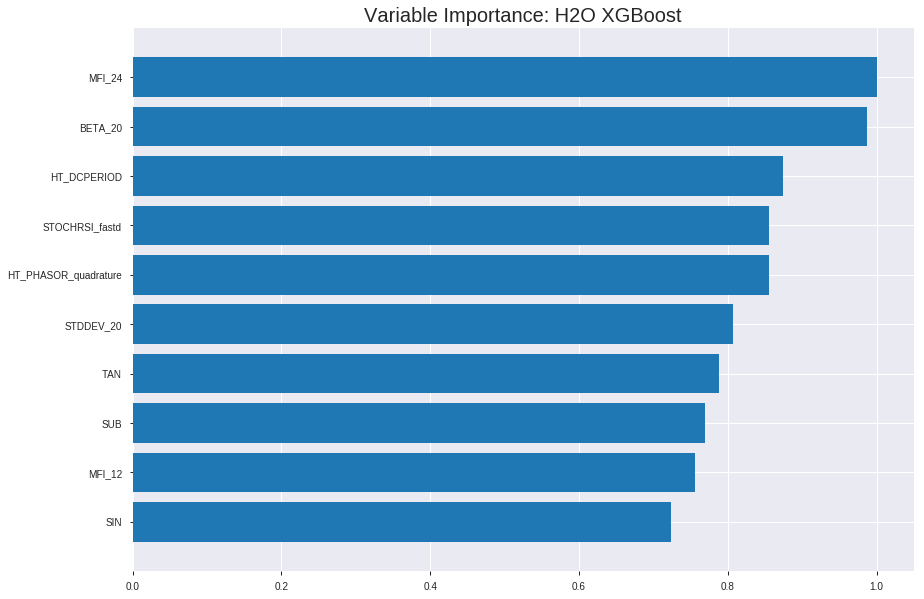

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_163910_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17792737521566382
RMSE: 0.42181438478987865
LogLoss: 0.5443070678353257
Mean Per-Class Error: 0.14053685002512295
AUC: 0.9378402336824512
pr_auc: 0.9363160956001846
Gini: 0.8756804673649023
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4896051064133644: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      718  153  0.1757   (153.0/871.0)
1      93   789  0.1054   (93.0/882.0)
Total  811  942  0.1403   (246.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489605     0.865132  216
max f2                       0.451334     0.915916  250
max f0point5                 0.527823     0.876489  180
max accuracy                 0.490694     0.859669  215
max precision                0.84003      1         0
max recall                   0.348019     1         341
max specificity              0.84003      1         0
max absolute_mcc             0.489605     0.720899  216
max min_per_class_accuracy   0.502006     0.857143  203
max mean_per_class_accuracy  0.490694     0.859463  215

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 50.28 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.768169           1.98753    1.98753            1                0.799457  1                           0.799457            0.0204082       0.0204082                  98.7528   98.7528
    2        0.0205362                   0.739646           1.98753    1.98753            1                0.75185   1                           0.775653            0.0204082       0.0408163                  98.7528   98.7528
    3        0.0302339                   0.722706           1.98753    1.98753            1                0.730821  1                           0.761273            0.0192744       0.0600907                  98.7528   98.7528
    4        0.040502                    0.711432           1.98753    1.98753            1                0.717519  1                           0.750181            0.0204082       0.0804989                  98.7528   98.7528
    5        0.0501997                   0.70062            1.98753    1.98753            1                0.70649   1                           0.74174             0.0192744       0.0997732                  98.7528   98.7528
    6        0.100399                    0.656162           1.96494    1.97624            0.988636         0.674821  0.994318                    0.708281            0.0986395       0.198413                   96.4943   97.6236
    7        0.150029                    0.629636           1.94184    1.96486            0.977011         0.642991  0.988593                    0.686683            0.0963719       0.294785                   94.1838   96.4857
    8        0.200228                    0.604294           1.89719    1.94789            0.954545         0.616225  0.980057                    0.669018            0.0952381       0.390023                   89.7186   94.7891
    9        0.300057                    0.569003           1.7831     1.89306            0.897143         0.585613  0.952471                    0.641269            0.178005        0.568027                   78.3097   89.3064
    10       0.399886                    0.538061           1.59002    1.81741            0.8              0.553465  0.914408                    0.61935             0.15873         0.726757                   59.0023   81.7412
    11       0.500285                    0.502158           1.28738    1.71104            0.647727         0.519328  0.860889                    0.599277            0.129252        0.856009                   28.7376   71.1042
    12       0.600114                    0.467434           0.863155   1.57               0.434286         0.484504  0.789924                    0.580184            0.0861678       0.942177                   -13.6845  56.9996
    13       0.699943                    0.430687           0.408863   1.40439            0.205714         0.449528  0.706601                    0.56155             0.0408163       0.982993                   -59.1137  40.439
    14       0.799772                    0.393654           0.113573   1.24327            0.0571429        0.411592  0.625535                    0.542832            0.0113379       0.994331                   -88.6427  24.3268
    15       0.899601                    0.350491           0.0454292  1.11034            0.0228571        0.372456  0.558656                    0.523925            0.00453515      0.998866                   -95.4571  11.0344
    16       1                           0.206665           0.0112928  1                  0.00568182       0.313284  0.503137                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25138333164291266
RMSE: 0.5013814233125442
LogLoss: 0.6963303957267967
Mean Per-Class Error: 0.455509690169578
AUC: 0.5407768073441285
pr_auc: 0.5388054487333099
Gini: 0.08155361468825695
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2556598484516144: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    251  0.9921   (251.0/253.0)
1      0    248  0        (0.0/248.0)
Total  2    499  0.501    (251.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25566      0.663989  397
max f2                       0.25566      0.831657  397
max f0point5                 0.385016     0.559006  328
max accuracy                 0.526796     0.546906  107
max precision                0.696434     1         0
max recall                   0.25566      1         397
max specificity              0.696434     1         0
max absolute_mcc             0.526796     0.101745  107
max min_per_class_accuracy   0.474163     0.521739  196
max mean_per_class_accuracy  0.526796     0.54449   107

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 47.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.667694           1.34677   1.34677            0.666667         0.684899  0.666667                    0.684899            0.016129        0.016129                   34.6774   34.6774
    2        0.0219561                   0.655607           1.2121    1.28556            0.6              0.66173   0.636364                    0.674368            0.0120968       0.0282258                  21.2097   28.5557
    3        0.0319361                   0.623776           1.61613   1.38886            0.8              0.628799  0.6875                      0.660128            0.016129        0.0443548                  61.6129   38.8861
    4        0.0419162                   0.614535           0.808065  1.25058            0.4              0.619124  0.619048                    0.650365            0.00806452      0.0524194                  -19.1935  25.0576
    5        0.0518962                   0.608073           1.2121    1.24318            0.6              0.611511  0.615385                    0.642893            0.0120968       0.0645161                  21.2097   24.3176
    6        0.101796                    0.566673           1.05048   1.14872            0.52             0.589178  0.568627                    0.616562            0.0524194       0.116935                   5.04839   14.8719
    7        0.151697                    0.547716           1.13129   1.14299            0.56             0.558935  0.565789                    0.597606            0.0564516       0.173387                   13.129    14.2986
    8        0.201597                    0.535454           1.05048   1.12009            0.52             0.542009  0.554455                    0.583844            0.0524194       0.225806                   5.04839   12.0089
    9        0.301397                    0.511416           1.17169   1.13718            0.58             0.526036  0.562914                    0.564702            0.116935        0.342742                   17.1694   13.7177
    10       0.401198                    0.490461           0.888871  1.07541            0.44             0.501708  0.532338                    0.549032            0.0887097       0.431452                   -11.1129  7.54092
    11       0.500998                    0.474102           0.929274  1.0463             0.46             0.48104   0.517928                    0.535488            0.0927419       0.524194                   -7.07258  4.62987
    12       0.600798                    0.452201           0.969677  1.03357            0.48             0.463108  0.511628                    0.523465            0.0967742       0.620968                   -3.03226  3.35709
    13       0.700599                    0.424752           1.2121    1.059              0.6              0.4387    0.524217                    0.51139             0.120968        0.741935                   21.2097   5.90019
    14       0.800399                    0.397036           0.727258  1.01764            0.36             0.411003  0.503741                    0.498873            0.0725806       0.814516                   -27.2742  1.76374
    15       0.9002                      0.361533           0.969677  1.01232            0.48             0.380554  0.501109                    0.485755            0.0967742       0.91129                    -3.03226  1.23203
    16       1                           0.238668           0.888871  1                  0.44             0.327701  0.49501                     0.469982         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 16:39:31  6.046 sec   0                  0.5              0.693147            0.5             0                  1                0.496863                         0.5                0.693147              0.5               0                    1                  0.50499
    2019-08-26 16:39:31  6.820 sec   5                  0.492065         0.677372            0.728112        0.734341           1.88815          0.378779                         0.500814           0.694782              0.488939          0.485426             0.673387           0.50499
    2019-08-26 16:39:32  7.145 sec   10                 0.481689         0.657025            0.806646        0.809461           1.98753          0.29093                          0.501965           0.697106              0.480086          0.484522             1.01008            0.50499
    2019-08-26 16:39:32  7.477 sec   15                 0.473237         0.640634            0.845194        0.844964           1.98753          0.235026                         0.501337           0.695881              0.512599          0.502689             1.01008            0.50499
    2019-08-26 16:39:32  7.814 sec   20                 0.464694         0.624238            0.865892        0.864012           1.98753          0.21506                          0.49966            0.692553              0.544905          0.525145             0.673387           0.50499
    2019-08-26 16:39:33  8.152 sec   25                 0.456461         0.608592            0.884199        0.88265            1.98753          0.204221                         0.498359           0.689922              0.555248          0.548779             1.34677            0.50499
    2019-08-26 16:39:33  8.500 sec   30                 0.449167         0.594812            0.899625        0.898764           1.98753          0.178551                         0.499369           0.691993              0.545566          0.535824             1.34677            0.50499
    2019-08-26 16:39:33  8.865 sec   35                 0.440425         0.578594            0.917795        0.918635           1.98753          0.168283                         0.499231           0.691779              0.549439          0.544327             1.34677            0.502994
    2019-08-26 16:39:34  9.214 sec   40                 0.433099         0.565117            0.927233        0.92563            1.98753          0.154022                         0.500158           0.693811              0.548339          0.542298             1.68347            0.50499
    2019-08-26 16:39:34  9.574 sec   45                 0.427331         0.554465            0.9336          0.932864           1.98753          0.148317                         0.501053           0.695685              0.542418          0.543163             1.68347            0.502994
    2019-08-26 16:39:34  9.928 sec   50                 0.421814         0.544307            0.93784         0.936316           1.98753          0.140331                         0.501381           0.69633               0.540777          0.538805             1.34677            0.500998

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
MFI_24                   89.33381652832031      1.0                   0.01565270395712176
BETA_20                  88.17220306396484      0.9869969345372452    0.015449170822898187
HT_DCPERIOD              78.05369567871094      0.8737306734674949    0.013676247570043319
STOCHRSI_fastd           76.47207641601562      0.8560260759907498    0.013399122747059823
HT_PHASOR_quadrature     76.45755767822266      0.8558635536855669    0.013396578833530366
---                      ---                    ---                   ---
BBANDS_upperband_24_7_3  1.5799751281738281     0.01768619308538049   0.00027683674449395474
BBANDS_lowerband_12_6_5  1.558894157409668      0.017450213345754376  0.0002731430234897085
BBANDS_lowerband_12_1_4  1.07635498046875       0.01204868461124716   0.00018859449329258047
BBANDS_lowerband_20_1_4  0.9840536117553711     0.011015465923180498  0.0001724218270453073
aroonup_24               0.204193115234375      0.00228573146395959   3.577787793083799e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6825396825396826)

('auc', 0.49847502859321385)

('logloss', 0.7084908116326202)

('mean_per_class_error', 0.4675625873681535)

('rmse', 0.5074057389980612)

('mse', 0.2574605839681686)

xgboost prediction progress: |████████████████████████████████████████████| 100%


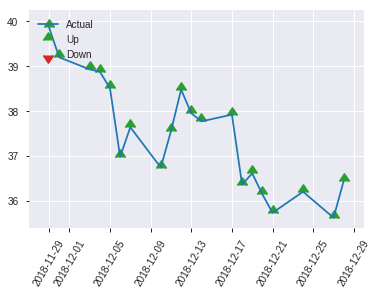


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2574605839681686
RMSE: 0.5074057389980612
LogLoss: 0.7084908116326202
Mean Per-Class Error: 0.4675625873681535
AUC: 0.49847502859321385
pr_auc: 0.5251532169679308
Gini: -0.003049942813572293
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2691193222999573: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    120  0.9836   (120.0/122.0)
1      0    129  0        (0.0/129.0)
Total  2    249  0.4781   (120.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.269119     0.68254   248
max f2                       0.269119     0.843137  248
max f0point5                 0.352794     0.581506  229
max accuracy                 0.352794     0.541833  229
max precision                0.70716      1         0
max recall                   0.269119     1         248
max specificity              0.70716      1         0
max absolute_mcc             0.352794     0.109191  229
max min_per_class_accuracy   0.451101     0.47541   125
max mean_per_class_accuracy  0.557851     0.532437  30

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 46.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.647514           0.648579  0.648579           0.333333         0.673181  0.333333                    0.673181            0.00775194      0.00775194                 -35.1421  -35.1421
    2        0.0239044                   0.632966           1.94574   1.29716            1                0.637955  0.666667                    0.655568            0.0232558       0.0310078                  94.5736   29.7158
    3        0.0318725                   0.621157           0.972868  1.21609            0.5              0.624526  0.625                       0.647808            0.00775194      0.0387597                  -2.71318  21.6085
    4        0.0438247                   0.610133           0.648579  1.06131            0.333333         0.615313  0.545455                    0.638946            0.00775194      0.0465116                  -35.1421  6.13108
    5        0.0517928                   0.602977           1.94574   1.19738            1                0.606799  0.615385                    0.634               0.0155039       0.0620155                  94.5736   19.7376
    6        0.103586                    0.57268            1.0477    1.12254            0.538462         0.585613  0.576923                    0.609806            0.0542636       0.116279                   4.77042   12.254
    7        0.151394                    0.551467           1.29716   1.17768            0.666667         0.56002   0.605263                    0.594084            0.0620155       0.178295                   29.7158   17.7683
    8        0.203187                    0.53062            0.74836   1.06825            0.384615         0.538803  0.54902                     0.579993            0.0387597       0.217054                   -25.164   6.82475
    9        0.302789                    0.506385           1.01178   1.04967            0.52             0.520268  0.539474                    0.560347            0.100775        0.317829                   1.17829   4.96736
    10       0.40239                     0.480333           0.778295  0.982501           0.4              0.491862  0.50495                     0.543395            0.0775194       0.395349                   -22.1705  -1.74994
    11       0.501992                    0.451101           0.856124  0.957426           0.44             0.462117  0.492063                    0.527269            0.0852713       0.48062                    -14.3876  -4.25741
    12       0.601594                    0.430119           0.856124  0.940654           0.44             0.440222  0.483444                    0.512857            0.0852713       0.565891                   -14.3876  -5.9346
    13       0.701195                    0.417867           1.16744   0.972868           0.6              0.424376  0.5                         0.500288            0.116279        0.682171                   16.7442   -2.71318
    14       0.800797                    0.396194           1.08961   0.987389           0.56             0.405477  0.507463                    0.488496            0.108527        0.790698                   8.96124   -1.26114
    15       0.900398                    0.360315           1.24527   1.01592            0.64             0.379262  0.522124                    0.476413            0.124031        0.914729                   24.5271   1.59155
    16       1                           0.242139           0.856124  1                  0.44             0.325556  0.513944                    0.461387     

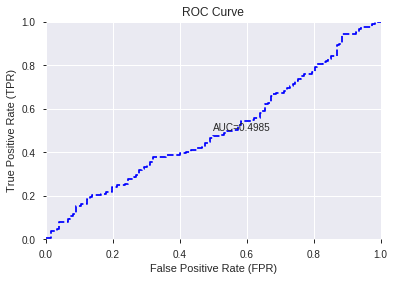

This function is available for GLM models only


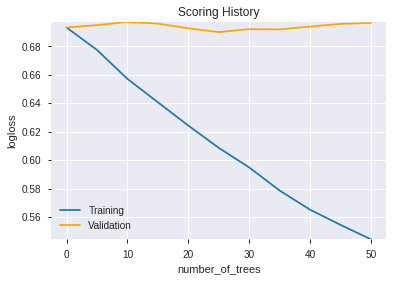

--2019-08-26 16:39:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_163910_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_163910_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['MFI_24',
 'BETA_20',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'HT_PHASOR_quadrature',
 'STDDEV_20',
 'TAN',
 'SUB',
 'MFI_12',
 'SIN',
 'STOCH_slowk',
 'dayofyear',
 'CCI_24',
 'day',
 'BBANDS_upperband_12_6_4',
 'Volume',
 'AD',
 'STOCHF_fastk',
 'DX_12',
 'BETA_24',
 'VAR_14',
 'COS',
 'DIV',
 'BOP',
 'PLUS_DM_20',
 'CORREL_30',
 'MACDFIX_hist_8',
 'BETA_8',
 'MINUS_DM_8',
 'OBV',
 'BETA_30',
 'LINEARREG_ANGLE_14',
 'ADXR_8',
 'ADXR_14',
 'dayofweek',
 'MINUS_DI_14',
 'MACDEXT_hist',
 'MFI_14',
 'DX_30',
 'CCI_20',
 'RSI_24',
 'WILLR_20',
 'CMO_30',
 'week',
 'ADX_8',
 'CCI_14',
 'BETA_14',
 'WILLR_30',
 'STDDEV_30',
 'MINUS_DM_20',
 'CCI_8',
 'STDDEV_8',
 'CORREL_20',
 'ATR_30',
 'PLUS_DM_8',
 'ROC_14',
 'ADOSC',
 'MOM_24',
 'MACDEXT_signal',
 'WILLR_8',
 'PLUS_DM_12',
 'DX_14',
 'PLUS_DM_30',
 'CMO_14',
 'ADX_12',
 'MACDFIX_hist_24',
 'MFI_30',
 'DX_20',
 'BETA_12',
 'MINUS_DI_20',
 'LINEARREG_ANGLE_8',
 'CORREL_12',
 'MOM_14',
 'ADXR_12',
 'CMO_20',
 'CCI_30',
 'CORREL_8',
 'WILLR_14

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

752

['BBANDS_upperband_8_6_4',
 'BBANDS_middleband_8_6_4',
 'BBANDS_lowerband_8_6_4',
 'BBANDS_upperband_8_6_5',
 'BBANDS_middleband_8_6_5',
 'BBANDS_lowerband_8_6_5',
 'MA_8_7',
 'MAVP_8_7',
 'T3_8_7',
 'BBANDS_upperband_8_7_2',
 'BBANDS_middleband_8_7_2',
 'BBANDS_lowerband_8_7_2',
 'BBANDS_upperband_8_7_3',
 'BBANDS_middleband_8_7_3',
 'BBANDS_lowerband_8_7_3',
 'BBANDS_upperband_8_7_4',
 'BBANDS_middleband_8_7_4',
 'BBANDS_lowerband_8_7_4',
 'BBANDS_upperband_8_7_5',
 'BBANDS_middleband_8_7_5',
 'BBANDS_lowerband_8_7_5',
 'MA_8_8',
 'MAVP_8_8',
 'T3_8_8',
 'BBANDS_upperband_8_8_2',
 'BBANDS_middleband_8_8_2',
 'BBANDS_lowerband_8_8_2',
 'BBANDS_upperband_8_8_3',
 'BBANDS_middleband_8_8_3',
 'BBANDS_lowerband_8_8_3',
 'BBANDS_upperband_8_8_4',
 'BBANDS_middleband_8_8_4',
 'BBANDS_lowerband_8_8_4',
 'BBANDS_upperband_8_8_5',
 'BBANDS_middleband_8_8_5',
 'BBANDS_lowerband_8_8_5',
 'DEMA_12',
 'EMA_12',
 'KAMA_12',
 'MIDPOINT_12',
 'MIDPRICE_12',
 'SAR_0.12',
 'SMA_12',
 'TEMA_12',
 'TRIMA

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_164107_model_3  0.538506  0.749976              0.475187  0.522403  0.272905
1               DeepLearning_1_AutoML_20190826_164107  0.519507  1.072037              0.491803  0.611358  0.373758
2  DeepLearning_grid_1_AutoML_20190826_164107_model_2  0.516711  0.856339              0.495902  0.559320  0.312839
3  DeepLearning_grid_1_AutoML_20190826_164107_model_9  0.513979  0.694362              0.474520  0.500607  0.250607
4  DeepLearning_grid_1_AutoML_20190826_164107_model_1  0.508451  1.652381              0.479508  0.622791  0.387868
5  DeepLearning_grid_1_AutoML_20190826_164107_model_8  0.500000  0.692855              0.500000  0.499854  0.249854
6  DeepLearning_grid_1_AutoML_20190826_164107_model_5  0.500000  0.693306              0.500000  0.500080  0.250080
7  DeepLearning_grid_1_AutoML_20190826_164107_model_6  0.500000  0.694243              0.500000  0.500547  0.250548
8  DeepLearning_grid_1_AutoML_20190826_164107_model_7  0.495902  0.711034              0.495902  0.508633  0.258708
9  DeepLearning_grid_1_AutoML_20190826_164107_model_4  0.485703  1.014461              0.475187  0.589589  0.347616

variable  relative_importance  scaled_importance  percentage
0         CDLEVENINGDOJISTAR             1.000000           1.000000    0.003944
1             CDLEVENINGSTAR             0.936384           0.936384    0.003693
2                       TANH             0.915022           0.915022    0.003609
3           CDLSTICKSANDWICH             0.895271           0.895271    0.003531
4                CDLPIERCING             0.873461           0.873461    0.003445
..                       ...                  ...                ...         ...
746  BBANDS_lowerband_14_3_5             0.272059           0.272059    0.001073
747                    FLOOR             0.271925           0.271925    0.001072
748  BBANDS_lowerband_20_3_5             0.269921           0.269921    0.001065
749  BBANDS_lowerband_12_3_3             0.268141           0.268141    0.001058
750           CDL3LINESTRIKE             0.266358           0.266358    0.001050

[751 rows x 4 columns]

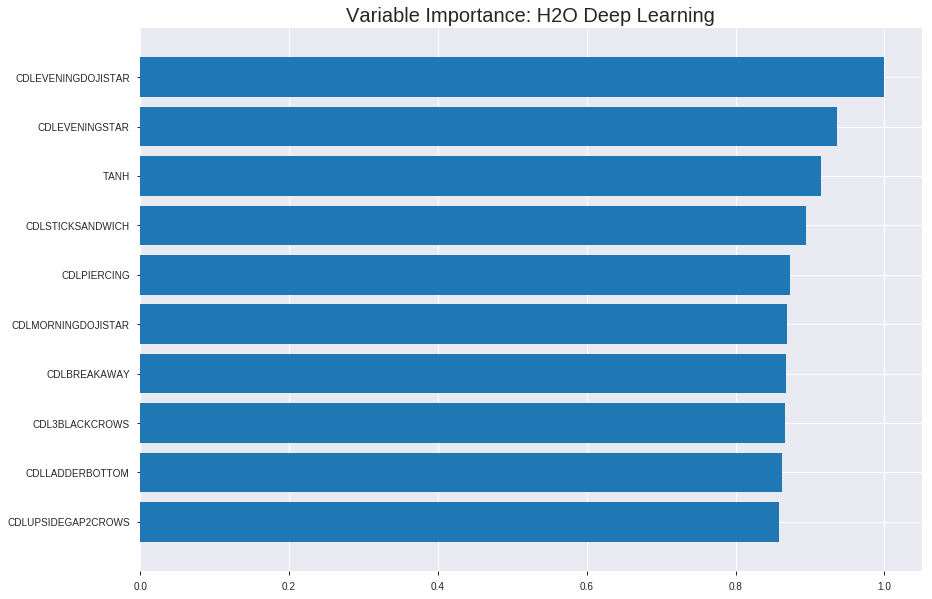

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_164107_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24668595196466508
RMSE: 0.4966748956456981
LogLoss: 0.692682353366296
Mean Per-Class Error: 0.40306317705038386
AUC: 0.6215371337972617
pr_auc: 0.6118727943349157
Gini: 0.24307426759452344
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1281232149746951: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      26   845   0.9701   (845.0/871.0)
1      12   870   0.0136   (12.0/882.0)
Total  38   1715  0.4889   (857.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.128123     0.670004  375
max f2                       0.0360627    0.835385  397
max f0point5                 0.415132     0.600414  216
max accuracy                 0.452764     0.596691  187
max precision                0.921241     1         0
max recall                   0.0360627    1         397
max specificity              0.921241     1         0
max absolute_mcc             0.452764     0.194447  187
max min_per_class_accuracy   0.439591     0.591274  197
max mean_per_class_accuracy  0.452764     0.596937  187

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 43.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.837285           1.65627   1.65627            0.833333         0.87412   0.833333                    0.87412             0.0170068       0.0170068                  65.6274   65.6274
    2        0.0205362                   0.778249           1.43544   1.54586            0.722222         0.809865  0.777778                    0.841992            0.0147392       0.031746                   43.5437   54.5855
    3        0.0302339                   0.730706           0.818394  1.31252            0.411765         0.757671  0.660377                    0.814946            0.00793651      0.0396825                  -18.1606  31.2519
    4        0.040502                    0.69752            1.65627   1.39967            0.833333         0.712399  0.704225                    0.788948            0.0170068       0.0566893                  65.6274   39.9668
    5        0.0501997                   0.671626           1.28605   1.37772            0.647059         0.684191  0.693182                    0.768711            0.0124717       0.069161                   28.6048   37.7719
    6        0.100399                    0.605063           1.35513   1.36643            0.681818         0.633998  0.6875                      0.701355            0.0680272       0.137188                   35.5133   36.6426
    7        0.150029                    0.577264           1.30217   1.34517            0.655172         0.590448  0.676806                    0.664667            0.0646259       0.201814                   30.2174   34.5171
    8        0.200228                    0.551469           1.08411   1.27972            0.545455         0.564544  0.643875                    0.639565            0.0544218       0.256236                   8.41064   27.9719
    9        0.300057                    0.508218           1.19252   1.25071            0.6              0.529727  0.629278                    0.603022            0.119048        0.375283                   19.2517   25.0707
    10       0.399886                    0.469105           1.12437   1.21917            0.565714         0.487758  0.613409                    0.574247            0.112245        0.487528                   12.4373   21.9169
    11       0.500285                    0.439033           1.02764   1.18073            0.517045         0.454896  0.594071                    0.550295            0.103175        0.590703                   2.76425   18.0732
    12       0.600114                    0.401754           0.988086  1.14869            0.497143         0.419111  0.577947                    0.528473            0.0986395       0.689342                   -1.19145  14.8686
    13       0.699943                    0.356552           0.863155  1.10796            0.434286         0.378163  0.557457                    0.507035            0.0861678       0.77551                    -13.6845  10.7962
    14       0.799772                    0.309123           0.738225  1.06181            0.371429         0.333278  0.534237                    0.485346            0.0736961       0.849206                   -26.1775  6.18108
    15       0.899601                    0.24402            0.817726  1.03472            0.411429         0.279673  0.520609                    0.462523            0.0816327       0.930839                   -18.2274  3.47246
    16       1                           0.000529264        0.688859  1                  0.346591         0.170959  0.503137                    0.43325          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2684089274029885
RMSE: 0.5180819697721476
LogLoss: 0.7413596903953223
Mean Per-Class Error: 0.4670645798801478
AUC: 0.5335251179395639
pr_auc: 0.5324354529295919
Gini: 0.06705023587912784
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06171803288956386: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    251  0.9921   (251.0/253.0)
1      0    248  0        (0.0/248.0)
Total  2    499  0.501    (251.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.061718     0.663989  397
max f2                       0.061718     0.831657  397
max f0point5                 0.21014      0.563107  355
max accuracy                 0.653959     0.536926  43
max precision                0.879835     1         0
max recall                   0.061718     1         397
max specificity              0.879835     1         0
max absolute_mcc             0.653959     0.111759  43
max min_per_class_accuracy   0.458653     0.509881  196
max mean_per_class_accuracy  0.652302     0.532935  45

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 44.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.820762           1.68347   1.68347            0.833333         0.859763  0.833333                    0.859763            0.0201613       0.0201613                  68.3468   68.3468
    2        0.0219561                   0.786486           0.808065  1.28556            0.4              0.796162  0.636364                    0.830854            0.00806452      0.0282258                  -19.1935  28.5557
    3        0.0319361                   0.750135           0.808065  1.13634            0.4              0.768307  0.5625                      0.811308            0.00806452      0.0362903                  -19.1935  13.6341
    4        0.0419162                   0.712818           1.61613   1.25058            0.8              0.726629  0.619048                    0.791146            0.016129        0.0524194                  61.6129   25.0576
    5        0.0518962                   0.693059           1.2121    1.24318            0.6              0.700531  0.615385                    0.77372             0.0120968       0.0645161                  21.2097   24.3176
    6        0.101796                    0.650745           1.37371   1.30716            0.68             0.669397  0.647059                    0.722581            0.0685484       0.133065                   37.371    30.7163
    7        0.151697                    0.603172           0.808065  1.14299            0.4              0.621664  0.565789                    0.689385            0.0403226       0.173387                   -19.1935  14.2986
    8        0.201597                    0.582381           0.888871  1.08009            0.44             0.591845  0.534653                    0.665241            0.0443548       0.217742                   -11.1129  8.00862
    9        0.301397                    0.541908           1.05048   1.07028            0.52             0.559948  0.529801                    0.630376            0.104839        0.322581                   5.04839   7.02841
    10       0.401198                    0.509188           0.848468  1.01511            0.42             0.526091  0.502488                    0.604435            0.0846774       0.407258                   -15.1532  1.51059
    11       0.500998                    0.458614           1.05048   1.02215            0.52             0.483043  0.505976                    0.580253            0.104839        0.512097                   5.04839   2.21533
    12       0.600798                    0.412969           1.13129   1.04028            0.56             0.434408  0.51495                     0.556026            0.112903        0.625                      13.129    4.02824
    13       0.700599                    0.356734           0.888871  1.01871            0.44             0.386548  0.504274                    0.531884            0.0887097       0.71371                    -11.1129  1.87138
    14       0.800399                    0.30185            1.05048   1.02268            0.52             0.332264  0.506234                    0.506994            0.104839        0.818548                   5.04839   2.26752
    15       0.9002                      0.212215           1.09089   1.03024            0.54             0.259019  0.509978                    0.479502            0.108871        0.927419                   9.08871   3.02375
    16       1                           0.0383958          0.727258  1                  0.36             0.137844  0.49501                     0.445405         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 16:44:24  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 16:44:26  3 min 17.176 sec  632 obs/sec       0.703366  1             1233       0.659204         3.83228             -0.738267      0.502448        0.384996           1.2146           0.496863                         0.700872           5.74979               -0.965079        0.499992          0.403402             0.673387           0.502994
    2019-08-26 16:44:37  3 min 28.260 sec  715 obs/sec       4.90416   7             8597       0.572505         1.59979             -0.3111        0.602812        0.600831           1.54586          0.496863                         0.645144           2.59373               -0.66501         0.538625          0.524423             1.34677            0.50499
    2019-08-26 16:44:48  3 min 38.985 sec  735 obs/sec       9.12436   13            15995      0.557443         1.07374             -0.243018      0.604237        0.562902           1.76669          0.450086                         0.619671           1.46154               -0.536123        0.519611          0.508798             1.34677            0.50499
    2019-08-26 16:44:58  3 min 49.633 sec  747 obs/sec       13.3799   19            23455      0.532568         0.823549            -0.134558      0.60351         0.589016           1.76669          0.459213                         0.581588           1.01202               -0.353113        0.524568          0.508836             1.68347            0.497006
    2019-08-26 16:45:09  4 min  0.156 sec  754 obs/sec       17.603    25            30858      0.493177         0.68905             0.0270663      0.639678        0.632561           1.43544          0.469481                         0.548236           0.847507              -0.202371        0.533908          0.499961             0.673387           0.50499
    2019-08-26 16:45:19  4 min 10.480 sec  761 obs/sec       21.8123   31            38237      0.496675         0.692682            0.0132173      0.621537        0.611873           1.65627          0.488876                         0.518082           0.74136               -0.0737427       0.533525          0.532435             1.68347            0.500998
    2019-08-26 16:45:30  4 min 20.937 sec  765 obs/sec       26.073    37            45706      0.528779         0.790444            -0.118472      0.620556        0.620966           1.65627          0.486024                         0.575588           0.940533              -0.325339        0.557567          0.558349             1.68347            0.500998
    2019-08-26 16:45:41  4 min 32.318 sec  774 obs/sec       30.9755   44            54300      0.546036         0.914909            -0.192667      0.603454        0.621792           1.76669          0.48146                          0.62138            1.2088                -0.544608        0.538147          0.528871             1.01008            0.477046
    2019-08-26 16:45:52  4

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLEVENINGDOJISTAR       1.0                    1.0                  0.00394392644217669
CDLEVENINGSTAR           0.9363840222358704     0.9363840222358704   0.003693029705327815
TANH                     0.9150223135948181     0.9150223135948181   0.0036087806977682943
CDLSTICKSANDWICH         0.8952713012695312     0.8952713012695312   0.0035308841579988377
CDLPIERCING              0.8734605312347412     0.8734605312347412   0.0034448640853343947
---                      ---                    ---                  ---
BBANDS_lowerband_14_3_5  0.2720586061477661     0.2720586061477661   0.0010729791306079085
FLOOR                    0.27192482352256775    0.27192482352256775  0.001072451501774885
BBANDS_lowerband_20_3_5  0.2699205279350281     0.2699205279350281   0.0010645467074092492
BBANDS_lowerband_12_3_3  0.26814115047454834    0.26814115047454834  0.0010575289735922499
CDL3LINESTRIKE           0.26635828614234924    0.26635828614234924  0.0010504974878096762


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.6881720430107526)

('auc', 0.5385055280213495)

('logloss', 0.74997569090998)

('mean_per_class_error', 0.4289617486338798)

('rmse', 0.5224034327359147)

('mse', 0.2729053465342674)

deeplearning prediction progress: |███████████████████████████████████████| 100%


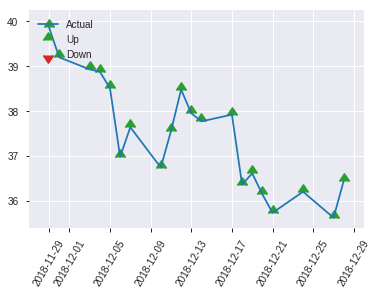


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2729053465342674
RMSE: 0.5224034327359147
LogLoss: 0.74997569090998
Mean Per-Class Error: 0.4289617486338798
AUC: 0.5385055280213495
pr_auc: 0.536325290676863
Gini: 0.07701105604269909
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15039243372284758: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    115  0.9426   (115.0/122.0)
1      1    128  0.0078   (1.0/129.0)
Total  8    243  0.4622   (116.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.150392     0.688172  242
max f2                       0.109124     0.844241  247
max f0point5                 0.452383     0.589849  149
max accuracy                 0.452383     0.573705  149
max precision                0.720375     0.642857  27
max recall                   0.109124     1         247
max specificity              0.926799     0.991803  0
max absolute_mcc             0.452383     0.144807  149
max min_per_class_accuracy   0.512435     0.516393  125
max mean_per_class_accuracy  0.452383     0.571038  149

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 49.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.838394           0.648579  0.648579           0.333333         0.878177  0.333333                    0.878177            0.00775194      0.00775194                 -35.1421  -35.1421
    2        0.0239044                   0.802496           0.648579  0.648579           0.333333         0.81452   0.333333                    0.846348            0.00775194      0.0155039                  -35.1421  -35.1421
    3        0.0318725                   0.775694           1.94574   0.972868           1                0.780038  0.5                         0.829771            0.0155039       0.0310078                  94.5736   -2.71318
    4        0.0438247                   0.77113            1.29716   1.06131            0.666667         0.771776  0.545455                    0.813954            0.0155039       0.0465116                  29.7158   6.13108
    5        0.0517928                   0.762093           0.972868  1.0477             0.5              0.765945  0.538462                    0.806568            0.00775194      0.0542636                  -2.71318  4.77042
    6        0.103586                    0.726143           1.34705   1.19738            0.692308         0.746119  0.615385                    0.776344            0.0697674       0.124031                   34.7048   19.7376
    7        0.151394                    0.702023           0.648579  1.02407            0.333333         0.711839  0.526316                    0.755974            0.0310078       0.155039                   -35.1421  2.40718
    8        0.203187                    0.687329           1.19738   1.06825            0.615385         0.695481  0.54902                     0.740554            0.0620155       0.217054                   19.7376   6.82475
    9        0.302789                    0.639269           1.24527   1.12648            0.64             0.6639    0.578947                    0.715339            0.124031        0.341085                   24.5271   12.6479
    10       0.40239                     0.581419           0.544806  0.982501           0.28             0.610979  0.50495                     0.689507            0.0542636       0.395349                   -45.5194  -1.74994
    11       0.501992                    0.512435           1.24527   1.03464            0.64             0.543088  0.531746                    0.660456            0.124031        0.51938                    24.5271   3.46376
    12       0.601594                    0.452125           1.47876   1.10817            0.76             0.481854  0.569536                    0.630886            0.147287        0.666667                   47.876    10.8168
    13       0.701195                    0.387214           0.544806  1.02814            0.28             0.416723  0.528409                    0.600465            0.0542636       0.72093                    -45.5194  2.81448
    14       0.800797                    0.302929           0.856124  1.00675            0.44             0.34888   0.517413                    0.569174            0.0852713       0.806202                   -14.3876  0.67492
    15       0.900398                    0.230818           1.16744   1.02452            0.6              0.271996  0.526549                    0.5363              0.116279        0.922481                   16.7442   2.45249
    16       1                           0.0820031          0.778295  1                  0.4              0.169549  0.513944                    0.499771     

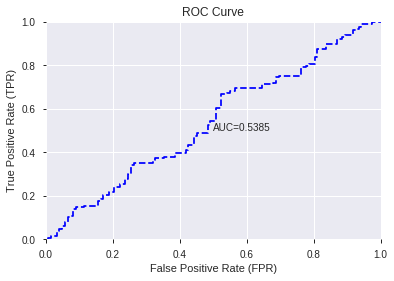

This function is available for GLM models only


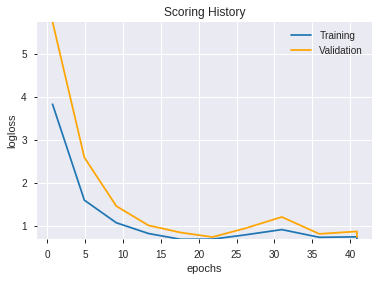

--2019-08-26 17:06:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_164107_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_164107_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'TANH',
 'CDLSTICKSANDWICH',
 'CDLPIERCING',
 'CDLMORNINGDOJISTAR',
 'CDLBREAKAWAY',
 'CDL3BLACKCROWS',
 'CDLLADDERBOTTOM',
 'CDLUPSIDEGAP2CROWS',
 'CDLUNIQUE3RIVER',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'CDL3WHITESOLDIERS',
 'CDLINNECK',
 'CDLSTALLEDPATTERN',
 'SINH',
 'EXP',
 'COSH',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'CDLHOMINGPIGEON',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CDLSEPARATINGLINES',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLDARKCLOUDCOVER',
 'COS',
 'SIN',
 'HT_DCPERIOD',
 'STOCHRSI_fastk',
 'CORREL_30',
 'AD',
 'CORREL_14',
 'STOCHRSI_fastd',
 'aroondown_14',
 'CDLXSIDEGAP3METHODS',
 'CORREL_8',
 'CDLDOJI',
 'AROONOSC_14',
 'ADX_24',
 'aroonup_14',
 'aroondown_8',
 'aroonup_8',
 'CORREL_24',
 'BOP',
 'CORREL_12',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'ADX_12',
 'CCI_8',
 'CORREL_20',
 'OBV',
 'aroondown_30',
 'CDLLONGLEGGEDDOJI',
 'BETA_14',
 'ADX_20',
 'CDLTASUKIGAP',
 'AROONOSC_8',
 'STOCH_slowd',
 'S

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_170632_model_1  0.479985  0.698289              0.495902  0.502558  0.252564

variable  relative_importance  scaled_importance  percentage
0         CDLSEPARATINGLINES         8.912910e-03           1.000000    0.013866
1        CDLXSIDEGAP3METHODS         7.817787e-03           0.877131    0.012163
2         CDLCLOSINGMARUBOZU         7.020039e-03           0.787626    0.010922
3                        SIN         6.682045e-03           0.749704    0.010396
4         CDLEVENINGDOJISTAR         6.572257e-03           0.737386    0.010225
..                       ...                  ...                ...         ...
746  BBANDS_upperband_14_5_2         4.709582e-06           0.000528    0.000007
747  BBANDS_upperband_30_7_4         3.269463e-06           0.000367    0.000005
748  BBANDS_lowerband_20_6_4         2.553571e-06           0.000287    0.000004
749  BBANDS_middleband_8_7_2         1.869244e-06           0.000210    0.000003
750  BBANDS_upperband_20_0_2         9.208797e-07           0.000103    0.000001

[751 rows x 4 columns]

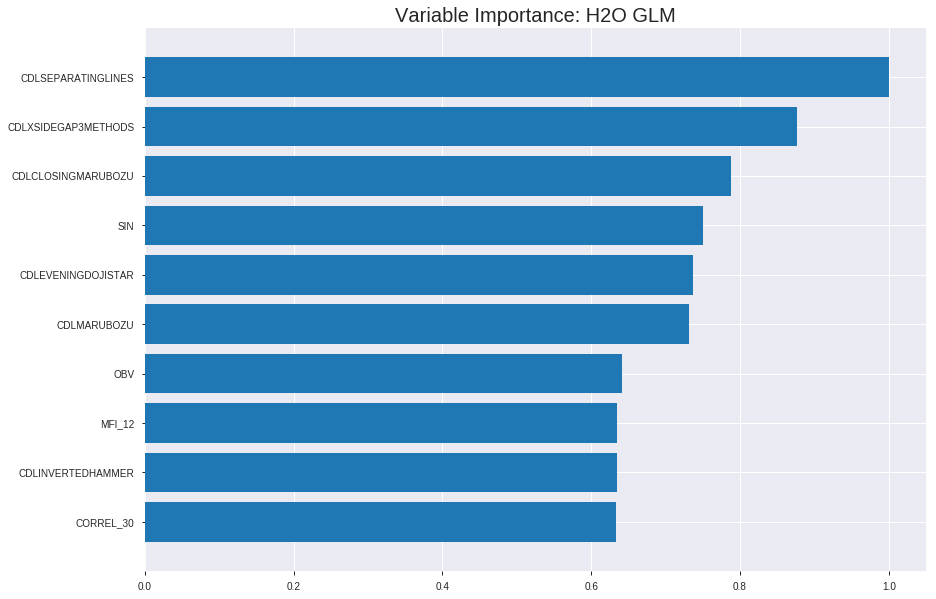

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_170632_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2466828513777602
RMSE: 0.49667177429139275
LogLoss: 0.6864852015716637
Null degrees of freedom: 1752
Residual degrees of freedom: 1001
Null deviance: 2430.1049900608095
Residual deviance: 2406.817116710253
AIC: 3910.817116710253
AUC: 0.5807709229884069
pr_auc: 0.5874723945908596
Gini: 0.16154184597681387
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4463493061715833: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      56   815   0.9357   (815.0/871.0)
1      21   861   0.0238   (21.0/882.0)
Total  77   1676  0.4769   (836.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446349     0.673182  351
max f2                       0.405934     0.836177  392
max f0point5                 0.490123     0.575456  243
max accuracy                 0.512571     0.559042  150
max precision                0.55564      0.9       13
max recall                   0.405934     1         392
max specificity              0.585963     0.998852  0
max absolute_mcc             0.527817     0.144676  83
max min_per_class_accuracy   0.507099     0.54535   173
max mean_per_class_accuracy  0.512571     0.559579  150

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 50.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0102681                   0.556227           1.76669   1.76669            0.888889         0.564786  0.888889                    0.564786            0.0181406       0.0181406                  76.6692     76.6692
    2        0.0205362                   0.55053            1.2146    1.49065            0.611111         0.552538  0.75                        0.558662            0.0124717       0.0306122                  21.4601     49.0646
    3        0.0302339                   0.545122           1.28605   1.42502            0.647059         0.547638  0.716981                    0.555126            0.0124717       0.0430839                  28.6048     42.502
    4        0.040502                    0.542579           1.54586   1.45565            0.777778         0.543771  0.732394                    0.552247            0.015873        0.0589569                  54.5855     45.5655
    5        0.0501997                   0.539781           1.16913   1.4003             0.588235         0.541036  0.704545                    0.550082            0.0113379       0.0702948                  16.9134     40.0304
    6        0.100399                    0.532836           1.24221   1.32125            0.625            0.535874  0.664773                    0.542978            0.0623583       0.132653                   24.2205     32.1255
    7        0.150029                    0.529196           1.30217   1.31494            0.655172         0.531036  0.661597                    0.539028            0.0646259       0.197279                   30.2174     31.4943
    8        0.200228                    0.525757           1.03894   1.24574            0.522727         0.527439  0.626781                    0.536122            0.0521542       0.249433                   3.89353     24.5744
    9        0.300057                    0.519711           1.03351   1.17514            0.52             0.522828  0.591255                    0.531699            0.103175        0.352608                   3.35147     17.5136
    10       0.399886                    0.513656           1.03351   1.13978            0.52             0.516716  0.573466                    0.527959            0.103175        0.455782                   3.35147     13.9781
    11       0.500285                    0.507024           0.892129  1.09008            0.448864         0.51017   0.548461                    0.524389            0.0895692       0.545351                   -10.7871    9.00811
    12       0.600114                    0.500533           0.999443  1.075              0.502857         0.50408   0.540875                    0.521011            0.0997732       0.645125                   -0.0557175  7.50034
    13       0.699943                    0.492872           1.02216   1.06747            0.514286         0.497017  0.537082                    0.517589            0.102041        0.747166                   2.21574     6.74663
    14       0.799772                    0.48287            0.874512  1.04338            0.44             0.487949  0.524964                    0.513889            0.0873016       0.834467                   -12.5488    4.33815
    15       0.899601                    0.467053           0.851798  1.02212            0.428571         0.476083  0.514268                    0.509694            0.085034        0.919501                   -14.8202    2.21214
    16       1                           0.387385           0.801787  1                  0.403409         0.444394  0.503137    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25001077907440583
RMSE: 0.5000107789582199
LogLoss: 0.6931743711748354
Null degrees of freedom: 500
Residual degrees of freedom: -251
Null deviance: 694.6159526243423
Residual deviance: 694.5607199171849
AIC: 2198.560719917185
AUC: 0.5182726635216116
pr_auc: 0.5232075962664132
Gini: 0.03654532704322322
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4261935236999017: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    252  0.996    (252.0/253.0)
1      0    248  0        (0.0/248.0)
Total  1    500  0.503    (252.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426194     0.663102  398
max f2                       0.426194     0.831099  398
max f0point5                 0.426194     0.551601  398
max accuracy                 0.505899     0.530938  32
max precision                0.530126     1         0
max recall                   0.426194     1         398
max specificity              0.530126     1         0
max absolute_mcc             0.505899     0.10204   32
max min_per_class_accuracy   0.481148     0.516129  202
max mean_per_class_accuracy  0.479991     0.527158  212

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 48.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.518011           1.34677   1.34677            0.666667         0.523004  0.666667                    0.523004            0.016129        0.016129                   34.6774   34.6774
    2        0.0219561                   0.513403           1.61613   1.46921            0.8              0.515004  0.727273                    0.519368            0.016129        0.0322581                  61.6129   46.9208
    3        0.0319361                   0.510769           0.808065  1.2626             0.4              0.511602  0.625                       0.516941            0.00806452      0.0403226                  -19.1935  26.2601
    4        0.0419162                   0.508493           1.2121    1.25058            0.6              0.508943  0.619048                    0.515037            0.0120968       0.0524194                  21.2097   25.0576
    5        0.0518962                   0.507618           1.2121    1.24318            0.6              0.507853  0.615385                    0.513655            0.0120968       0.0645161                  21.2097   24.3176
    6        0.101796                    0.504428           1.13129   1.18833            0.56             0.50568   0.588235                    0.509746            0.0564516       0.120968                   13.129    18.833
    7        0.151697                    0.501624           0.888871  1.08982            0.44             0.50277   0.539474                    0.507451            0.0443548       0.165323                   -11.1129  8.98239
    8        0.201597                    0.498345           0.888871  1.04008            0.44             0.500332  0.514851                    0.505689            0.0443548       0.209677                   -11.1129  4.0083
    9        0.301397                    0.491251           1.05048   1.04353            0.52             0.494739  0.516556                    0.502063            0.104839        0.314516                   5.04839   4.3527
    10       0.401198                    0.485733           1.05048   1.04526            0.52             0.488299  0.517413                    0.498639            0.104839        0.419355                   5.04839   4.52576
    11       0.500998                    0.480767           0.969677  1.0302             0.48             0.483213  0.50996                     0.495566            0.0967742       0.516129                   -3.03226  3.02018
    12       0.600798                    0.47631            1.05048   1.03357            0.52             0.478425  0.511628                    0.492719            0.104839        0.620968                   5.04839   3.35709
    13       0.700599                    0.472216           0.888871  1.01296            0.44             0.4742    0.501425                    0.490081            0.0887097       0.709677                   -11.1129  1.29584
    14       0.800399                    0.464994           0.808065  0.987411           0.4              0.469075  0.488778                    0.487462            0.0806452       0.790323                   -19.1935  -1.25895
    15       0.9002                      0.457591           0.888871  0.976486           0.44             0.461552  0.48337                     0.484589            0.0887097       0.879032                   -11.1129  -2.35141
    16       1                           0.425286           1.2121    1                  0.6              0.448283  0.49501                     0.480966          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 17:06:34  0.000 sec   2            3         752           1.37297           1.38635
    2019-08-26 17:06:35  1.102 sec   4            2.2       752           1.36999           1.38644
    2019-08-26 17:06:36  2.217 sec   6            1.6       752           1.36645           1.38664
    2019-08-26 17:06:37  3.314 sec   8            1.2       752           1.36227           1.3871
    2019-08-26 17:06:38  4.469 sec   10           0.84      752           1.35746           1.388
    2019-08-26 17:06:39  5.584 sec   12           0.61      752           1.35205           1.38956

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5219123505976095)

('F1', 0.6807387862796834)

('auc', 0.4799847502859321)

('logloss', 0.6982892990799539)

('mean_per_class_error', 0.47486974202567034)

('rmse', 0.5025576911785772)

('mse', 0.25256423296274216)

glm prediction progress: |████████████████████████████████████████████████| 100%


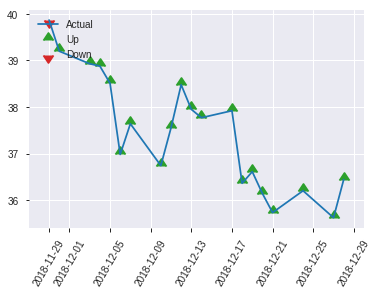


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25256423296274216
RMSE: 0.5025576911785772
LogLoss: 0.6982892990799539
Null degrees of freedom: 250
Residual degrees of freedom: -501
Null deviance: 347.88191742869697
Residual deviance: 350.54122813813683
AIC: 1854.5412281381368
AUC: 0.4799847502859321
pr_auc: 0.5016137763436306
Gini: -0.040030499428135746
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43342355519507847: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    121  0.9918   (121.0/122.0)
1      0    129  0        (0.0/129.0)
Total  1    250  0.4821   (121.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433424     0.680739  249
max f2                       0.433424     0.842037  249
max f0point5                 0.433424     0.571302  249
max accuracy                 0.458586     0.521912  184
max precision                0.492637     0.64      24
max recall                   0.433424     1         249
max specificity              0.5264       0.991803  0
max absolute_mcc             0.502324     0.130857  3
max min_per_class_accuracy   0.46997      0.47541   125
max mean_per_class_accuracy  0.492637     0.52513   24

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 47.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.504304           0         0                  0                0.514298  0                           0.514298            0               0                          -100      -100
    2        0.0239044                   0.499627           0.648579  0.324289           0.333333         0.501148  0.166667                    0.507723            0.00775194      0.00775194                 -35.1421  -67.5711
    3        0.0318725                   0.497943           1.94574   0.729651           1                0.499112  0.375                       0.50557             0.0155039       0.0232558                  94.5736   -27.0349
    4        0.0438247                   0.495562           1.29716   0.884426           0.666667         0.4965    0.454545                    0.503096            0.0155039       0.0387597                  29.7158   -11.5574
    5        0.0517928                   0.495028           1.94574   1.0477             1                0.495378  0.538462                    0.501909            0.0155039       0.0542636                  94.5736   4.77042
    6        0.103586                    0.492555           1.34705   1.19738            0.692308         0.493667  0.615385                    0.497788            0.0697674       0.124031                   34.7048   19.7376
    7        0.151394                    0.489645           0.810724  1.07528            0.416667         0.490646  0.552632                    0.495533            0.0387597       0.162791                   -18.9276  7.52754
    8        0.203187                    0.485661           0.74836   0.991944           0.384615         0.487315  0.509804                    0.493438            0.0387597       0.20155                    -25.164   -0.805594
    9        0.302789                    0.481658           0.700465  0.896063           0.36             0.483548  0.460526                    0.490185            0.0697674       0.271318                   -29.9535  -10.3937
    10       0.40239                     0.474778           0.856124  0.886177           0.44             0.477867  0.455446                    0.487136            0.0852713       0.356589                   -14.3876  -11.3823
    11       0.501992                    0.46997            1.24527   0.957426           0.64             0.471968  0.492063                    0.484126            0.124031        0.48062                    24.5271   -4.25741
    12       0.601594                    0.46522            1.01178   0.966425           0.52             0.467624  0.496689                    0.481394            0.100775        0.581395                   1.17829   -3.35746
    13       0.701195                    0.461196           1.16744   0.994979           0.6              0.463023  0.511364                    0.478785            0.116279        0.697674                   16.7442   -0.502114
    14       0.800797                    0.456164           0.933953  0.987389           0.48             0.458115  0.507463                    0.476214            0.0930233       0.790698                   -6.60465  -1.26114
    15       0.900398                    0.452603           1.16744   1.00731            0.6              0.454391  0.517699                    0.4738              0.116279        0.906977                   16.7442   0.730603
    16       1                           0.421719           0.933953  1                  0.48             0.446024  0.513944                    0.47103

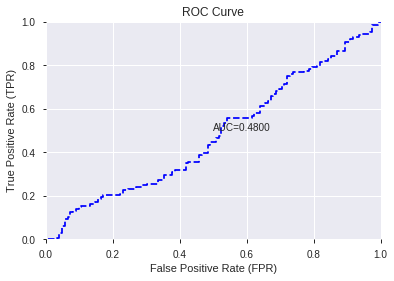

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


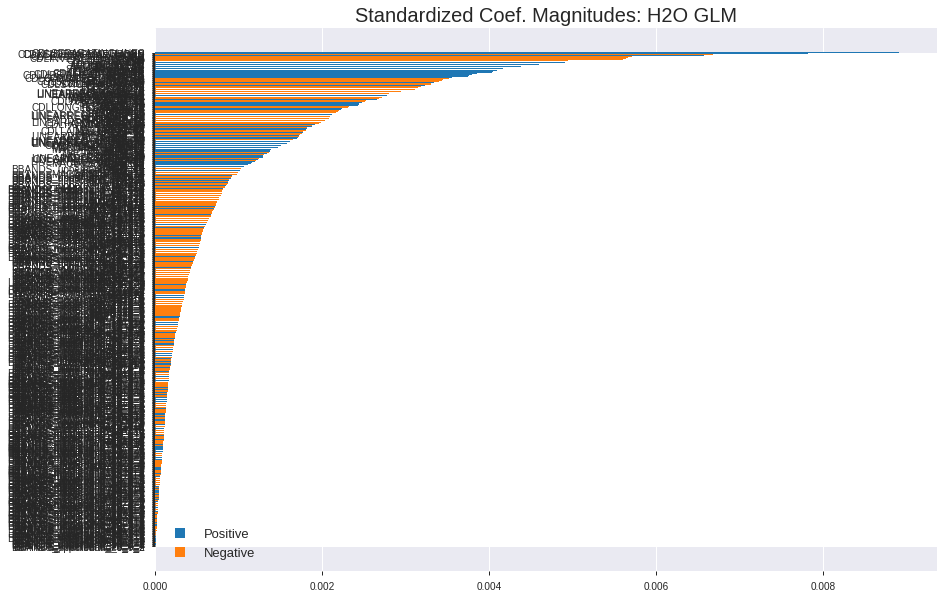

'log_likelihood'
--2019-08-26 17:06:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.172
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.172|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_170632_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_170632_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLSEPARATINGLINES',
 'CDLXSIDEGAP3METHODS',
 'CDLCLOSINGMARUBOZU',
 'SIN',
 'CDLEVENINGDOJISTAR',
 'CDLMARUBOZU',
 'OBV',
 'MFI_12',
 'CDLINVERTEDHAMMER',
 'CORREL_30',
 'TANH',
 'CDLTHRUSTING',
 'COSH',
 'EXP',
 'SINH',
 'aroonup_20',
 'CDLHIGHWAVE',
 'AROONOSC_14',
 'CDLDOJISTAR',
 'aroonup_24',
 'AROONOSC_20',
 'CDLTAKURI',
 'TAN',
 'STOCHRSI_fastd',
 'aroonup_14',
 'ADX_24',
 'aroondown_14',
 'VAR_24',
 'BOP',
 'CDLSHORTLINE',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'ADX_20',
 'CDLUPSIDEGAP2CROWS',
 'ADX_14',
 'VAR_8',
 'ADX_12',
 'CDLUNIQUE3RIVER',
 'CDLGAPSIDESIDEWHITE',
 'PLUS_DI_24',
 'PLUS_DI_30',
 'AD',
 'CDLINNECK',
 'CDL3WHITESOLDIERS',
 'PLUS_DI_20',
 'CDLBREAKAWAY',
 'CDL3BLACKCROWS',
 'CDLSTICKSANDWICH',
 'PLUS_DM_30',
 'PLUS_DM_24',
 'CDLHARAMI',
 'MFI_8',
 'PLUS_DM_20',
 'PLUS_DI_14',
 'ADXR_8',
 'CCI_8',
 'aroondown_20',
 'PLUS_DI_12',
 'ADX_8',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'aroonup_12',
 'CDLRICKSHAWMAN',
 'ADXR_12',
 'STOCH_slowk',
 'MACDEXT_sig

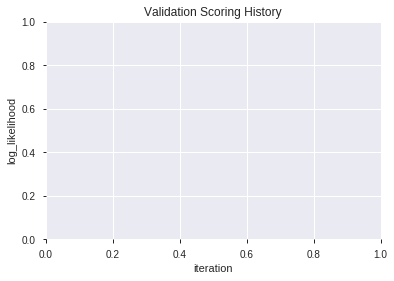

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190826_170701  0.520968  0.696373              0.470644  0.501622  0.251625
1  XGBoost_grid_1_AutoML_20190826_170701_model_2  0.487355  0.702909              0.500000  0.504800  0.254823
2  XGBoost_grid_1_AutoML_20190826_170701_model_4  0.481700  0.705933              0.483607  0.506272  0.256311
3               XGBoost_1_AutoML_20190826_170701  0.478968  0.729373              0.491803  0.516827  0.267110
4  XGBoost_grid_1_AutoML_20190826_170701_model_6  0.477570  0.712436              0.495902  0.509243  0.259329
5  XGBoost_grid_1_AutoML_20190826_170701_model_5  0.476681  0.747894              0.500000  0.524384  0.274979
6  XGBoost_grid_1_AutoML_20190826_170701_model_7  0.474266  0.727106              0.483384  0.516005  0.266261
7  XGBoost_grid_1_AutoML_20190826_170701_model_3  0.468992  0.719412              0.500000  0.512426  0.262580
8  XGBoost_grid_1_AutoML_20190826_170701_model_1  0.467022  0.711044              0.487483  0.508743  0.258820
9               XGBoost_2_AutoML_20190826_170701  0.460478  0.730141              0.491803  0.517467  0.267772

variable  relative_importance  scaled_importance  percentage
0                  CORREL_30           144.366776           1.000000    0.024979
1                HT_DCPERIOD           141.792740           0.982170    0.024534
2                        SIN           118.432983           0.820362    0.020492
3                        TAN           112.784592           0.781236    0.019515
4                        OBV            93.893806           0.650384    0.016246
..                       ...                  ...                ...         ...
279  BBANDS_lowerband_30_1_3             1.716667           0.011891    0.000297
280  BBANDS_upperband_20_1_5             1.520823           0.010534    0.000263
281  BBANDS_upperband_14_7_3             1.109600           0.007686    0.000192
282  BBANDS_lowerband_30_7_5             0.445504           0.003086    0.000077
283                   ATR_12             0.131601           0.000912    0.000023

[284 rows x 4 columns]

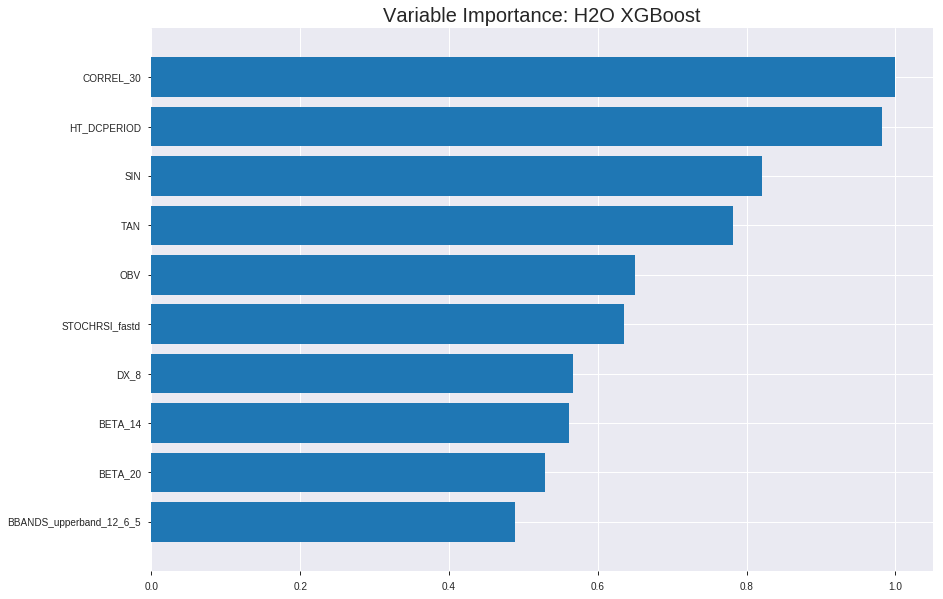

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190826_170701


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17411469445990926
RMSE: 0.4172705291054105
LogLoss: 0.5368234968180051
Mean Per-Class Error: 0.1141447394112639
AUC: 0.955076787699389
pr_auc: 0.9547182172045302
Gini: 0.910153575398778
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47669170300165814: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      719  152  0.1745   (152.0/871.0)
1      53   829  0.0601   (53.0/882.0)
Total  772  981  0.1169   (205.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476692     0.889962  227
max f2                       0.454146     0.928215  249
max f0point5                 0.535815     0.89589   175
max accuracy                 0.494064     0.88591   211
max precision                0.800442     1         0
max recall                   0.37329      1         327
max specificity              0.800442     1         0
max absolute_mcc             0.494064     0.771886  211
max min_per_class_accuracy   0.496938     0.880597  208
max mean_per_class_accuracy  0.494064     0.885855  211

Gains/Lift Table: Avg response rate: 50.31 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.760805           1.98753    1.98753            1                0.77551   1                           0.77551             0.0204082       0.0204082                  98.7528   98.7528
    2        0.0205362                   0.737649           1.98753    1.98753            1                0.745429  1                           0.76047             0.0204082       0.0408163                  98.7528   98.7528
    3        0.0302339                   0.71864            1.98753    1.98753            1                0.726312  1                           0.749514            0.0192744       0.0600907                  98.7528   98.7528
    4        0.040502                    0.711225           1.98753    1.98753            1                0.715089  1                           0.740786            0.0204082       0.0804989                  98.7528   98.7528
    5        0.0501997                   0.701187           1.98753    1.98753            1                0.707366  1                           0.73433             0.0192744       0.0997732                  98.7528   98.7528
    6        0.100399                    0.662459           1.98753    1.98753            1                0.67793   1                           0.70613             0.0997732       0.199546                   98.7528   98.7528
    7        0.150029                    0.634747           1.96468    1.97997            0.988506         0.647808  0.996198                    0.686837            0.0975057       0.297052                   96.4683   97.9971
    8        0.200228                    0.61198            1.91977    1.96488            0.965909         0.623505  0.988604                    0.670959            0.0963719       0.393424                   91.9772   96.4878
    9        0.300057                    0.572084           1.8626     1.93085            0.937143         0.592703  0.971483                    0.644923            0.185941        0.579365                   86.2598   93.085
    10       0.399886                    0.532862           1.68088    1.86845            0.845714         0.551788  0.940086                    0.621673            0.1678          0.747166                   68.0881   86.8447
    11       0.500285                    0.497128           1.30996    1.75637            0.659091         0.51453   0.883694                    0.600171            0.131519        0.878685                   30.9962   75.6368
    12       0.600114                    0.460148           0.806369   1.59834            0.405714         0.479454  0.804183                    0.580089            0.0804989       0.959184                   -19.3631  59.8336
    13       0.699943                    0.425026           0.272575   1.40925            0.137143         0.441769  0.709046                    0.560362            0.0272109       0.986395                   -72.7425  40.925
    14       0.799772                    0.390995           0.102216   1.2461             0.0514286        0.407296  0.626961                    0.541256            0.0102041       0.996599                   -89.7784  24.6104
    15       0.899601                    0.355681           0.0340719  1.1116             0.0171429        0.375169  0.55929                     0.522825            0.00340136      1                          -96.5928  11.1604
    16       1                           0.250565           0          1                  0                0.322277  0.503137                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2513271199503281
RMSE: 0.501325363362286
LogLoss: 0.6959549438139362
Mean Per-Class Error: 0.4673355221216371
AUC: 0.5284728420247354
pr_auc: 0.5305159973156759
Gini: 0.05694568404947087
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3086906671524048: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    253  1        (253.0/253.0)
1      0    248  0        (0.0/248.0)
Total  0    501  0.505    (253.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.308691     0.662216  399
max f2                       0.308691     0.830543  399
max f0point5                 0.364795     0.553016  384
max accuracy                 0.591235     0.532934  39
max precision                0.758629     1         0
max recall                   0.308691     1         399
max specificity              0.758629     1         0
max absolute_mcc             0.591235     0.103856  39
max min_per_class_accuracy   0.487978     0.521739  208
max mean_per_class_accuracy  0.451604     0.532664  269

Gains/Lift Table: Avg response rate: 49.50 %, avg score: 49.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.725861           1.34677   1.34677            0.666667         0.745431  0.666667                    0.745431            0.016129        0.016129                   34.6774   34.6774
    2        0.0219561                   0.670543           1.2121    1.28556            0.6              0.68658   0.636364                    0.71868             0.0120968       0.0282258                  21.2097   28.5557
    3        0.0319361                   0.636722           1.61613   1.38886            0.8              0.640593  0.6875                      0.694278            0.016129        0.0443548                  61.6129   38.8861
    4        0.0419162                   0.62271            1.2121    1.34677            0.6              0.627931  0.666667                    0.678481            0.0120968       0.0564516                  21.2097   34.6774
    5        0.0518962                   0.611365           1.61613   1.39857            0.8              0.616761  0.692308                    0.666612            0.016129        0.0725806                  61.6129   39.8573
    6        0.101796                    0.584056           1.05048   1.22794            0.52             0.595366  0.607843                    0.631688            0.0524194       0.125                      5.04839   22.7941
    7        0.151697                    0.564604           0.565645  1.01008            0.28             0.573923  0.5                         0.612686            0.0282258       0.153226                   -43.4355  1.00806
    8        0.201597                    0.5508             1.05048   1.02008            0.52             0.555857  0.50495                     0.598619            0.0524194       0.205645                   5.04839   2.00814
    9        0.301397                    0.528776           1.09089   1.04353            0.54             0.539655  0.516556                    0.579095            0.108871        0.314516                   9.08871   4.3527
    10       0.401198                    0.504202           1.09089   1.05531            0.54             0.516411  0.522388                    0.563502            0.108871        0.423387                   9.08871   5.53081
    11       0.500998                    0.487943           1.01008   1.0463             0.5              0.497405  0.517928                    0.550335            0.100806        0.524194                   1.00806   4.62987
    12       0.600798                    0.465418           0.929274  1.02686            0.46             0.476772  0.508306                    0.538115            0.0927419       0.616935                   -7.07258  2.68594
    13       0.700599                    0.443117           1.05048   1.03022            0.52             0.45465   0.509972                    0.526226            0.104839        0.721774                   5.04839   3.02247
    14       0.800399                    0.427001           0.929274  1.01764            0.46             0.435097  0.503741                    0.514863            0.0927419       0.814516                   -7.07258  1.76374
    15       0.9002                      0.402375           0.888871  1.00336            0.44             0.415006  0.496674                    0.503792            0.0887097       0.903226                   -11.1129  0.336171
    16       1                           0.308691           0.969677  1                  0.48             0.372235  0.49501                     0.490663         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:07:09  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.496863                         0.5                0.693147              0.5               0                    1                  0.50499
    2019-08-26 17:07:10  0.467 sec   5                  0.489289         0.671921            0.8047          0.806311           1.98753          0.285796                         0.499425           0.691994              0.524202          0.503029             0.673387           0.483034
    2019-08-26 17:07:10  0.644 sec   10                 0.479568         0.65293             0.847903        0.849154           1.98753          0.249287                         0.498553           0.690247              0.543733          0.5246               1.34677            0.48503
    2019-08-26 17:07:10  0.805 sec   15                 0.469798         0.634104            0.877361        0.876702           1.98753          0.216771                         0.498052           0.689265              0.552579          0.539433             1.34677            0.489022
    2019-08-26 17:07:10  0.971 sec   20                 0.46127          0.617808            0.890036        0.891246           1.98753          0.193953                         0.498191           0.68954               0.547311          0.534146             1.34677            0.48503
    2019-08-26 17:07:10  1.132 sec   25                 0.454312         0.604674            0.904467        0.906615           1.98753          0.185967                         0.498934           0.69105               0.536418          0.528322             1.34677            0.500998
    2019-08-26 17:07:11  1.293 sec   30                 0.445162         0.587689            0.925475        0.925406           1.98753          0.158585                         0.499647           0.692489              0.531119          0.529814             1.01008            0.500998
    2019-08-26 17:07:11  1.451 sec   35                 0.43687          0.572356            0.934968        0.935641           1.98753          0.13862                          0.499923           0.693073              0.534593          0.529705             1.01008            0.499002
    2019-08-26 17:07:11  1.614 sec   40                 0.42837          0.556889            0.946633        0.945982           1.98753          0.121506                         0.499742           0.692729              0.538219          0.538534             1.01008            0.502994
    2019-08-26 17:07:11  1.764 sec   45                 0.42302          0.547147            0.949427        0.948783           1.98753          0.118083                         0.500928           0.695171              0.530489          0.532611             1.34677            0.502994
    2019-08-26 17:07:11  1.921 sec   50                 0.417271         0.536823            0.955077        0.954718           1.98753          0.116942                         0.501325           0.695955              0.528473          0.530516             1.34677            0.50499

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
CORREL_30                144.3667755126953      1.0                    0.024979468475030495
HT_DCPERIOD              141.79273986816406     0.9821701659859758     0.024534088698362152
SIN                      118.4329833984375      0.8203617693741643     0.020492200956202175
TAN                      112.78459167480469     0.7812364809996512     0.019514872048674546
OBV                      93.89380645751953      0.6503837612502656     0.016246240660822774
---                      ---                    ---                    ---
BBANDS_lowerband_30_1_3  1.7166666984558105     0.011891009495497463   0.0002970310968290671
BBANDS_upperband_20_1_5  1.520822525024414      0.010534435777369539   0.00026314460640303574
BBANDS_upperband_14_7_3  1.1096000671386719     0.007685979431196037   0.00019199168090129422
BBANDS_lowerband_30_7_5  0.44550418853759766    0.003085919090147033   7.708461862882259e-05
ATR_12                   0.13160133361816406    0.0009115763176866918  2.2770691890239103e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6866485013623979)

('auc', 0.5209683568433092)

('logloss', 0.6963733879187152)

('mean_per_class_error', 0.4515186173592578)

('rmse', 0.5016219798139803)

('mse', 0.2516246106324972)

xgboost prediction progress: |████████████████████████████████████████████| 100%


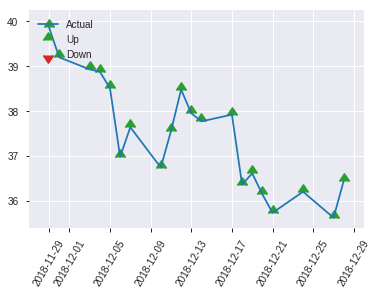


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2516246106324972
RMSE: 0.5016219798139803
LogLoss: 0.6963733879187152
Mean Per-Class Error: 0.4515186173592578
AUC: 0.5209683568433092
pr_auc: 0.5315053278910128
Gini: 0.04193671368661844
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37864920496940613: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   112  0.918    (112.0/122.0)
1      3    126  0.0233   (3.0/129.0)
Total  13   238  0.4582   (115.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378649     0.686649  237
max f2                       0.310207     0.843137  248
max f0point5                 0.378649     0.582794  237
max accuracy                 0.534018     0.541833  65
max precision                0.72123      1         0
max recall                   0.310207     1         248
max specificity              0.72123      1         0
max absolute_mcc             0.378649     0.132415  237
max min_per_class_accuracy   0.481492     0.48062   124
max mean_per_class_accuracy  0.534018     0.548481  65

Gains/Lift Table: Avg response rate: 51.39 %, avg score: 48.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.675619           1.29716   1.29716            0.666667         0.697241  0.666667                    0.697241            0.0155039       0.0155039                  29.7158   29.7158
    2        0.0239044                   0.652277           0.648579  0.972868           0.333333         0.661186  0.5                         0.679214            0.00775194      0.0232558                  -35.1421  -2.71318
    3        0.0318725                   0.640123           0         0.729651           0                0.643504  0.375                       0.670286            0               0.0232558                  -100      -27.0349
    4        0.0438247                   0.635617           1.29716   0.884426           0.666667         0.636017  0.454545                    0.66094             0.0155039       0.0387597                  29.7158   -11.5574
    5        0.0517928                   0.628956           1.94574   1.0477             1                0.631655  0.538462                    0.656435            0.0155039       0.0542636                  94.5736   4.77042
    6        0.103586                    0.588849           1.19738   1.12254            0.615385         0.60454   0.576923                    0.630487            0.0620155       0.116279                   19.7376   12.254
    7        0.151394                    0.565564           1.29716   1.17768            0.666667         0.573897  0.605263                    0.612617            0.0620155       0.178295                   29.7158   17.7683
    8        0.203187                    0.54559            1.0477    1.14455            0.538462         0.556308  0.588235                    0.598263            0.0542636       0.232558                   4.77042   14.4551
    9        0.302789                    0.523944           0.933953  1.07528            0.48             0.535361  0.552632                    0.577572            0.0930233       0.325581                   -6.60465  7.52754
    10       0.40239                     0.503624           0.856124  1.02103            0.44             0.513501  0.524752                    0.561713            0.0852713       0.410853                   -14.3876  2.103
    11       0.501992                    0.480577           0.700465  0.957426           0.36             0.492661  0.492063                    0.548012            0.0697674       0.48062                    -29.9535  -4.25741
    12       0.601594                    0.46827            1.08961   0.979311           0.56             0.47399   0.503311                    0.535757            0.108527        0.589147                   8.96124   -2.06889
    13       0.701195                    0.446572           1.3231    1.02814            0.68             0.456207  0.528409                    0.524457            0.131783        0.72093                    32.3101   2.81448
    14       0.800797                    0.4292             1.01178   1.02611            0.52             0.436782  0.527363                    0.513552            0.100775        0.821705                   1.17829   2.61098
    15       0.900398                    0.401836           0.933953  1.01592            0.48             0.415274  0.522124                    0.502681            0.0930233       0.914729                   -6.60465  1.59155
    16       1                           0.277476           0.856124  1                  0.44             0.368553  0.513944                    0.489321       

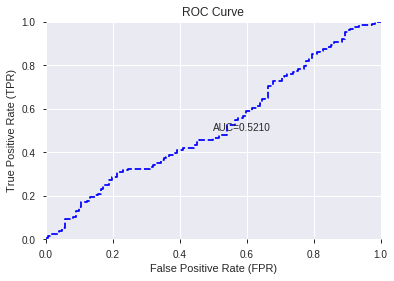

This function is available for GLM models only


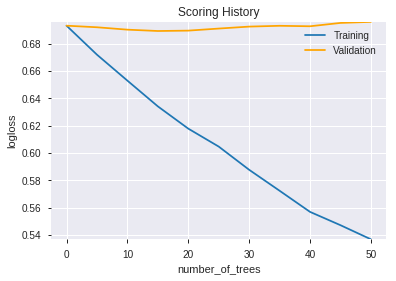

--2019-08-26 17:07:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.64
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.64|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190826_170701',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190826_170701',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_ab6c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_ab6c',
   'ty

['CORREL_30',
 'HT_DCPERIOD',
 'SIN',
 'TAN',
 'OBV',
 'STOCHRSI_fastd',
 'DX_8',
 'BETA_14',
 'BETA_20',
 'BBANDS_upperband_12_6_5',
 'ADX_14',
 'BOP',
 'HT_PHASOR_inphase',
 'BETA_30',
 'PLUS_DM_8',
 'BETA_8',
 'CCI_24',
 'STDDEV_8',
 'MFI_12',
 'MACDFIX_hist_8',
 'DIV',
 'DX_24',
 'MACDEXT_hist',
 'MACD_hist',
 'PLUS_DM_20',
 'MFI_8',
 'MFI_20',
 'BETA_24',
 'TRANGE',
 'BBANDS_upperband_12_1_5',
 'CCI_14',
 'ADX_24',
 'MINUS_DM_24',
 'WILLR_20',
 'DX_14',
 'CCI_8',
 'HT_PHASOR_quadrature',
 'AD',
 'STOCHRSI_fastk',
 'MFI_24',
 'MINUS_DI_14',
 'LINEARREG_ANGLE_14',
 'MINUS_DM_8',
 'DX_20',
 'STOCH_slowk',
 'ATR_14',
 'MOM_14',
 'MINUS_DM_14',
 'CCI_12',
 'ADX_20',
 'LINEARREG_ANGLE_8',
 'MINUS_DM_20',
 'ROC_24',
 'AROONOSC_24',
 'CMO_30',
 'STOCHF_fastd',
 'ADX_12',
 'MACDFIX_hist_24',
 'BETA_12',
 'BBANDS_upperband_20_2_5',
 'MOM_20',
 'PLUS_DM_30',
 'DX_30',
 'STOCHF_fastk',
 'WILLR_24',
 'MACDFIX_signal_8',
 'CMO_24',
 'STDDEV_12',
 'BBANDS_upperband_14_3_5',
 'STOCH_slowd',
 'STD

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.618
GLM             0.550
XGBoost         0.558
dtype: float64

DeepLearning    GLM  XGBoost
All          0.590  0.534    0.542
DLF          0.538  0.550    0.558
Fwe          0.586  0.534    0.542
RFE          0.574  0.522    0.542
XGBF         0.618  0.550    0.558





F1


DeepLearning    0.690
GLM             0.694
XGBoost         0.687
dtype: float64

DeepLearning    GLM  XGBoost
All          0.688  0.681    0.683
DLF          0.690  0.694    0.681
Fwe          0.686  0.681    0.683
RFE          0.688  0.681    0.687
XGBF         0.689  0.694    0.681





auc


DeepLearning    0.580
GLM             0.532
XGBoost         0.521
dtype: float64

DeepLearning    GLM  XGBoost
All          0.580  0.502    0.498
DLF          0.528  0.532    0.519
Fwe          0.564  0.502    0.498
RFE          0.539  0.480    0.521
XGBF         0.579  0.532    0.519





logloss


DeepLearning    1.358
GLM             0.698
XGBoost         0.708
dtype: float64

DeepLearning    GLM  XGBoost
All          0.703  0.697    0.708
DLF          0.693  0.691    0.701
Fwe          1.358  0.697    0.708
RFE          0.750  0.698    0.696
XGBF         0.694  0.691    0.701





mean_per_class_error


DeepLearning    0.456
GLM             0.475
XGBoost         0.468
dtype: float64

DeepLearning    GLM  XGBoost
All          0.415  0.472    0.468
DLF          0.456  0.454    0.442
Fwe          0.420  0.472    0.468
RFE          0.429  0.475    0.452
XGBF         0.387  0.454    0.442





rmse


DeepLearning    0.626
GLM             0.503
XGBoost         0.507
dtype: float64

DeepLearning    GLM  XGBoost
All          0.503  0.502    0.507
DLF          0.500  0.499    0.504
Fwe          0.626  0.502    0.507
RFE          0.522  0.503    0.502
XGBF         0.501  0.499    0.504





mse


DeepLearning    0.392
GLM             0.253
XGBoost         0.257
dtype: float64

DeepLearning    GLM  XGBoost
All          0.253  0.252    0.257
DLF          0.250  0.249    0.254
Fwe          0.392  0.252    0.257
RFE          0.273  0.253    0.252
XGBF         0.251  0.249    0.254

{'F1':       DeepLearning    GLM  XGBoost
 All          0.688    NaN      NaN
 DLF          0.690    NaN      NaN
 DLF            NaN  0.694      NaN
 DLF            NaN    NaN    0.681
 All            NaN  0.681      NaN
 All            NaN    NaN    0.683
 XGBF         0.689    NaN      NaN
 XGBF           NaN  0.694      NaN
 XGBF           NaN    NaN    0.681
 Fwe          0.686    NaN      NaN
 Fwe            NaN  0.681      NaN
 Fwe            NaN    NaN    0.683
 RFE          0.688    NaN      NaN
 RFE            NaN  0.681      NaN
 RFE            NaN    NaN    0.687,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.590    NaN      NaN
 DLF          0.538    NaN      NaN
 DLF            NaN  0.550      NaN
 DLF            NaN    NaN    0.558
 All            NaN  0.534      NaN
 All            NaN    NaN    0.542
 XGBF         0.618    NaN      NaN
 XGBF           NaN  0.550      NaN
 XGBF           NaN    NaN    0.558
 Fwe          0.586    NaN      NaN
 Fwe     